
# **0. 준비**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [ ]:
# 시각화에 사용할 팔레트
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')


# **1. 데이터 구조 파악**

#### **(1) 데이터 불러오기**

[Feature variable] - 10개
* tm : 시간 (날짜 및 시각, 00시~23시)
* branch_id : 지사명 (비식별화 처리)
* ta : 기온 (정시 기온,°C)
* wd : 풍향 (정시 10분 평균 풍향, degree)
* ws : 풍속 (정시 10분 평균 풍속, m/s)
* rn_day : 일 강수량 (해당 시간까지의 일강수량, mm)
* rn_hr1 : 시간 강수량 (1시간 강수량, mm)
* hm : 상대 습도 (정시 상대 습도, %)
* si : 일사량 (ASOS 일사량, MJ/m^2)
* ta_chi : 체감온도 (500m 객관분석 자료,°C)

[Target Variable]
* heat_demand : 열수요 (시간당 지사별 열 공급량, Gcal/h)

In [ ]:
# train data 불러오기
df_train = pd.read_csv("/content/drive/MyDrive/weather_bigcontest/data/train_heat.csv")
df_train = df_train.iloc[:,1:]
df_train

train_heat.tm train_heat.branch_id  train_heat.ta  train_heat.wd  \
0          2021010101                    A          -10.1           78.3   
1          2021010102                    A          -10.2           71.9   
2          2021010103                    A          -10.0          360.0   
3          2021010104                    A           -9.3          155.9   
4          2021010105                    A           -9.0           74.3   
...               ...                  ...            ...            ...   
499296     2023123119                    S            3.2          233.5   
499297     2023123120                    S            2.9          227.4   
499298     2023123121                    S            2.1          360.0   
499299     2023123122                    S            2.2           30.0   
499300     2023123123                    S            1.2          359.0   

        train_heat.ws  train_heat.rn_day  train_heat.rn_hr1  train_heat.hm  \
0                 0.5                0.0                0.0           68.2   
1                 0.6                0.0                0.0           69.9   
2                 0.0                0.0                0.0           69.2   
3                 0.5                0.0                0.0           65.0   
4                 1.9                0.0                0.0           63.5   
...               ...                ...                ...            ...   
499296            0.4                2.5                0.0           91.5   
499297            0.1                2.5                0.0           92.1   
499298            0.0                2.5                0.0           93.3   
499299            1.4                2.5                0.0           95.5   
499300            0.8                2.5                0.0           94.9   

        train_heat.si  train_heat.ta_chi  train_heat.heat_demand  
0               -99.0               -8.2                     281  
1               -99.0               -8.6                     262  
2               -99.0               -8.8                     266  
3               -99.0               -8.9                     285  
4               -99.0               -9.2                     283  
...               ...                ...                     ...  
499296          -99.0                2.8                      34  
499297          -99.0                2.7                      35  
499298          -99.0                1.4                      35  
499299          -99.0                1.3                      40  
499300          -99.0                0.6                      33  

[499301 rows x 11 columns]

#### **(2) 데이터 확인하기**

In [ ]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [ ]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [ ]:
df_train.head()

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm    si  \
0 2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2 -99.0   
1 2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9 -99.0   
2 2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2 -99.0   
3 2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0 -99.0   
4 2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5 -99.0   

   ta_chi  heat_demand  
0    -8.2          281  
1    -8.6          262  
2    -8.8          266  
3    -8.9          285  
4    -9.2          283

In [ ]:
df_train.shape # 12개의 열, 10999개의 행

(499301, 11)

In [ ]:
df_train.describe()

tm             ta             wd             ws  \
count               499301  499301.000000  499301.000000  499301.000000   
mean   2022-07-02 12:00:00      10.621007     194.322872      -2.344705   
min    2021-01-01 01:00:00     -99.000000     -99.000000     -99.000000   
25%    2021-10-01 18:00:00       4.400000     105.000000       0.500000   
50%    2022-07-02 12:00:00      14.200000     212.100000       1.100000   
75%    2023-04-02 06:00:00      22.500000     294.300000       2.000000   
max    2023-12-31 23:00:00      37.800000     360.000000      11.900000   
std                    NaN      20.878917     118.348853      19.161911   

              rn_day         rn_hr1             hm             si  \
count  499301.000000  499301.000000  499301.000000  499301.000000   
mean       -1.843207      -3.649492      53.024052     -45.600886   
min       -99.000000     -99.000000     -99.000000     -99.000000   
25%         0.000000       0.000000      44.900000     -99.000000   
50%         0.000000       0.000000      64.700000       0.000000   
75%         0.000000       0.000000      82.500000       0.960000   
max       326.500000      92.500000     100.000000       3.920000   
std        21.340679      19.082926      49.080340      49.938291   

              ta_chi    heat_demand  
count  499301.000000  499301.000000  
mean       13.869692      95.861923  
min       -99.000000     -99.000000  
25%         4.400000      25.000000  
50%        15.000000      55.000000  
75%        24.300000     116.000000  
max        37.100000     966.000000  
std        11.888126     115.269280

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           499301 non-null  float64       
 3   wd           499301 non-null  float64       
 4   ws           499301 non-null  float64       
 5   rn_day       499301 non-null  float64       
 6   rn_hr1       499301 non-null  float64       
 7   hm           499301 non-null  float64       
 8   si           499301 non-null  float64       
 9   ta_chi       499301 non-null  float64       
 10  heat_demand  499301 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 41.9+ MB


=> 실제로는 결측치가 -99로 되어있어 존재함.

In [ ]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


In [ ]:
# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: []


In [ ]:
# -9.9 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ta_chi']


=> wd만 바꾸기

In [ ]:
# -99.0을 np.nan으로 바꾸기
df_train['wd'] = df_train['wd'].replace(-9.9, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'ta_chi']


* 다시 데이터 확인

In [ ]:
df_train.head()

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  si  \
0 2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2 NaN   
1 2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9 NaN   
2 2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2 NaN   
3 2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0 NaN   
4 2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5 NaN   

   ta_chi  heat_demand  
0    -8.2        281.0  
1    -8.6        262.0  
2    -8.8        266.0  
3    -8.9        285.0  
4    -9.2        283.0

In [ ]:
df_train.shape

(499301, 11)

In [ ]:
df_train.describe()

tm             ta             wd             ws  \
count               499301  486304.000000  480486.000000  480486.000000   
mean   2022-07-02 12:00:00      13.550747     205.808888       1.440149   
min    2021-01-01 01:00:00     -19.700000      -9.900000       0.000000   
25%    2021-10-01 18:00:00       5.200000     118.500000       0.500000   
50%    2022-07-02 12:00:00      14.700000     220.800000       1.200000   
75%    2023-04-02 06:00:00      22.700000     297.100000       2.100000   
max    2023-12-31 23:00:00      37.800000     360.000000      11.900000   
std                    NaN      10.855174     105.137403       1.185264   

              rn_day         rn_hr1             hm             si  \
count  480675.000000  480147.000000  459584.000000  266379.000000   
mean        1.921587       0.154225      66.161889       1.091339   
min         0.000000       0.000000       2.500000       0.000000   
25%         0.000000       0.000000      50.300000       0.210000   
50%         0.000000       0.000000      67.600000       0.850000   
75%         0.000000       0.000000      84.000000       1.820000   
max       326.500000      92.500000     100.000000       3.920000   
std         9.649994       1.236777      21.146626       0.972380   

              ta_chi    heat_demand  
count  499281.000000  499278.000000  
mean       13.874214      95.870900  
min       -24.700000       0.000000  
25%         4.400000      25.000000  
50%        15.000000      55.000000  
75%        24.300000     116.000000  
max        37.100000     966.000000  
std        11.866881     115.264347

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           486304 non-null  float64       
 3   wd           480486 non-null  float64       
 4   ws           480486 non-null  float64       
 5   rn_day       480675 non-null  float64       
 6   rn_hr1       480147 non-null  float64       
 7   hm           459584 non-null  float64       
 8   si           266379 non-null  float64       
 9   ta_chi       499281 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [ ]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing Ratio (%)
si                  232922          46.649616
hm                   39717           7.954520
rn_hr1               19154           3.836163
ws                   18815           3.768268
wd                   18815           3.768268
rn_day               18626           3.730415
ta                   12997           2.603039
heat_demand             23           0.004606
ta_chi                  20           0.004006


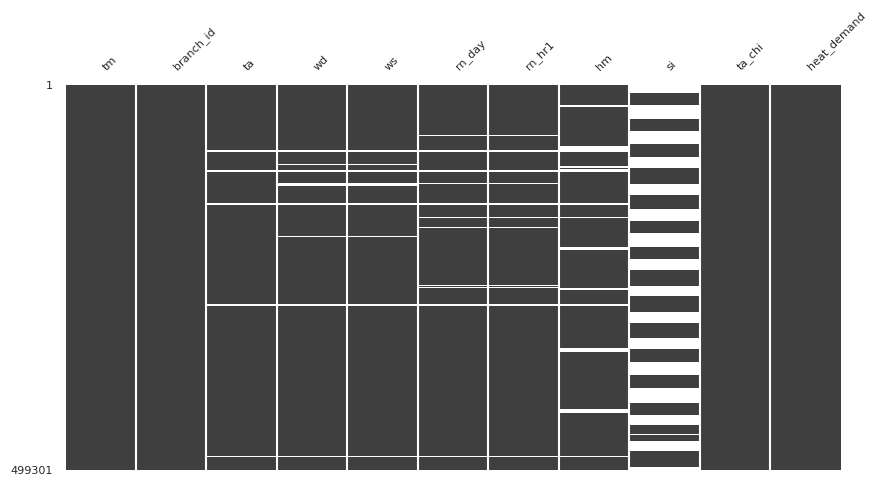

In [ ]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

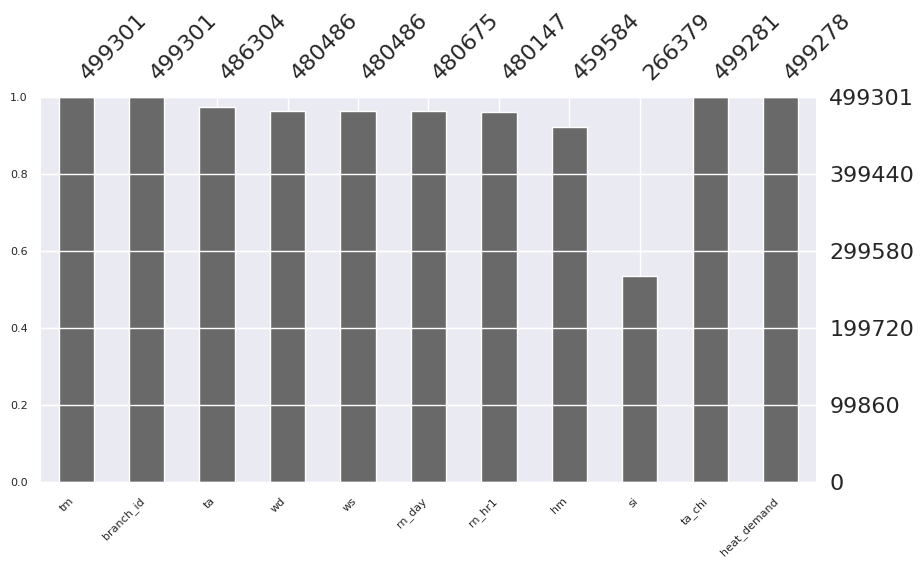

In [ ]:
# 막대그래프 형태로 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df_train, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

* Target에 결측치가 있는 경우 데이터 삭제

In [ ]:
# 타겟 변수 heat_demand에 결측이 있는 행 제거
df_train = df_train.dropna(subset=['heat_demand']).reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           480465 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           266370 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


* 시간 관련 변수 생성 (우선 EDA 및 분석을 위해서)

In [ ]:
def get_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [ ]:
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [ ]:
df_train.head()

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  si  \
0 2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2 NaN   
1 2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9 NaN   
2 2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2 NaN   
3 2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0 NaN   
4 2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5 NaN   

   ta_chi  heat_demand  year  quarter  month  day_of_week  season is_weekend  \
0    -8.2        281.0  2021        1      1            4  Winter    Weekday   
1    -8.6        262.0  2021        1      1            4  Winter    Weekday   
2    -8.8        266.0  2021        1      1            4  Winter    Weekday   
3    -8.9        285.0  2021        1      1            4  Winter    Weekday   
4    -9.2        283.0  2021        1      1            4  Winter    Weekday   

   weekofyear  hour_group  
0          53           0  
1          53           0  
2          53           1  
3          53           1  
4          53           1

* 일사량 결측 처리

In [ ]:
def compute_null_streaks(df, column_name):
    """
    특정 column에 대해 branch별 연속 결측 구간을 계산하는 함수
    """
    result = []

    for branch in df['branch_id'].unique():
        df_branch = df[df['branch_id'] == branch].copy()

        # 결측 여부 마스크
        null_mask = df_branch[column_name].isnull()

        # 연속 구간 그룹 번호 부여
        group = (null_mask != null_mask.shift()).cumsum()

        # 결측만 필터링
        df_null = df_branch[null_mask].copy()
        df_null['group'] = group[null_mask]

        # 그룹별 통계
        summary = df_null.groupby('group').agg({
            'tm': ['count', 'min', 'max']
        }).reset_index()
        summary.columns = ['group', 'length', 'start_time', 'end_time']
        summary['branch_id'] = branch
        summary['feature'] = column_name
        summary['duration_days'] = (summary['end_time'] - summary['start_time']).dt.days + 1

        result.append(summary)

    return pd.concat(result, ignore_index=True)

In [ ]:
# 각각 계산
si_null_df = compute_null_streaks(df_train, 'si')

# 길이 1 초과인 경우만 보기
si_null_df = si_null_df[si_null_df['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 결과 확인
si_null_df

group  length          start_time            end_time branch_id  \
0          1   17983 2021-01-01 01:00:00 2023-01-20 07:00:00         P   
1        823      66 2022-02-13 20:00:00 2022-02-16 13:00:00         M   
2        469      62 2021-08-22 21:00:00 2021-08-25 10:00:00         R   
3         25      61 2023-01-31 19:00:00 2023-02-03 07:00:00         P   
4        541      47 2021-09-29 14:00:00 2021-10-01 12:00:00         R   
...      ...     ...                 ...                 ...       ...   
19772   2145       2 2023-12-06 16:00:00 2023-12-06 17:00:00         D   
19773   1173       2 2022-08-08 13:00:00 2022-08-08 14:00:00         C   
19774   1173       2 2022-08-08 13:00:00 2022-08-08 14:00:00         B   
19775   1173       2 2022-08-08 13:00:00 2022-08-08 14:00:00         A   
19776   2145       2 2023-12-06 16:00:00 2023-12-06 17:00:00         S   

      feature  duration_days  
0          si            750  
1          si              3  
2          si              3  
3          si              3  
4          si              2  
...       ...            ...  
19772      si              1  
19773      si              1  
19774      si              1  
19775      si              1  
19776      si              1  

[19777 rows x 7 columns]

In [ ]:
# 브랜치별, 시작 시간 기준 정렬
si_null_df = si_null_df.sort_values(by=['branch_id', 'start_time']).reset_index(drop=True)

# 결과 확인
si_null_df

group  length          start_time            end_time branch_id  \
0          1       7 2021-01-01 01:00:00 2021-01-01 07:00:00         A   
1          3      13 2021-01-01 19:00:00 2021-01-02 07:00:00         A   
2          5      13 2021-01-02 19:00:00 2021-01-03 07:00:00         A   
3          7      13 2021-01-03 19:00:00 2021-01-04 07:00:00         A   
4          9      13 2021-01-04 19:00:00 2021-01-05 07:00:00         A   
...      ...     ...                 ...                 ...       ...   
19772   2189      13 2023-12-27 19:00:00 2023-12-28 07:00:00         S   
19773   2191      13 2023-12-28 19:00:00 2023-12-29 07:00:00         S   
19774   2193      13 2023-12-29 19:00:00 2023-12-30 07:00:00         S   
19775   2195      13 2023-12-30 19:00:00 2023-12-31 07:00:00         S   
19776   2197       5 2023-12-31 19:00:00 2023-12-31 23:00:00         S   

      feature  duration_days  
0          si              1  
1          si              1  
2          si              1  
3          si              1  
4          si              1  
...       ...            ...  
19772      si              1  
19773      si              1  
19774      si              1  
19775      si              1  
19776      si              1  

[19777 rows x 7 columns]

In [ ]:
# 2. 시간(hour)만 추출한 새로운 열 추가
si_null_df['start_hour'] = si_null_df['start_time'].dt.hour
si_null_df['end_hour'] = si_null_df['end_time'].dt.hour

# 3. 엑셀로 저장할 경로 설정
output_path = "/content/drive/MyDrive/weather_bigcontest/data/si_null_df_with_hours.xlsx"

# 4. 엑셀 파일로 저장
si_null_df.to_excel(output_path, index=False)

In [ ]:
si_null_df

group  length          start_time            end_time branch_id  \
0          1       7 2021-01-01 01:00:00 2021-01-01 07:00:00         A   
1          3      13 2021-01-01 19:00:00 2021-01-02 07:00:00         A   
2          5      13 2021-01-02 19:00:00 2021-01-03 07:00:00         A   
3          7      13 2021-01-03 19:00:00 2021-01-04 07:00:00         A   
4          9      13 2021-01-04 19:00:00 2021-01-05 07:00:00         A   
...      ...     ...                 ...                 ...       ...   
19772   2189      13 2023-12-27 19:00:00 2023-12-28 07:00:00         S   
19773   2191      13 2023-12-28 19:00:00 2023-12-29 07:00:00         S   
19774   2193      13 2023-12-29 19:00:00 2023-12-30 07:00:00         S   
19775   2195      13 2023-12-30 19:00:00 2023-12-31 07:00:00         S   
19776   2197       5 2023-12-31 19:00:00 2023-12-31 23:00:00         S   

      feature  duration_days  year  start_hour  end_hour        date  
0          si              1  2021           1         7  2021-01-01  
1          si              1  2021          19         7  2021-01-01  
2          si              1  2021          19         7  2021-01-02  
3          si              1  2021          19         7  2021-01-03  
4          si              1  2021          19         7  2021-01-04  
...       ...            ...   ...         ...       ...         ...  
19772      si              1  2023          19         7  2023-12-27  
19773      si              1  2023          19         7  2023-12-28  
19774      si              1  2023          19         7  2023-12-29  
19775      si              1  2023          19         7  2023-12-30  
19776      si              1  2023          19        23  2023-12-31  

[19777 rows x 11 columns]

2021년 A

* 19시~7시 : 1월 1일 ~ 2월 5일(2월 6일 07까지) => 13
* 20시~7시 : 2월 6일 ~ 3월 3일(3월 4일 07까지) => 12
* 20시~6시 : 3월 4일 ~ 4월 6일(4월 7일 06까지) => 11
* 21시~6시 : 4월 7일 ~ 4월 12일(4월 13일 06까지) => 10
* 21시~5시 : 4월 13일 ~ 8월 27일(8월 28일 05까지) => 9
* 21시~6시 : 8월 28일 ~ 9월 2일(9월 3일 06까지) => 10
* 20시~6시 : 9월 3일 ~ 10월 12일(10월 13일 06까지) => 11
* 19시~6시 : 10월 13일 ~ 11월 2일(11월 3일 06까지) => 12
* 19시~7시 : 11월 3일 ~ 2월 5일(2월 6일 07까지) => 13


si_null_df에서:

length가 9 이상 13 이하

start_hour가 19시 이상이면서

end_hour가 7시 이하 (또는 5시, 6시 포함)

=> 이런 행에 해당하는 start_time ~ end_time 사이의 원본 데이터(df_train)의 si NaN을 0으로 채우기!



In [ ]:
# 먼저 조건에 맞는 결측 구간 추출
si_null_cond = si_null_df[
    (si_null_df['length'].between(9, 13)) &
    (si_null_df['start_hour'] >= 19) &
    (si_null_df['end_hour'].isin([5, 6, 7]))
].copy()

# 시작과 끝 시점 기준으로 df_train에서 해당 시간 범위에 si가 NaN인 경우 0으로 채우기
for idx, row in si_null_cond.iterrows():
    branch = row['branch_id']
    start = row['start_time']
    end = row['end_time']

    # 조건: 지점 일치 + 시간 범위 + si가 NaN
    cond = (
        (df_train['branch_id'] == branch) &
        (df_train['tm'] >= start) &
        (df_train['tm'] <= end) &
        (df_train['si'].isna())
    )

    df_train.loc[cond, 'si'] = 0

In [ ]:
# 3. 엑셀로 저장할 경로 설정
output_path = "/content/drive/MyDrive/weather_bigcontest/data/df_train_si_fill.xlsx"

# 4. 엑셀 파일로 저장
df_train.to_excel(output_path, index=False)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           479594 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
 11  year         499278 non-null  int32         
 12  quarter      499278 non-null  int32         
 13  month        499278 non-null  int32         
 14  day_of_week  499278 non-null  int32         
 15  season       499278 non-null  obje

In [ ]:
sum(df_train['si'].isnull())

19684

In [ ]:
# train data 불러오기
df_train = pd.read_excel("/content/drive/MyDrive/weather_bigcontest/data/df_train_si_fill.xlsx")
df_train

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  \
0      2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2   
1      2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9   
2      2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2   
3      2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0   
4      2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5   
...                    ...       ...   ...    ...  ...     ...     ...   ...   
499273 2023-12-31 19:00:00         S   3.2  233.5  0.4     2.5     0.0  91.5   
499274 2023-12-31 20:00:00         S   2.9  227.4  0.1     2.5     0.0  92.1   
499275 2023-12-31 21:00:00         S   2.1  360.0  0.0     2.5     0.0  93.3   
499276 2023-12-31 22:00:00         S   2.2   30.0  1.4     2.5     0.0  95.5   
499277 2023-12-31 23:00:00         S   1.2  359.0  0.8     2.5     0.0  94.9   

        si  ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
0      NaN    -8.2          281  2021        1      1            4  Winter   
1      NaN    -8.6          262  2021        1      1            4  Winter   
2      NaN    -8.8          266  2021        1      1            4  Winter   
3      NaN    -8.9          285  2021        1      1            4  Winter   
4      NaN    -9.2          283  2021        1      1            4  Winter   
...     ..     ...          ...   ...      ...    ...          ...     ...   
499273 NaN     2.8           34  2023        4     12            6  Winter   
499274 NaN     2.7           35  2023        4     12            6  Winter   
499275 NaN     1.4           35  2023        4     12            6  Winter   
499276 NaN     1.3           40  2023        4     12            6  Winter   
499277 NaN     0.6           33  2023        4     12            6  Winter   

       is_weekend  weekofyear  hour_group  
0         Weekday          53           0  
1         Weekday          53           0  
2         Weekday          53           1  
3         Weekday          53           1  
4         Weekday          53           1  
...           ...         ...         ...  
499273    Weekend          52           6  
499274    Weekend          52           6  
499275    Weekend          52           7  
499276    Weekend          52           7  
499277    Weekend          52           7  

[499278 rows x 19 columns]

# **2. Clustering**

### **2-1) banch_id별 분포**

* branch_id별 분포

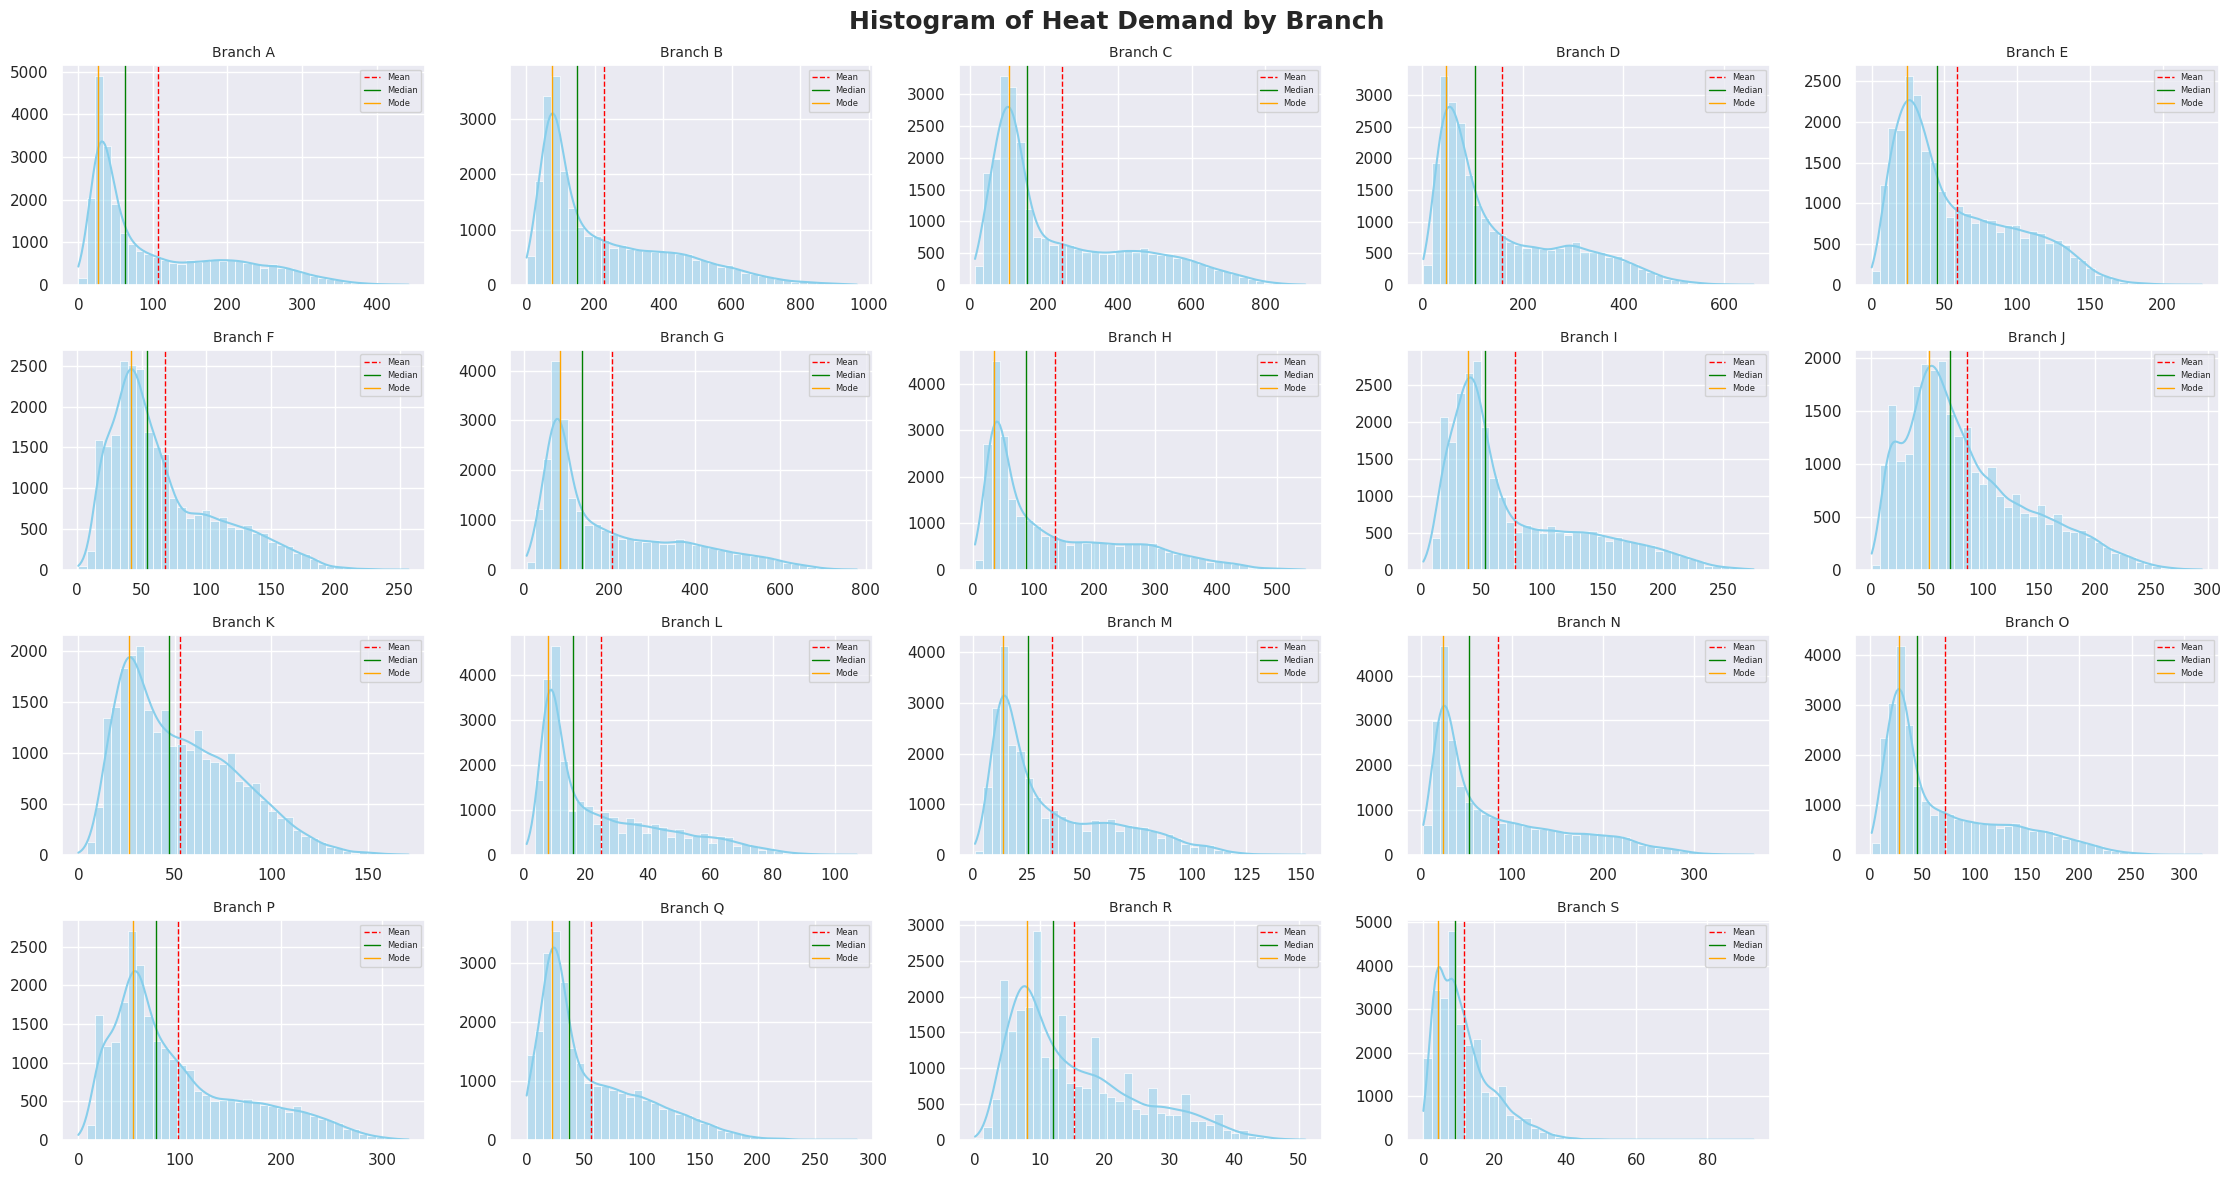

In [ ]:
branch_ids = df_train['branch_id'].unique()
n_branches = len(branch_ids)

n_cols = 5
n_rows = (n_branches // n_cols) + int(n_branches % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3))
fig.suptitle("Histogram of Heat Demand by Branch", fontsize=18, fontweight='bold')
axes = axes.flatten()

for idx, branch_id in enumerate(branch_ids):
    ax = axes[idx]
    data = df_train[df_train['branch_id'] == branch_id]['heat_demand']

    mean = data.mean()
    median = data.median()
    mode = data.mode()[0] if not data.mode().empty else median

    # Histogram + KDE
    sns.histplot(data, bins=40, kde=True, color='skyblue', ax=ax)

    # Vertical lines for mean / median / mode
    ax.axvline(mean, color='red', linestyle='--', linewidth=1, label='Mean')
    ax.axvline(median, color='green', linestyle='-', linewidth=1, label='Median')
    ax.axvline(mode, color='orange', linestyle='-', linewidth=1, label='Mode')

    ax.set_title(f"Branch {branch_id}", fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(fontsize=6, loc='upper right')

# 나머지 빈 subplot 비우기
for i in range(len(branch_ids), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

* 지사별 열수요 분포

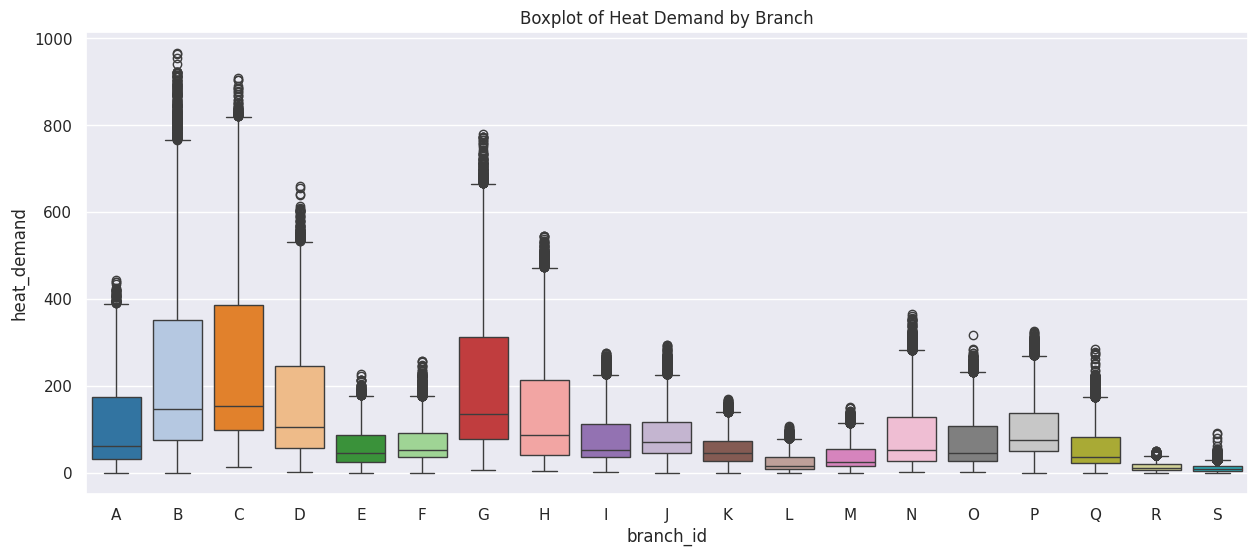

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='branch_id', y='heat_demand', data=df_train, palette='tab20')
plt.title('Boxplot of Heat Demand by Branch')
plt.show()


* 브랜치별 시간에 따른 평균 열수요

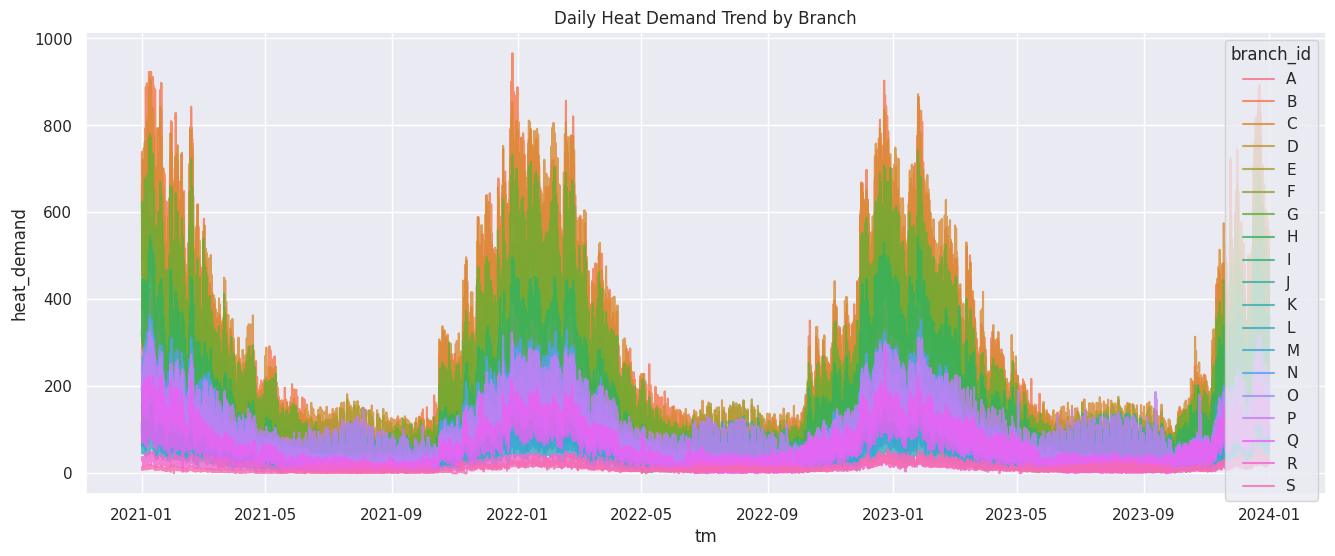

In [ ]:
daily_branch_avg = df_train.groupby(['tm', 'branch_id'])['heat_demand'].mean().reset_index()
plt.figure(figsize=(16,6))
sns.lineplot(data=daily_branch_avg, x='tm', y='heat_demand', hue='branch_id', alpha=0.8)
plt.title('Daily Heat Demand Trend by Branch')
plt.show()

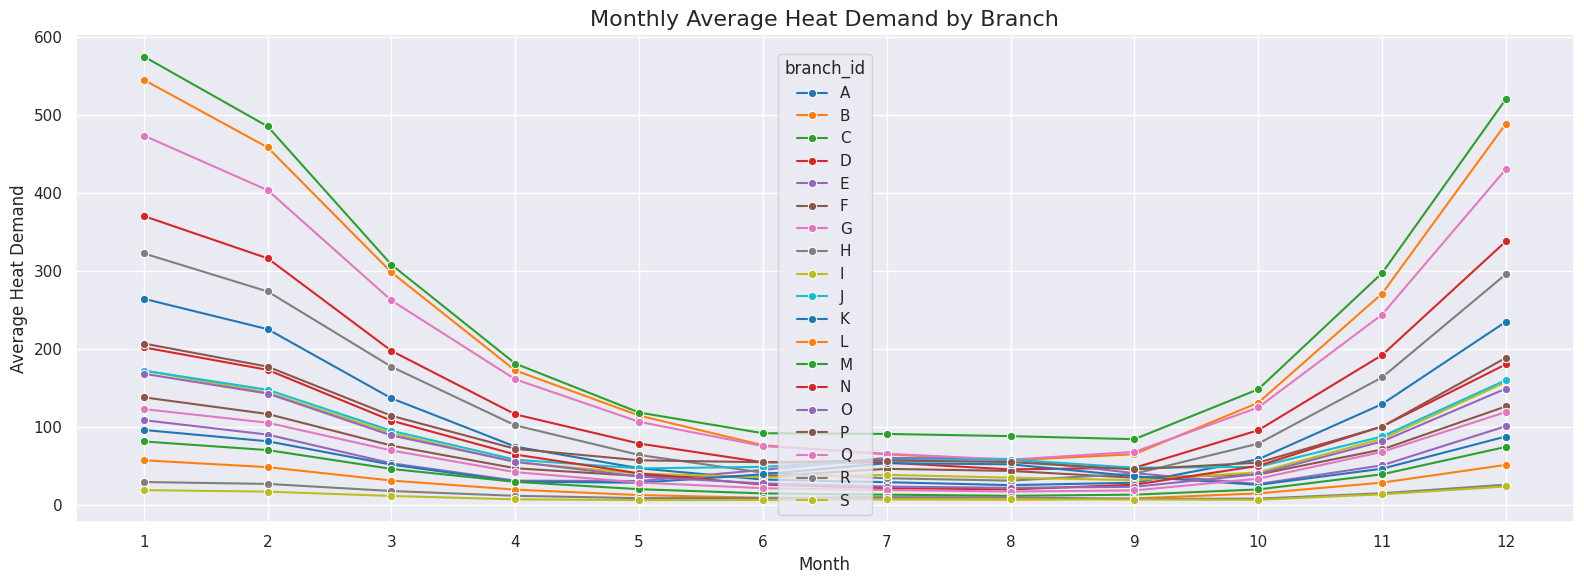

In [ ]:
# 월별 평균 열수요 계산
monthly_branch_avg = df_train.groupby(['month', 'branch_id'])['heat_demand'].mean().reset_index()

# 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_branch_avg, x='month', y='heat_demand', hue='branch_id', marker='o', palette='tab10')
plt.title('Monthly Average Heat Demand by Branch', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Heat Demand')
plt.xticks(ticks=range(1, 13))  # 1~12월 표시
plt.grid(True)
plt.tight_layout()
plt.show()


* 브랜치별 열수요 상관관계 heatmap

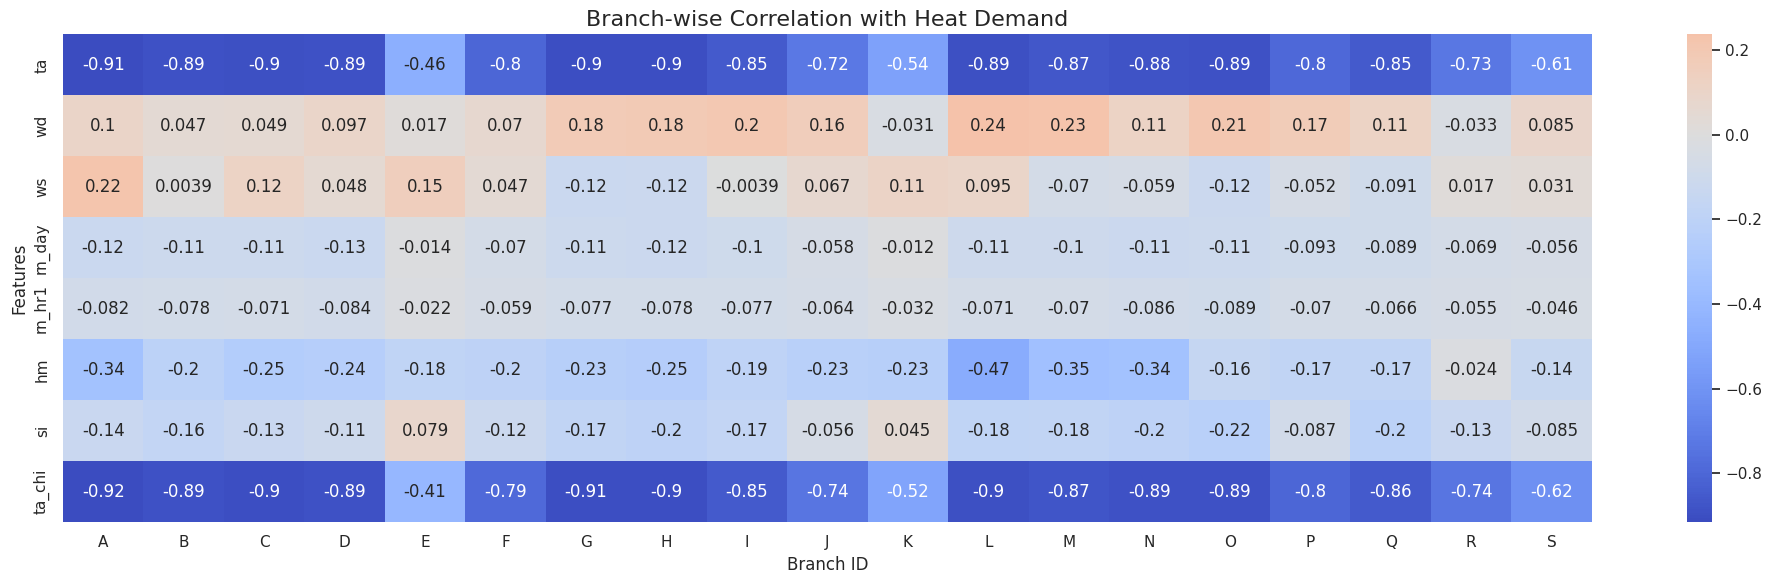

In [ ]:
numeric_features = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi']

corr_list = []
branch_ids = df_train['branch_id'].unique()

for b in branch_ids:
    df_branch = df_train[df_train['branch_id'] == b]
    corr = df_branch[numeric_features + ['heat_demand']].corr()['heat_demand'].drop('heat_demand')
    corr_list.append(corr)

# 데이터프레임 형태로 변환
corr_df = pd.concat(corr_list, axis=1)
corr_df.columns = branch_ids

# 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=True)
plt.title('Branch-wise Correlation with Heat Demand', fontsize=16)
plt.xlabel('Branch ID')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

* 지사별 기온과 열수요

Text(0.5, 0.98, 'Heat Demand vs Wind Direction by Branch')

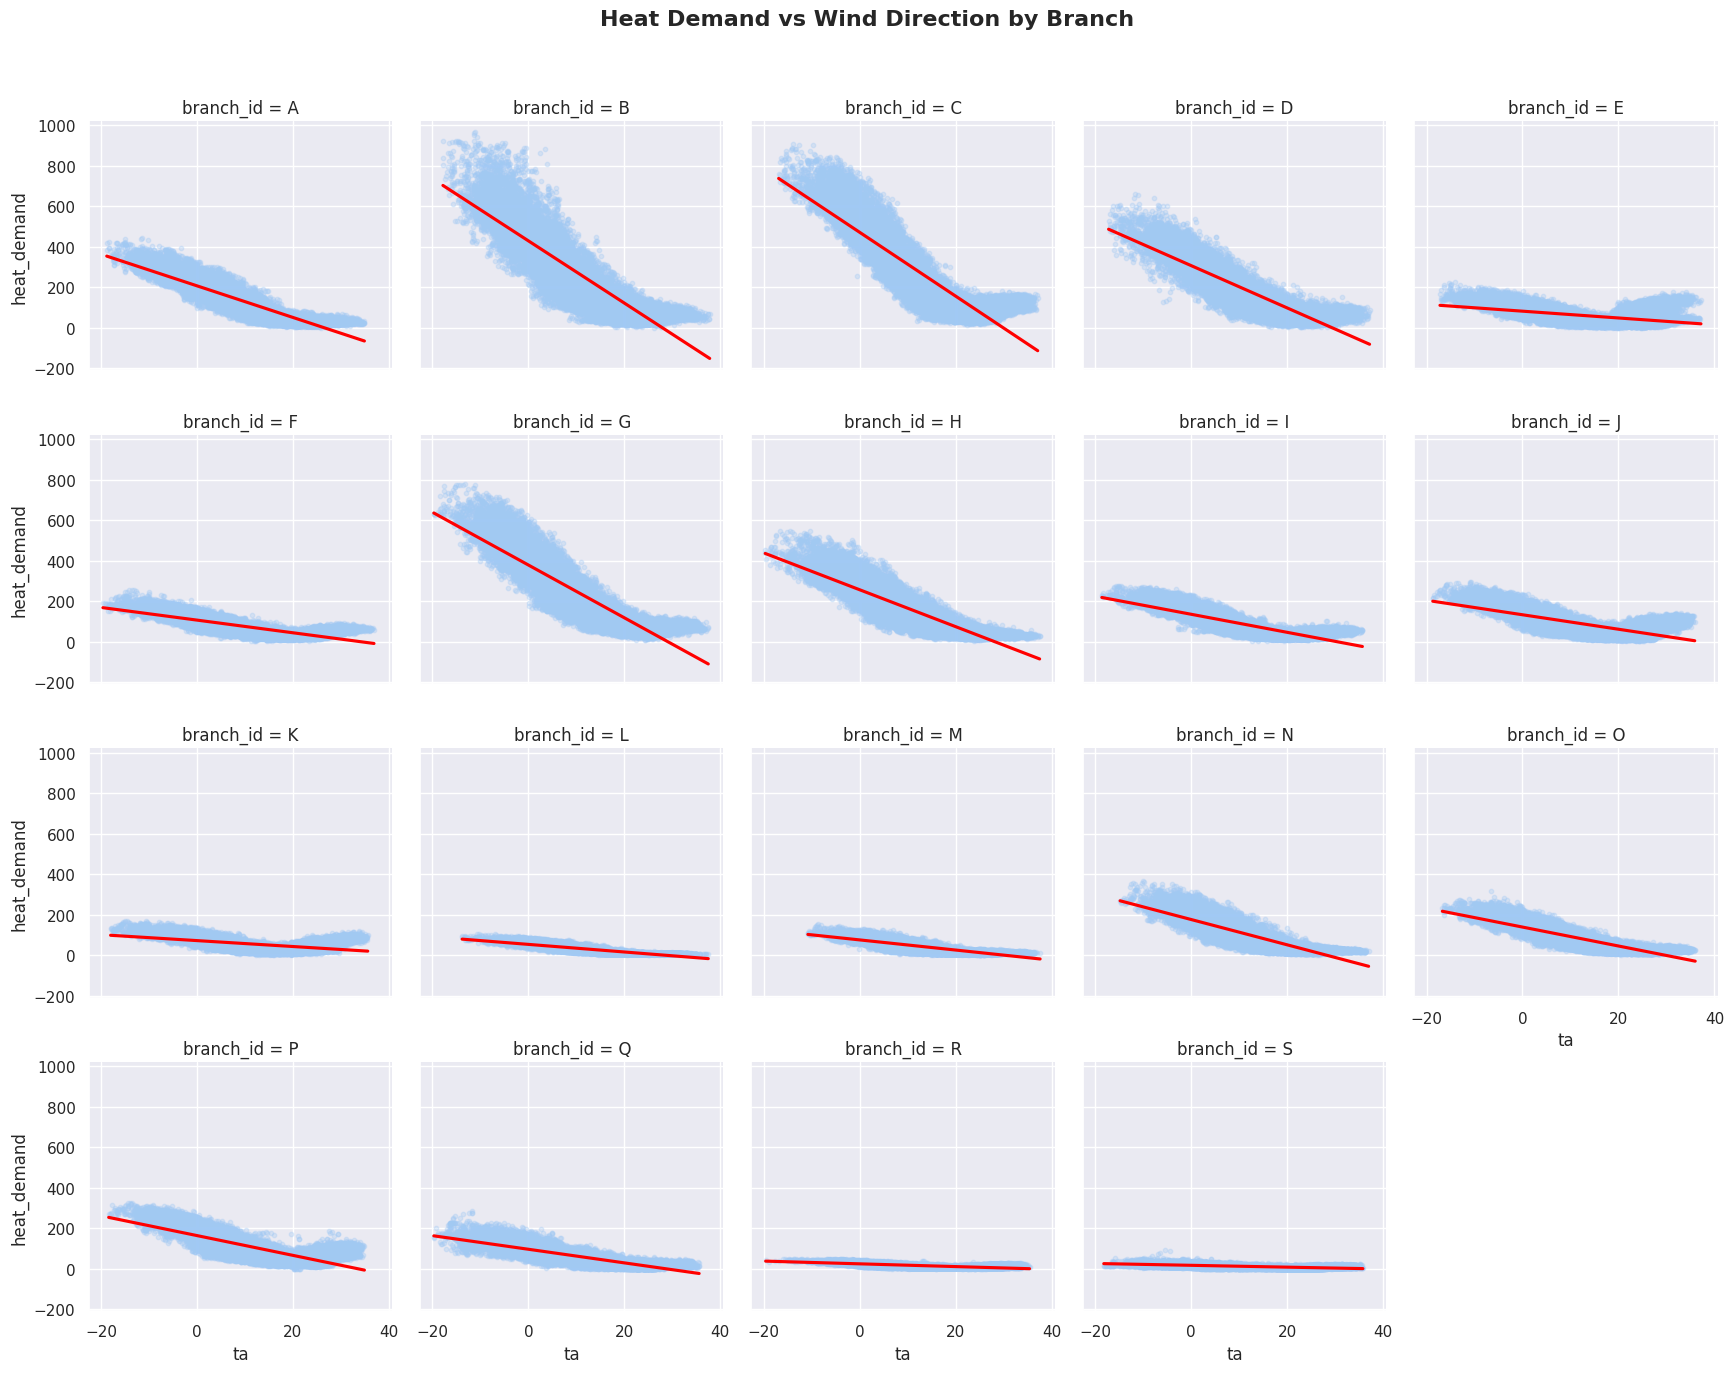

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='ta', y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5, aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Wind Direction by Branch', fontsize=16, fontweight='bold')

* 지사별 wd	x 열수요

Text(0.5, 0.98, 'Heat Demand vs Wind Direction by Branch')

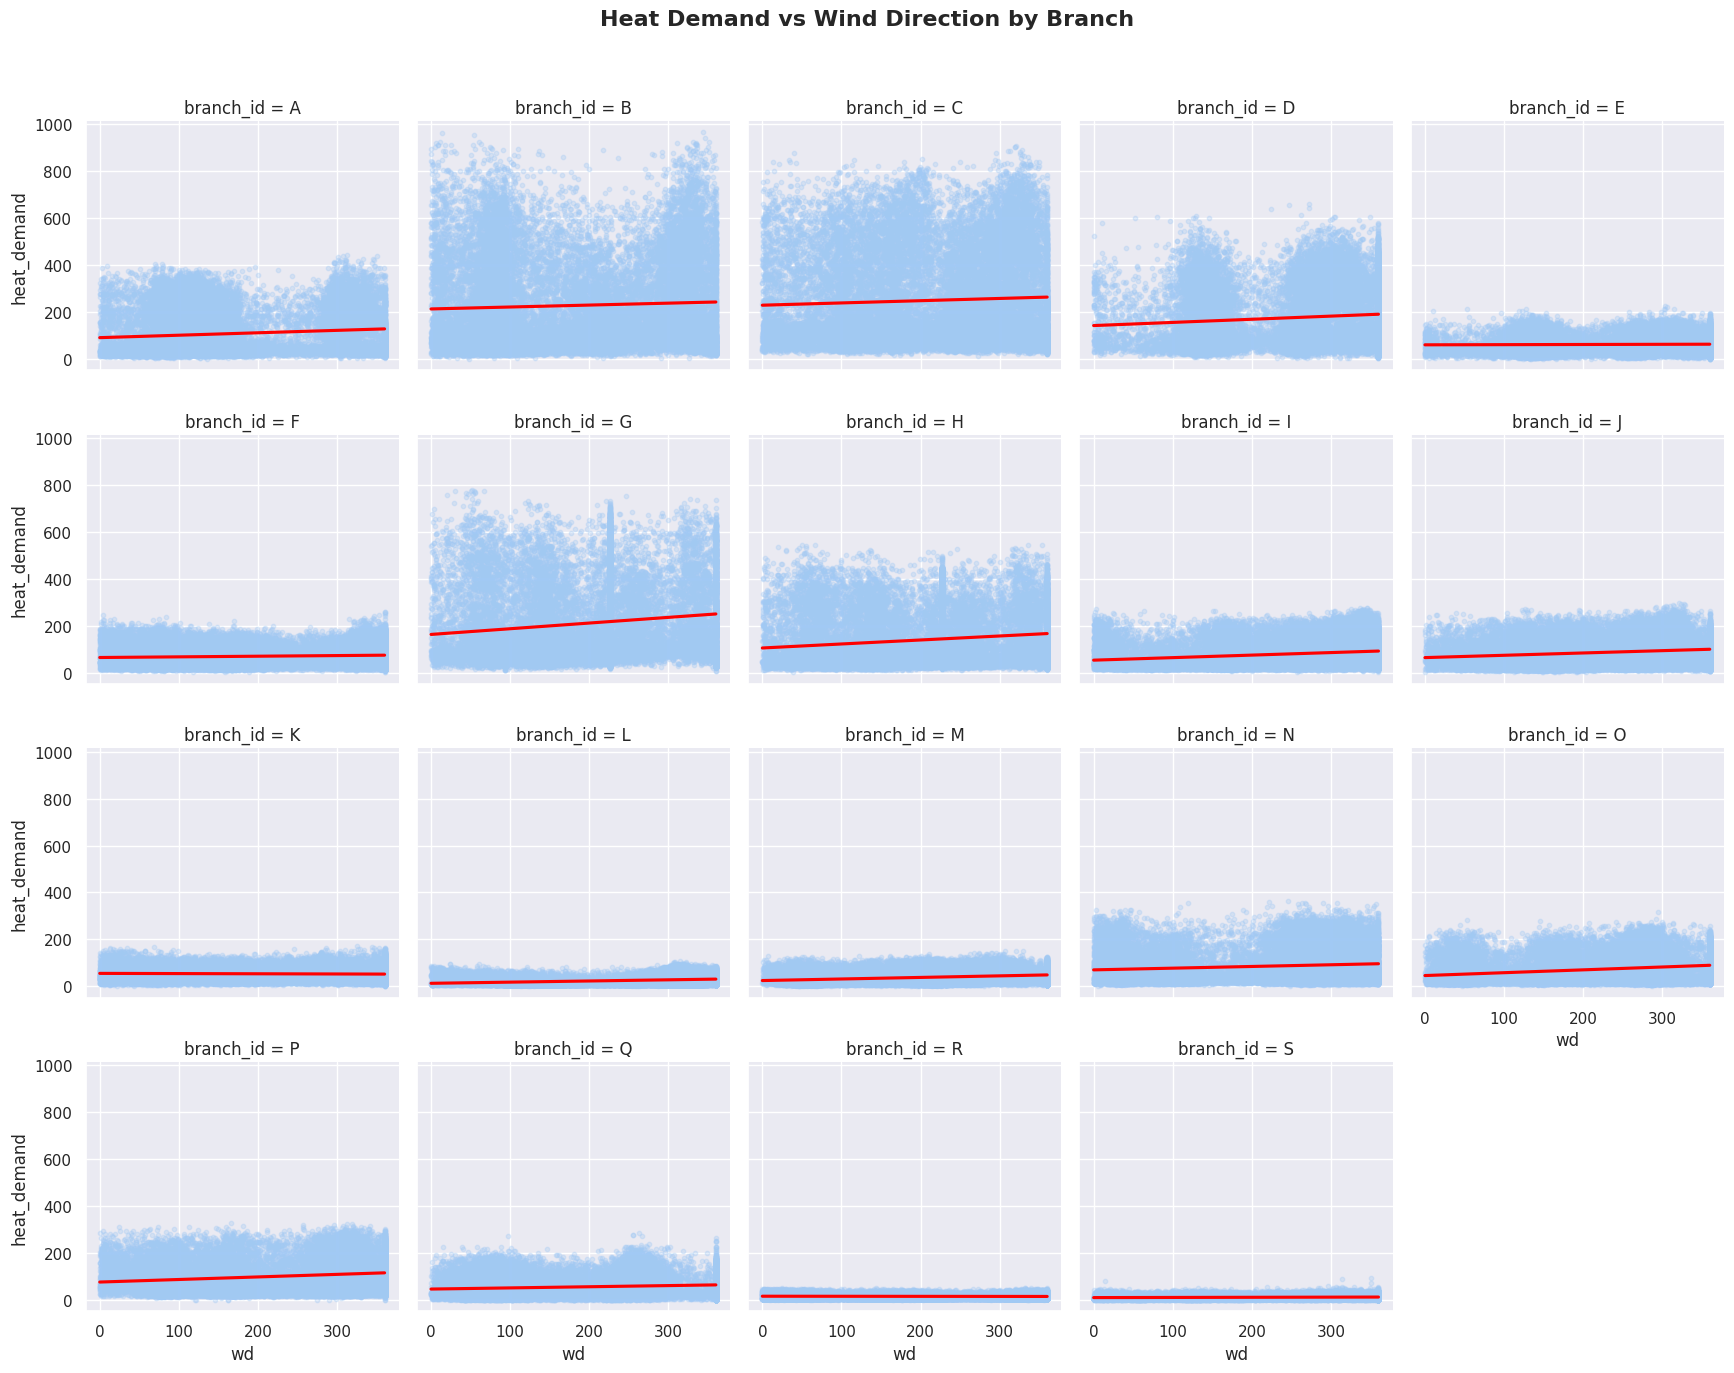

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='wd',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Wind Direction by Branch', fontsize=16, fontweight='bold')

* 지사별 ws	x 열수요

Text(0.5, 0.98, 'Heat Demand vs ws by Branch')

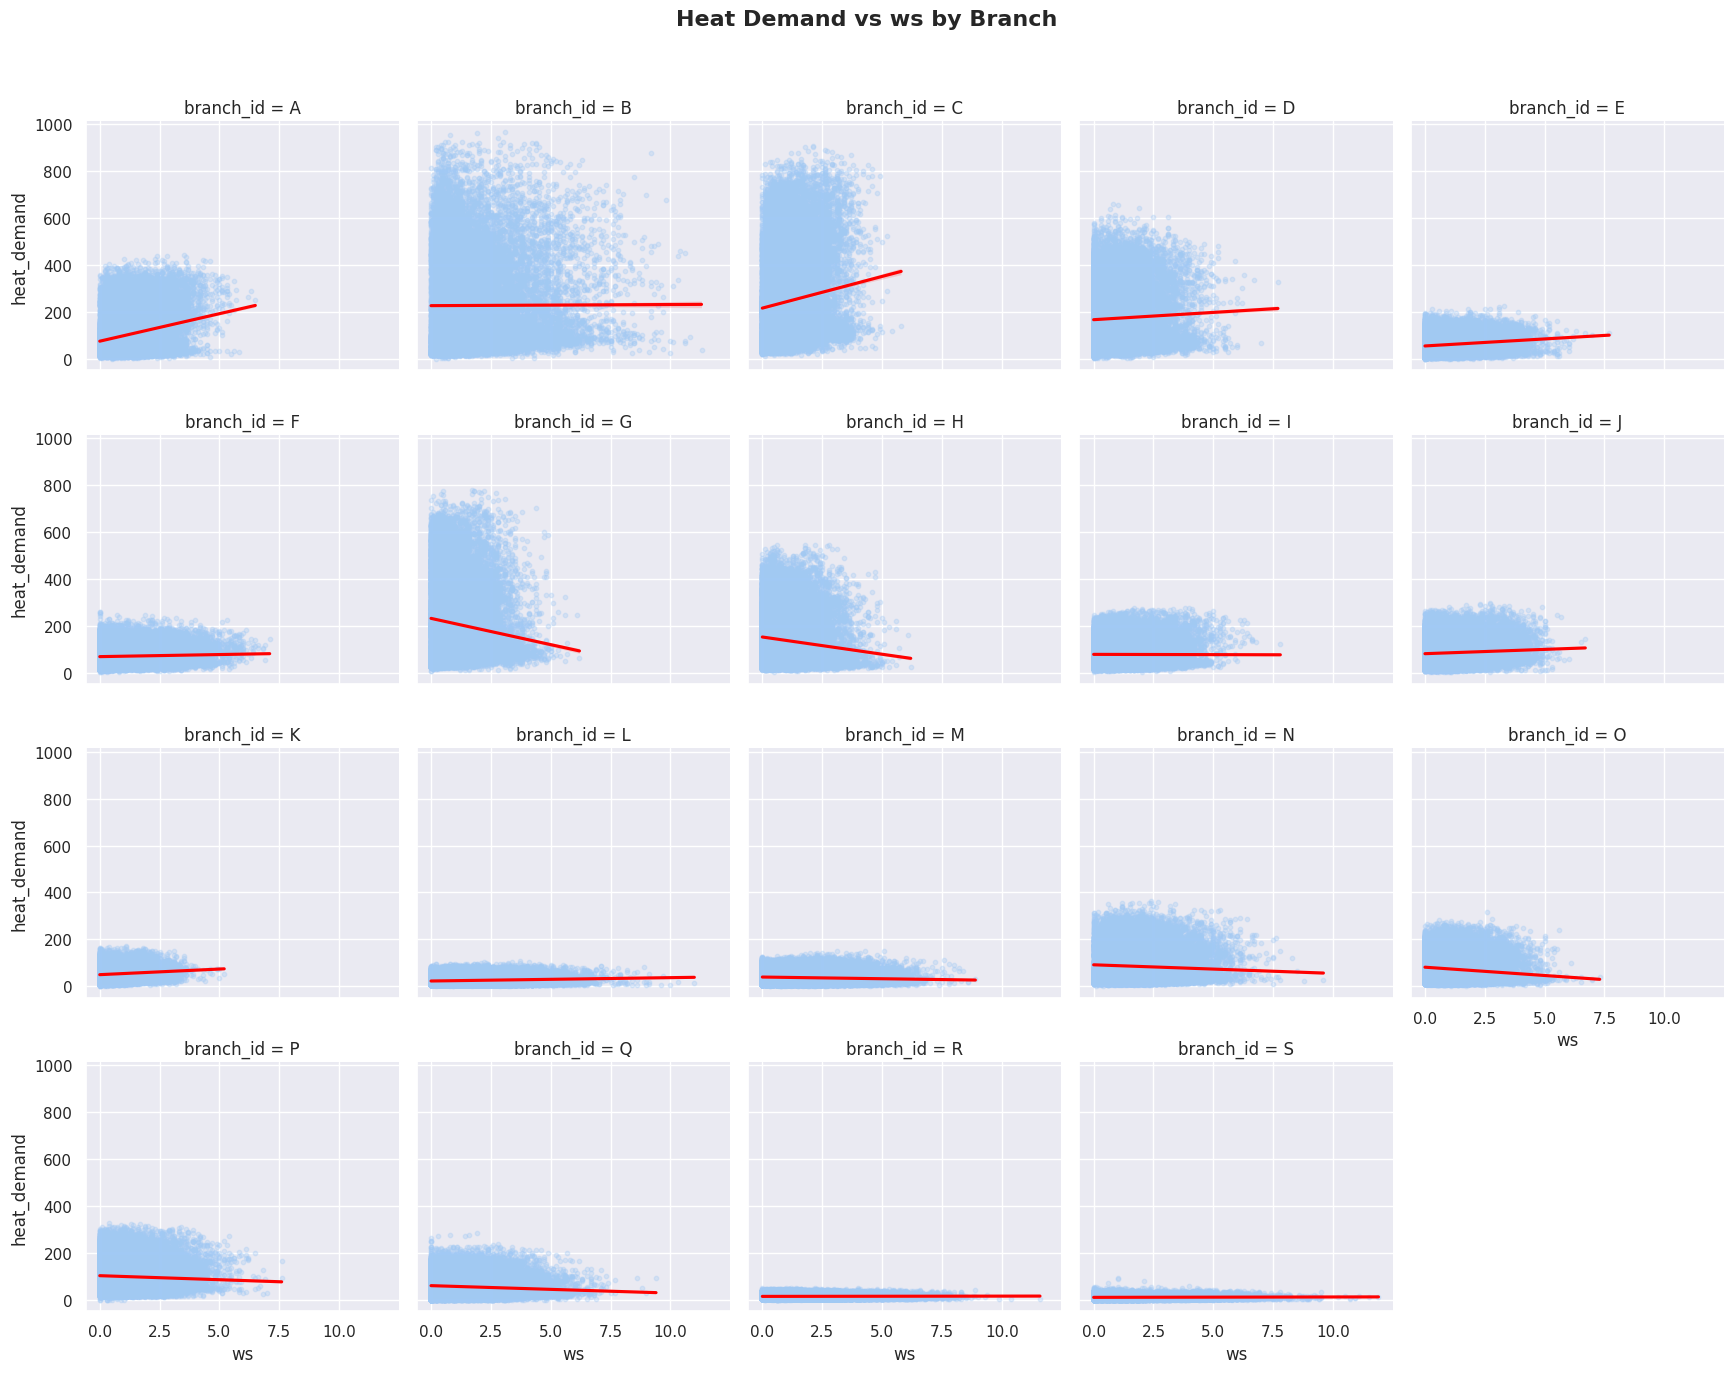

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='ws',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs ws by Branch', fontsize=16, fontweight='bold')

* 지사별 rn_day	x 열수요

Text(0.5, 0.98, 'Heat Demand vs ws by Branch')

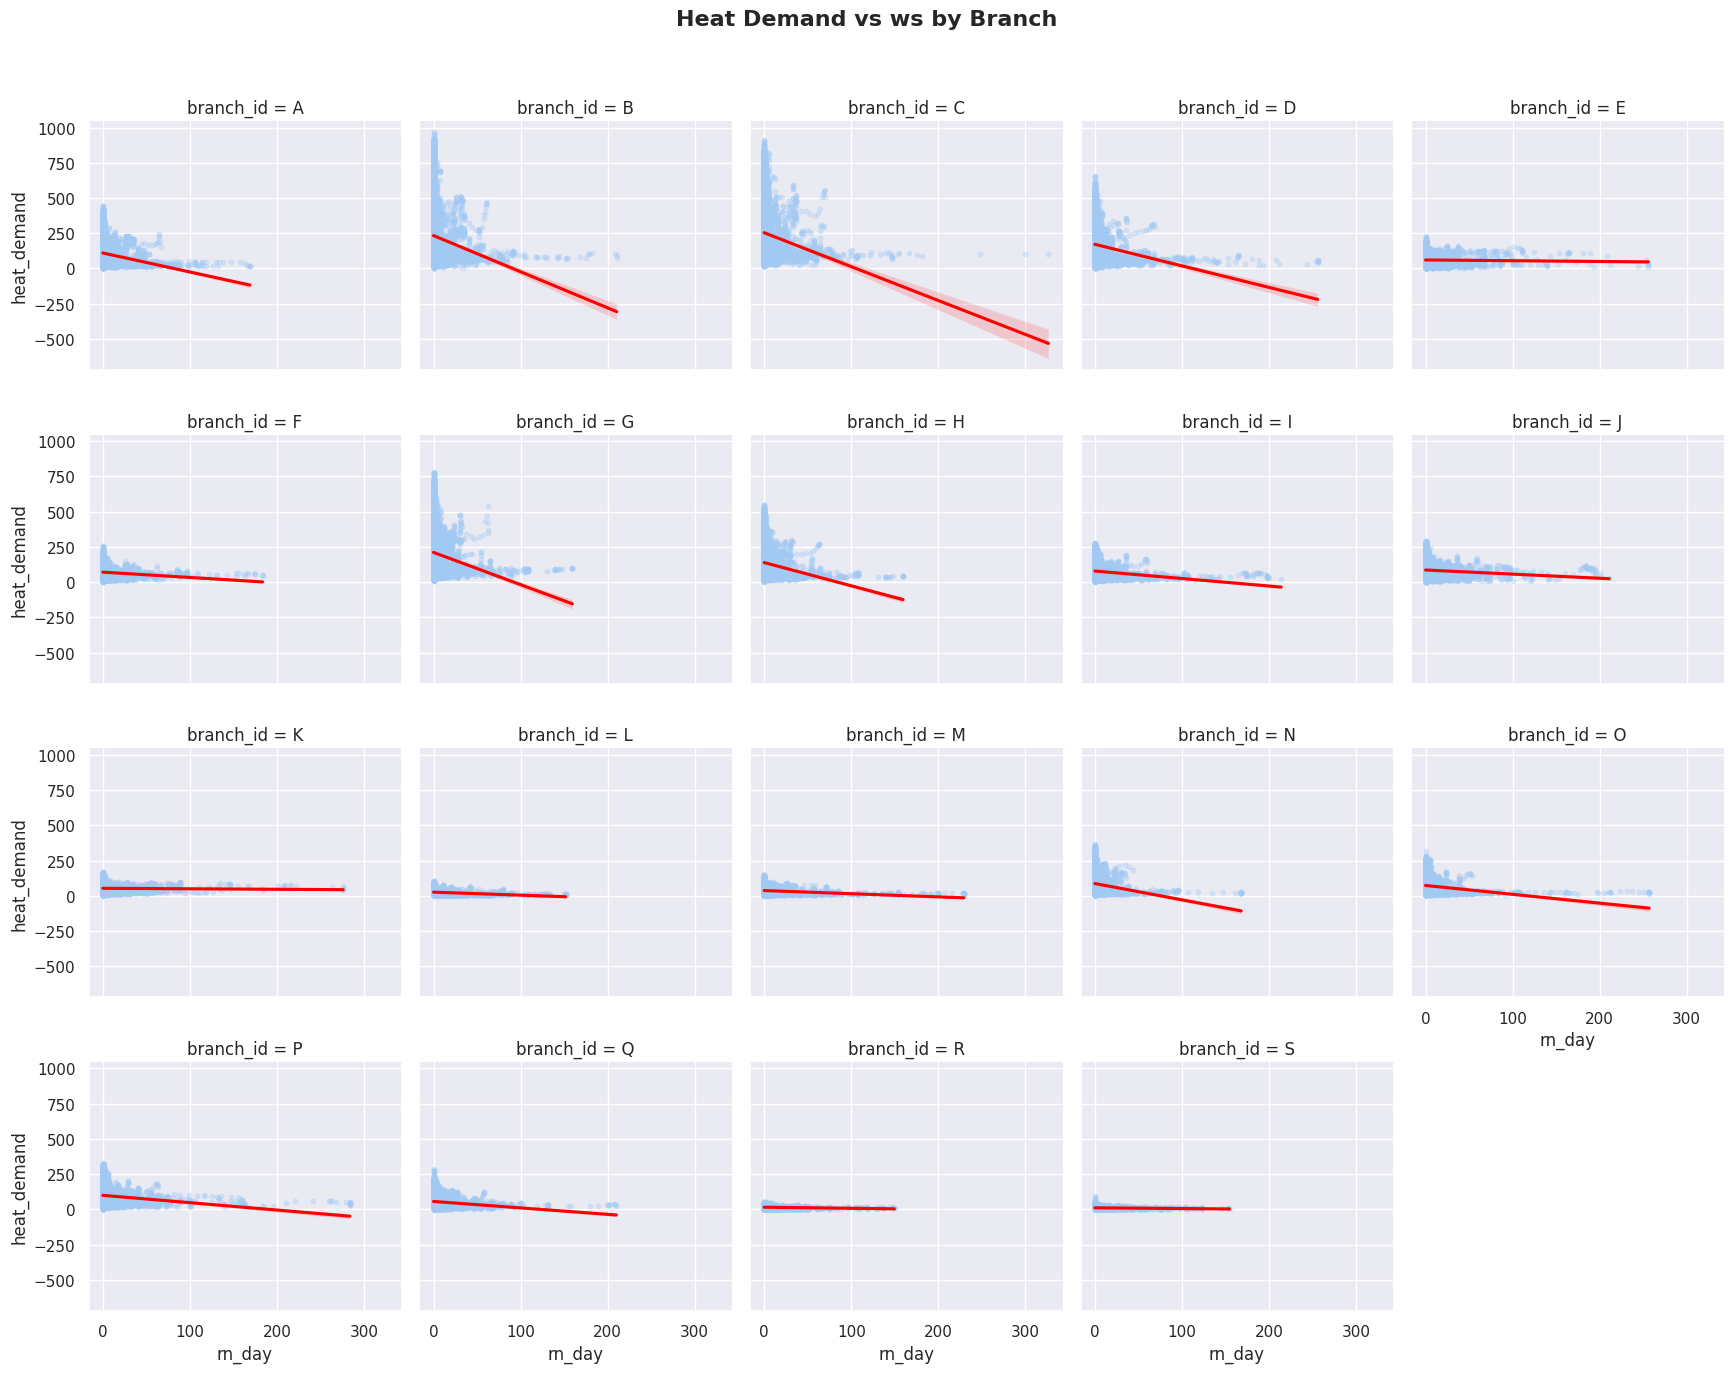

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='rn_day',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs rn_day by Branch', fontsize=16, fontweight='bold')

* 지사별 rn_hr1	x 열수요

Text(0.5, 0.98, 'Heat Demand vs rn_hr1 by Branch')

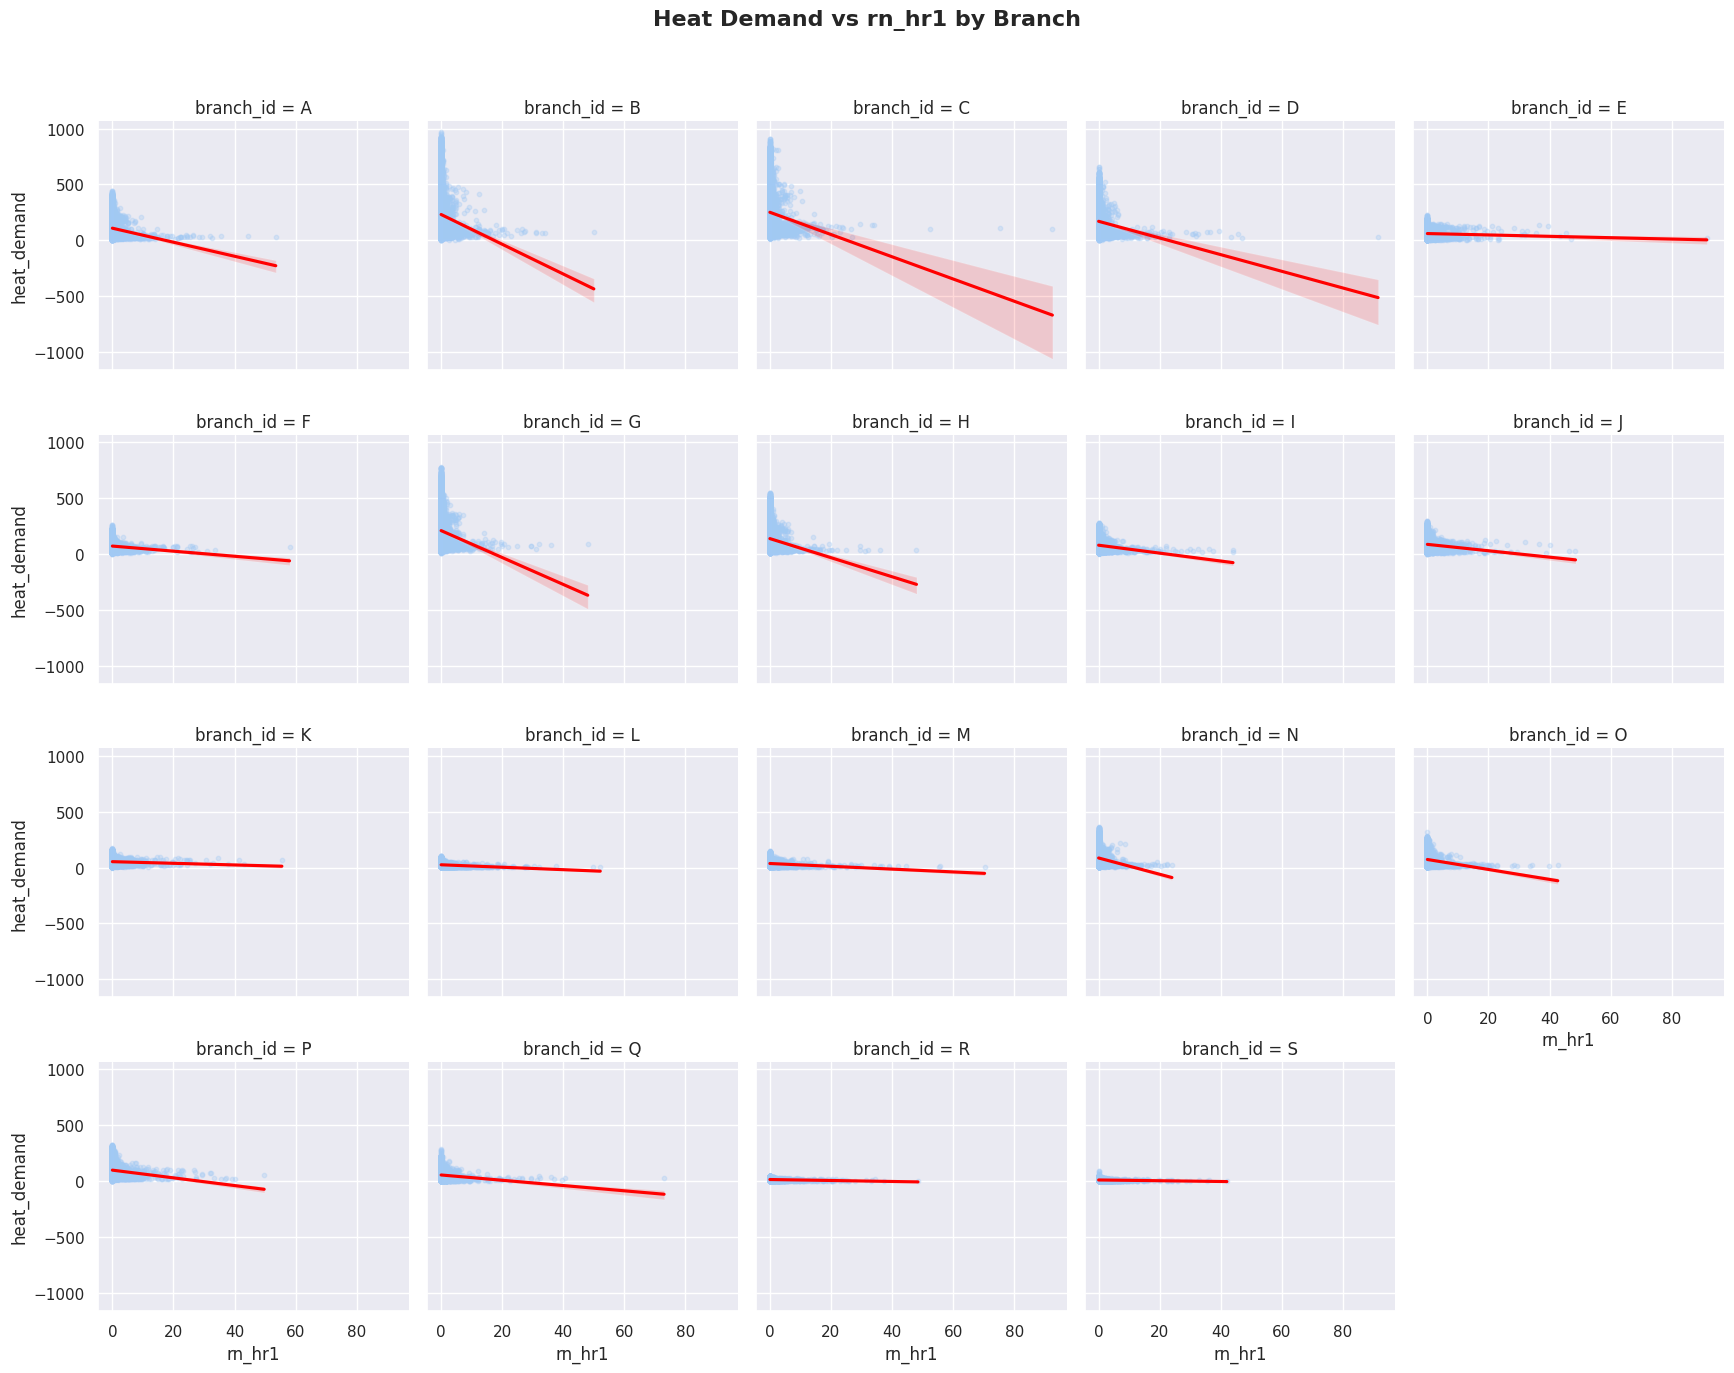

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='rn_hr1',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs rn_hr1 by Branch', fontsize=16, fontweight='bold')

* 지사별 hm	x 열수요

Text(0.5, 0.98, 'Heat Demand vs hm by Branch')

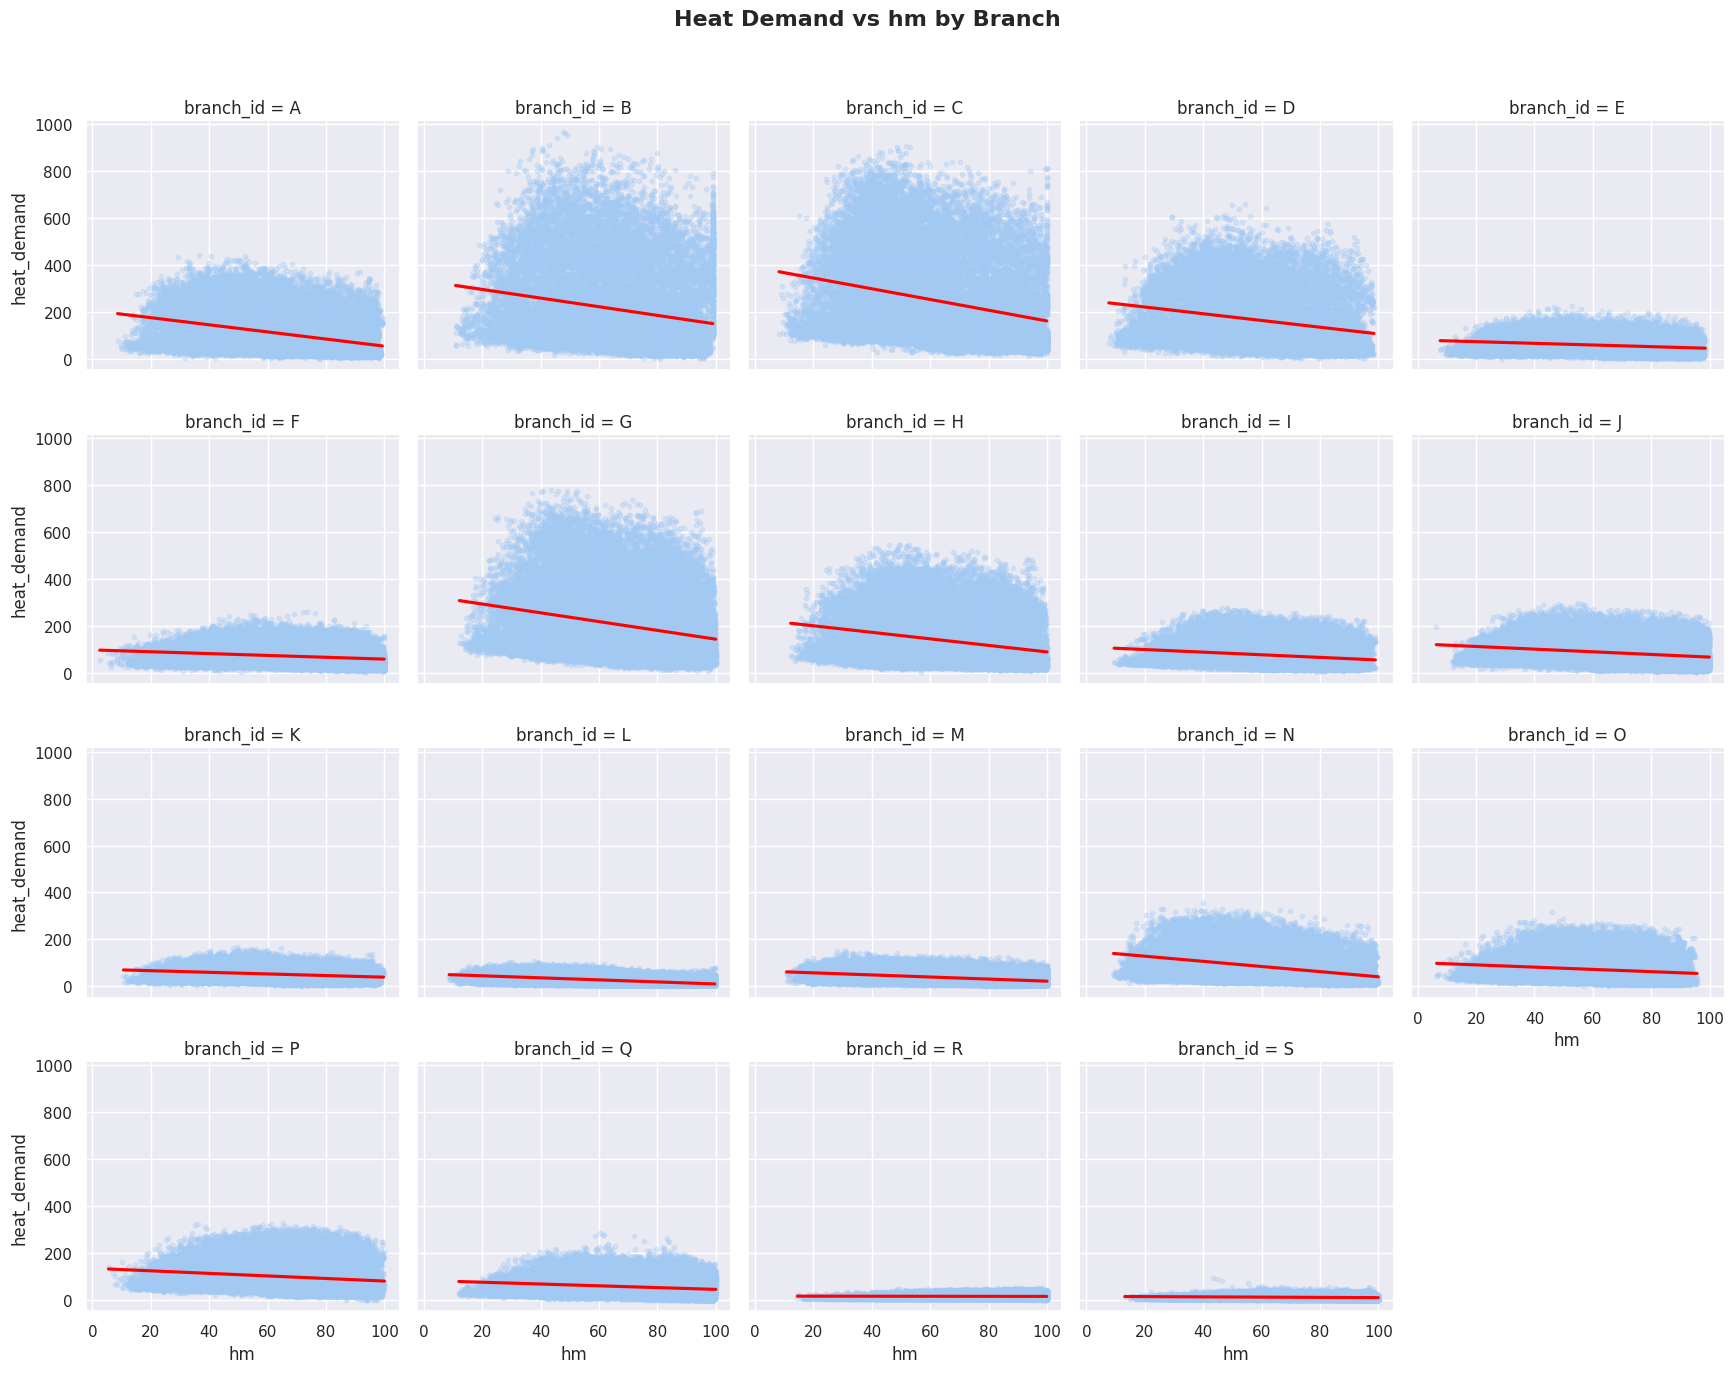

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='hm',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs hm by Branch', fontsize=16, fontweight='bold')

* 지사별 si	x 열수요

Text(0.5, 0.98, 'Heat Demand vs si by Branch')

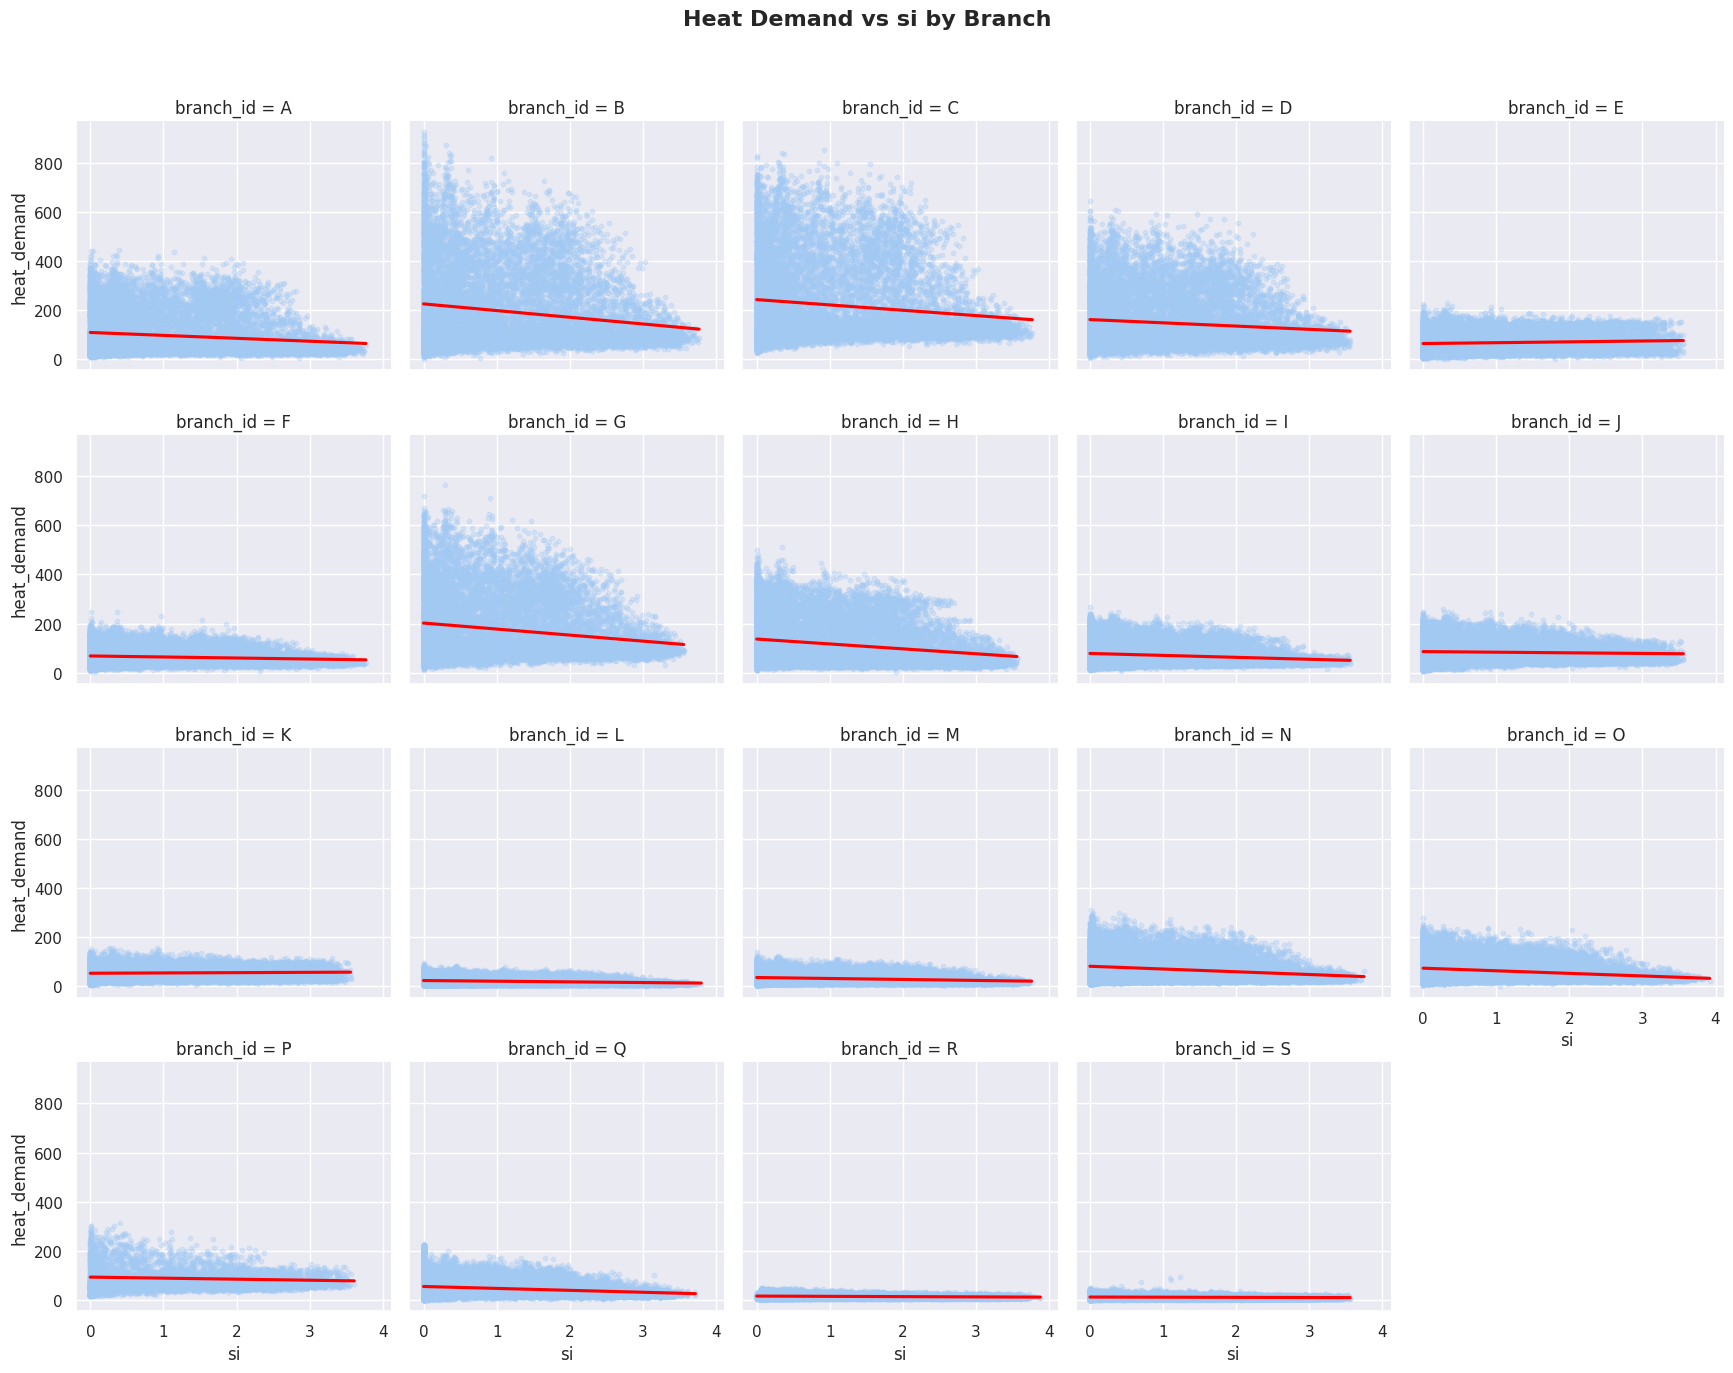

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='si',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs si by Branch', fontsize=16, fontweight='bold')

* 지사별 ta_chi	x 열수요

Text(0.5, 0.98, 'Heat Demand vs ta_chi by Branch')

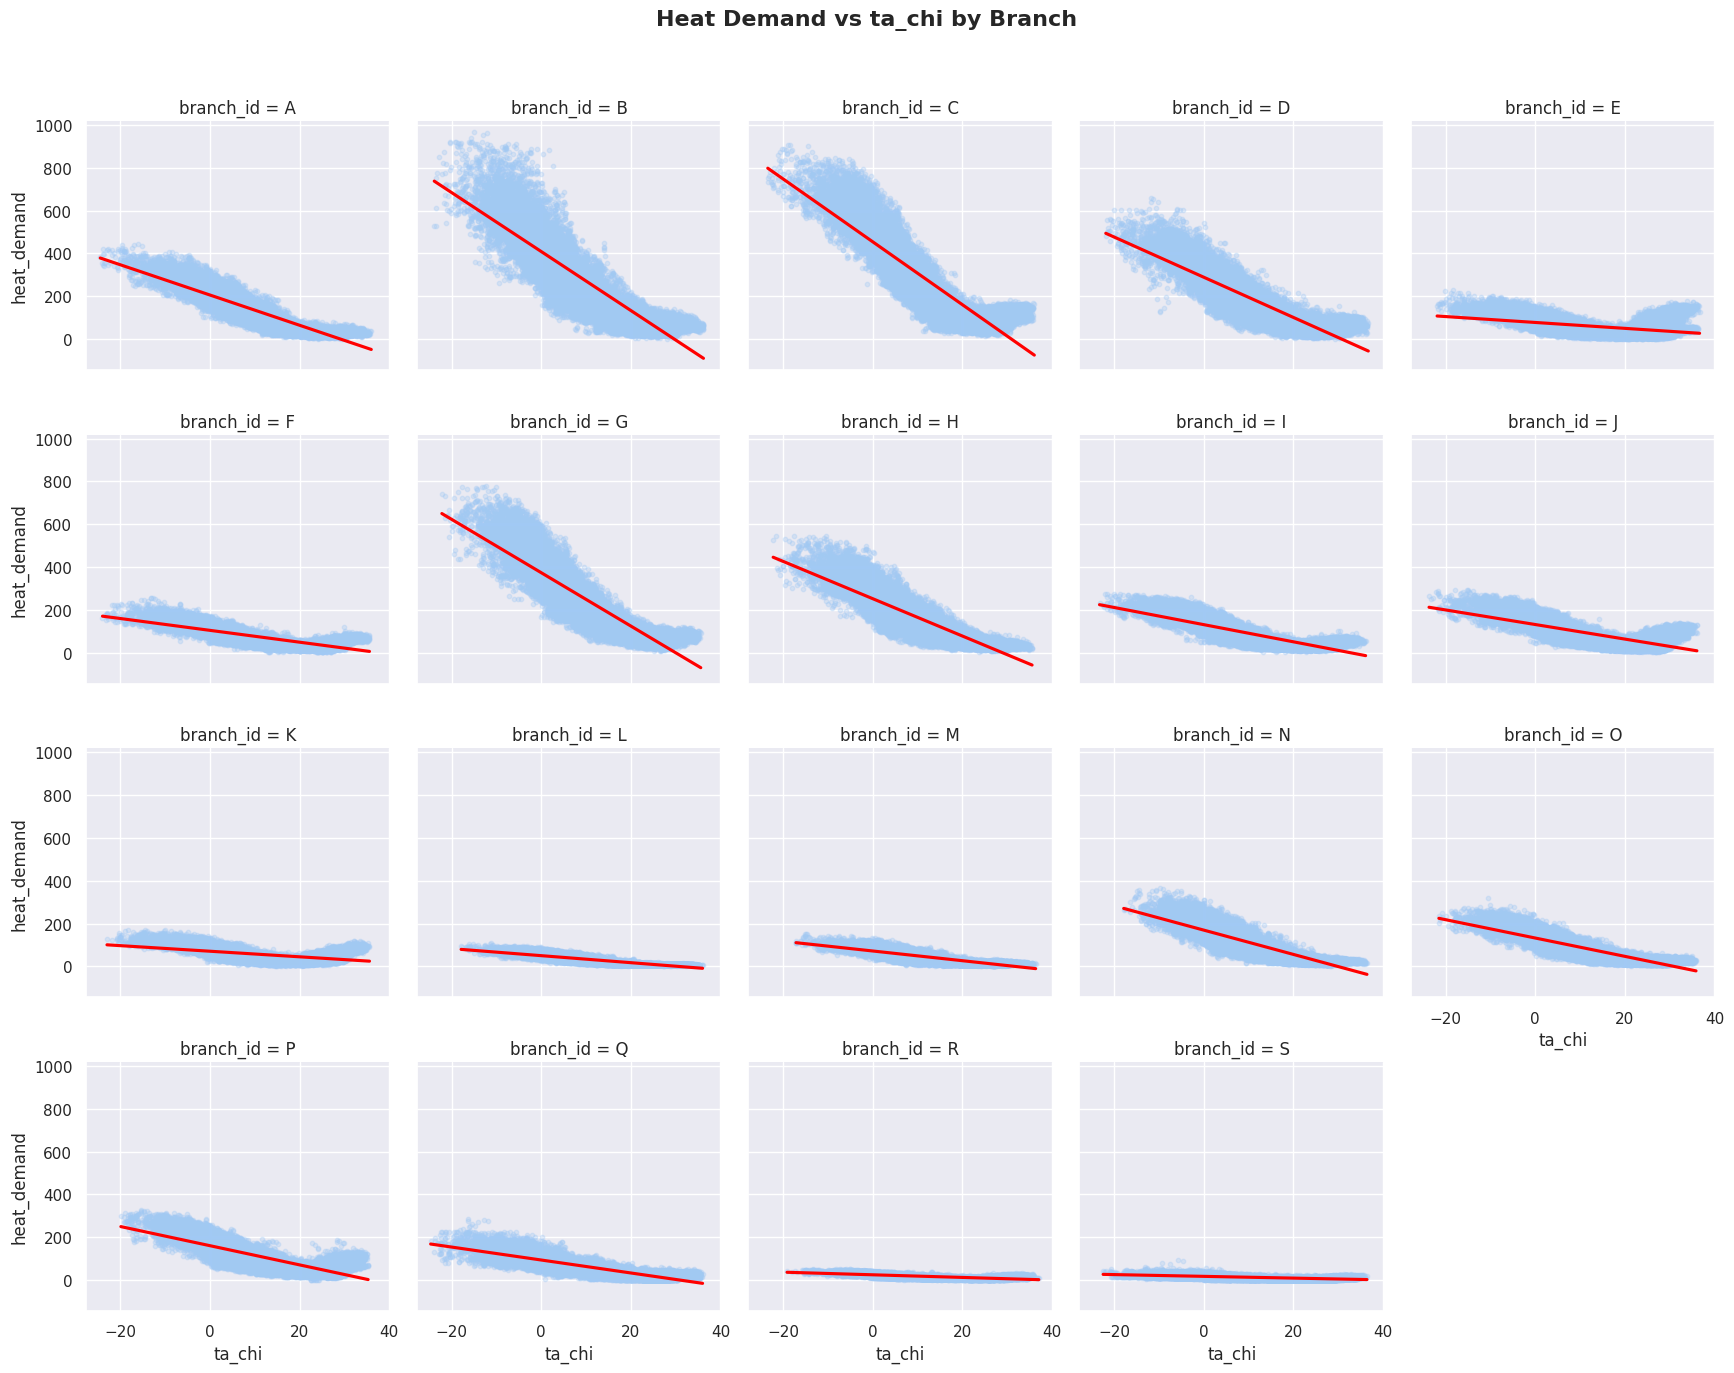

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='ta_chi',
    y='heat_demand',
    col='branch_id',
    col_wrap=5,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3.5,
    aspect=1
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs ta_chi by Branch', fontsize=16, fontweight='bold')

* 지사별 요일	x 열수요

Text(0.5, 0.98, 'Heat Demand by Day of Week per Branch')

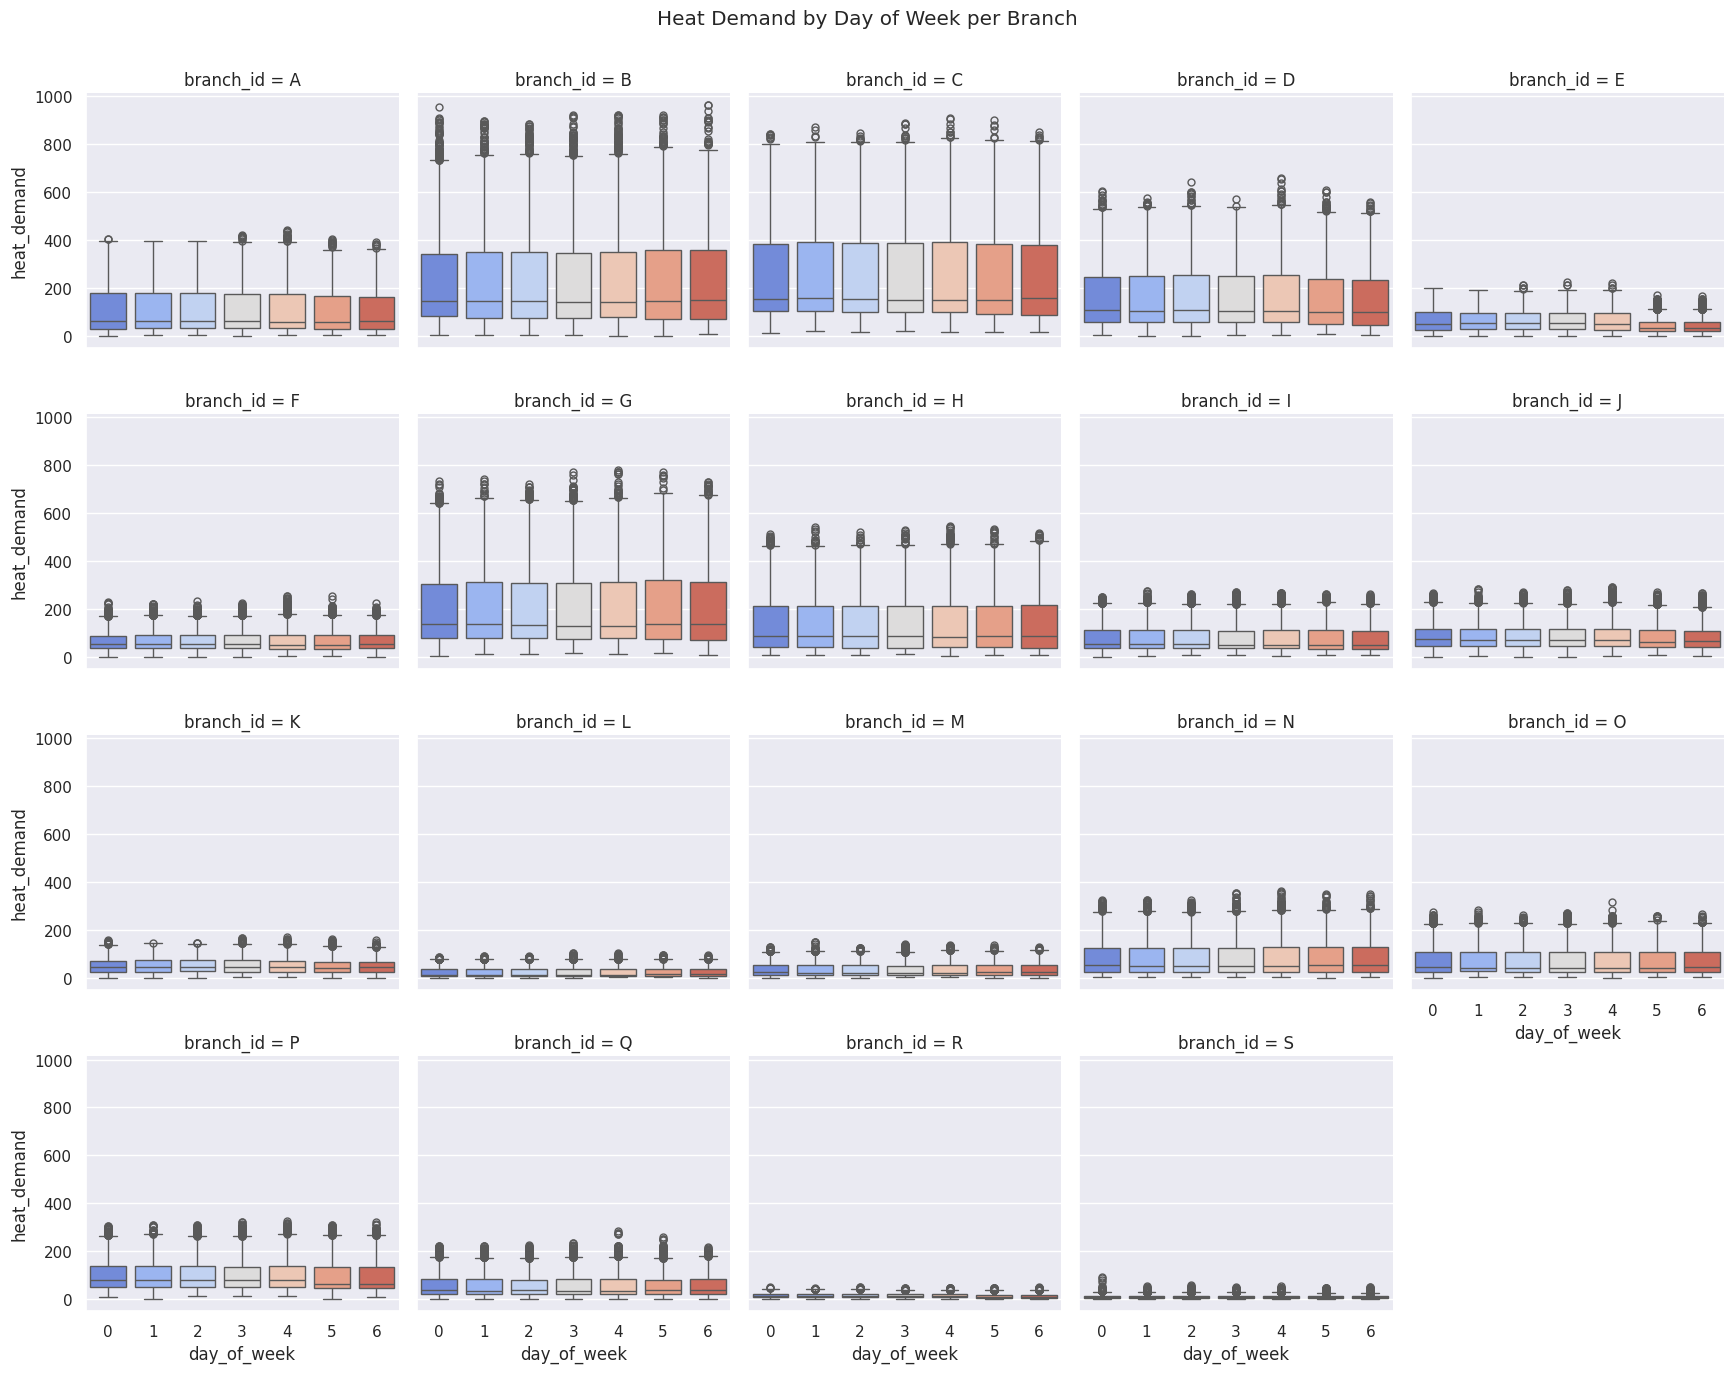

In [ ]:
g = sns.catplot(
    data=df_train, kind='box',
    x='day_of_week', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='coolwarm'
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Day of Week per Branch')


=> 이것도 필요 없어보임

* 지사별 주말여부	x 열수요

Text(0.5, 0.98, 'Heat Demand by Day of Week per Branch')

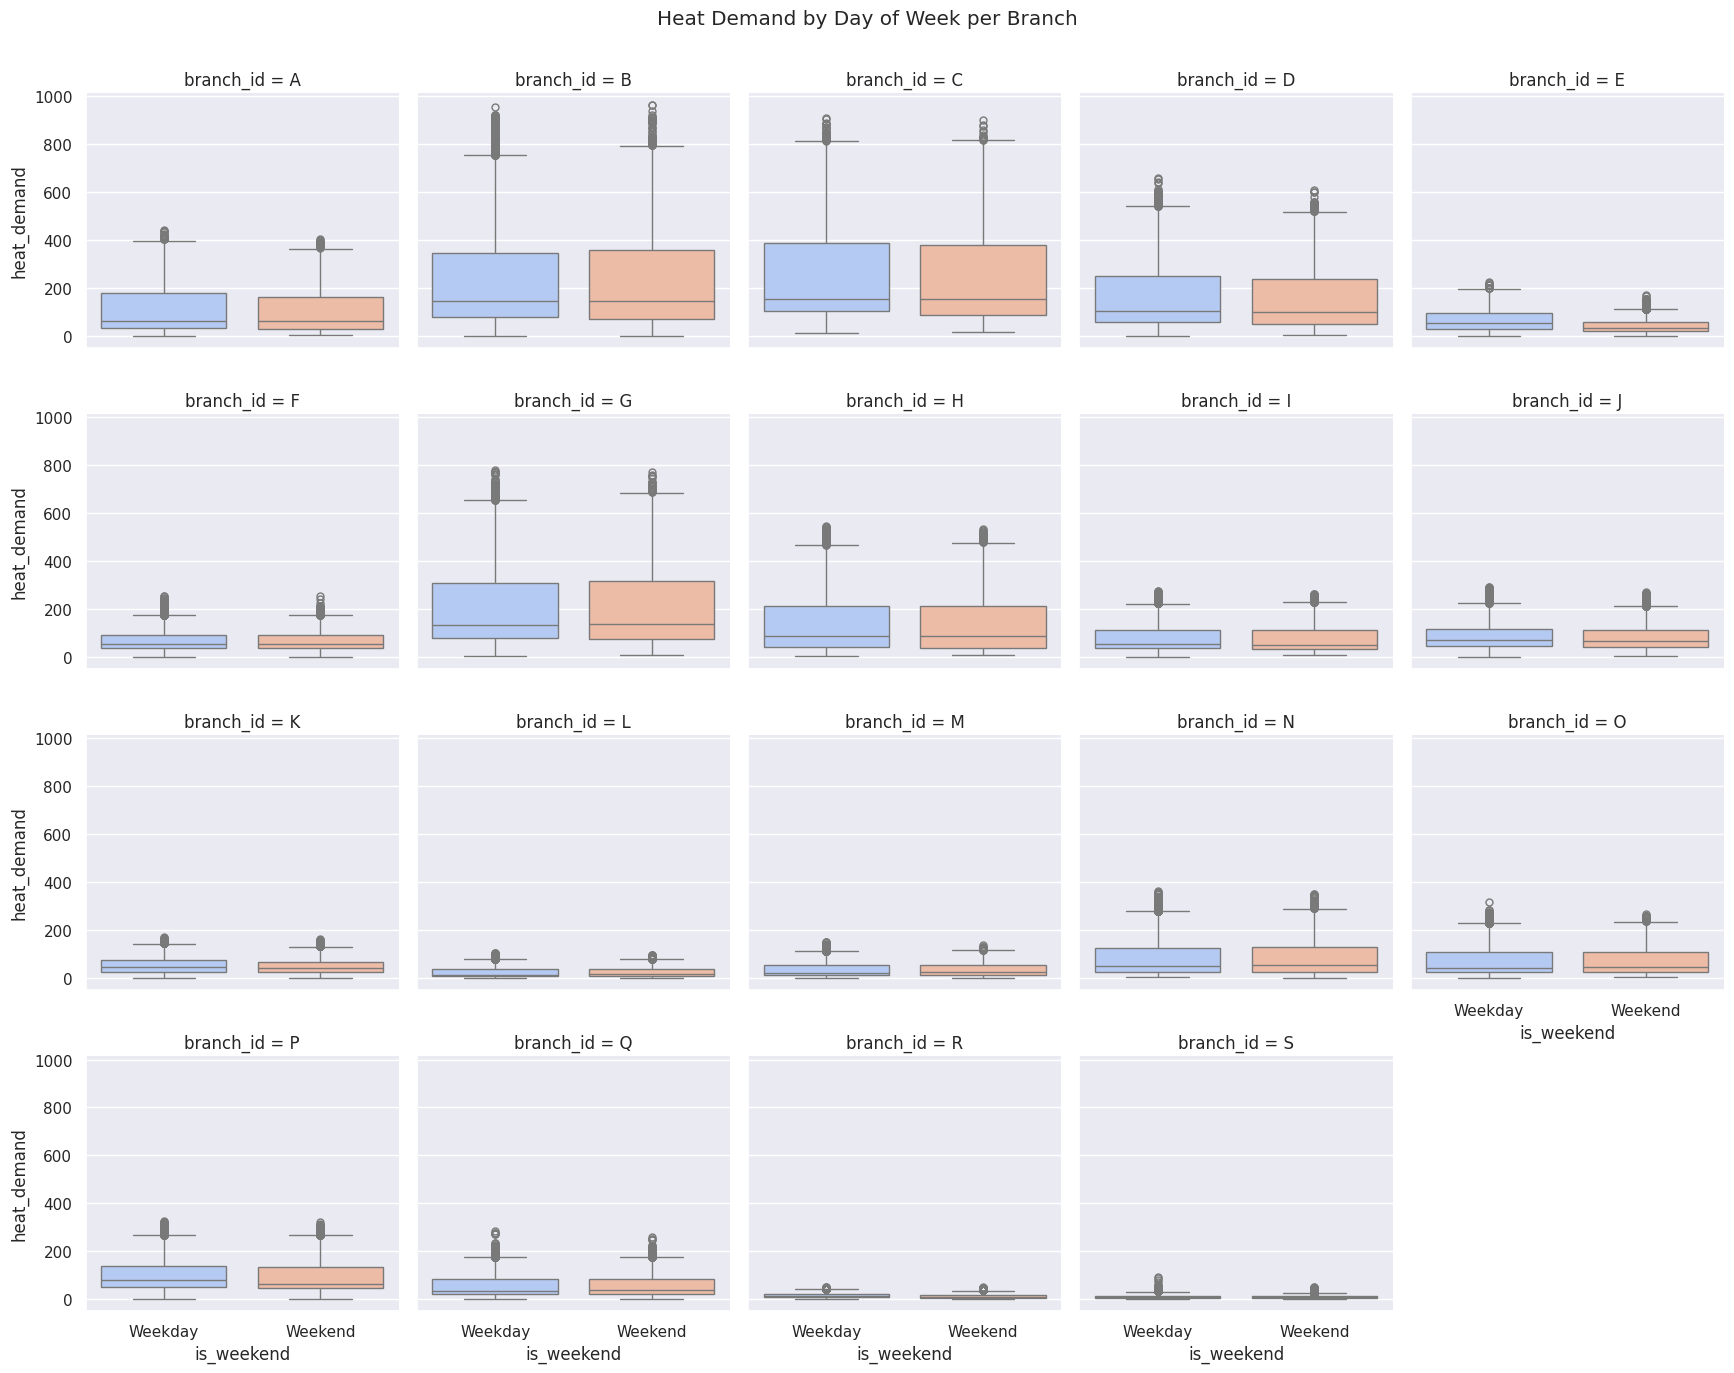

In [ ]:
g = sns.catplot(
    data=df_train, kind='box',
    x='is_weekend', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='coolwarm'
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Day of Week per Branch')


=> 이건 필요 없을듯

* 시간 (3시간 단위) x 지사별 열수요

Text(0.5, 0.98, 'Heat Demand by Hour Group per Branch')

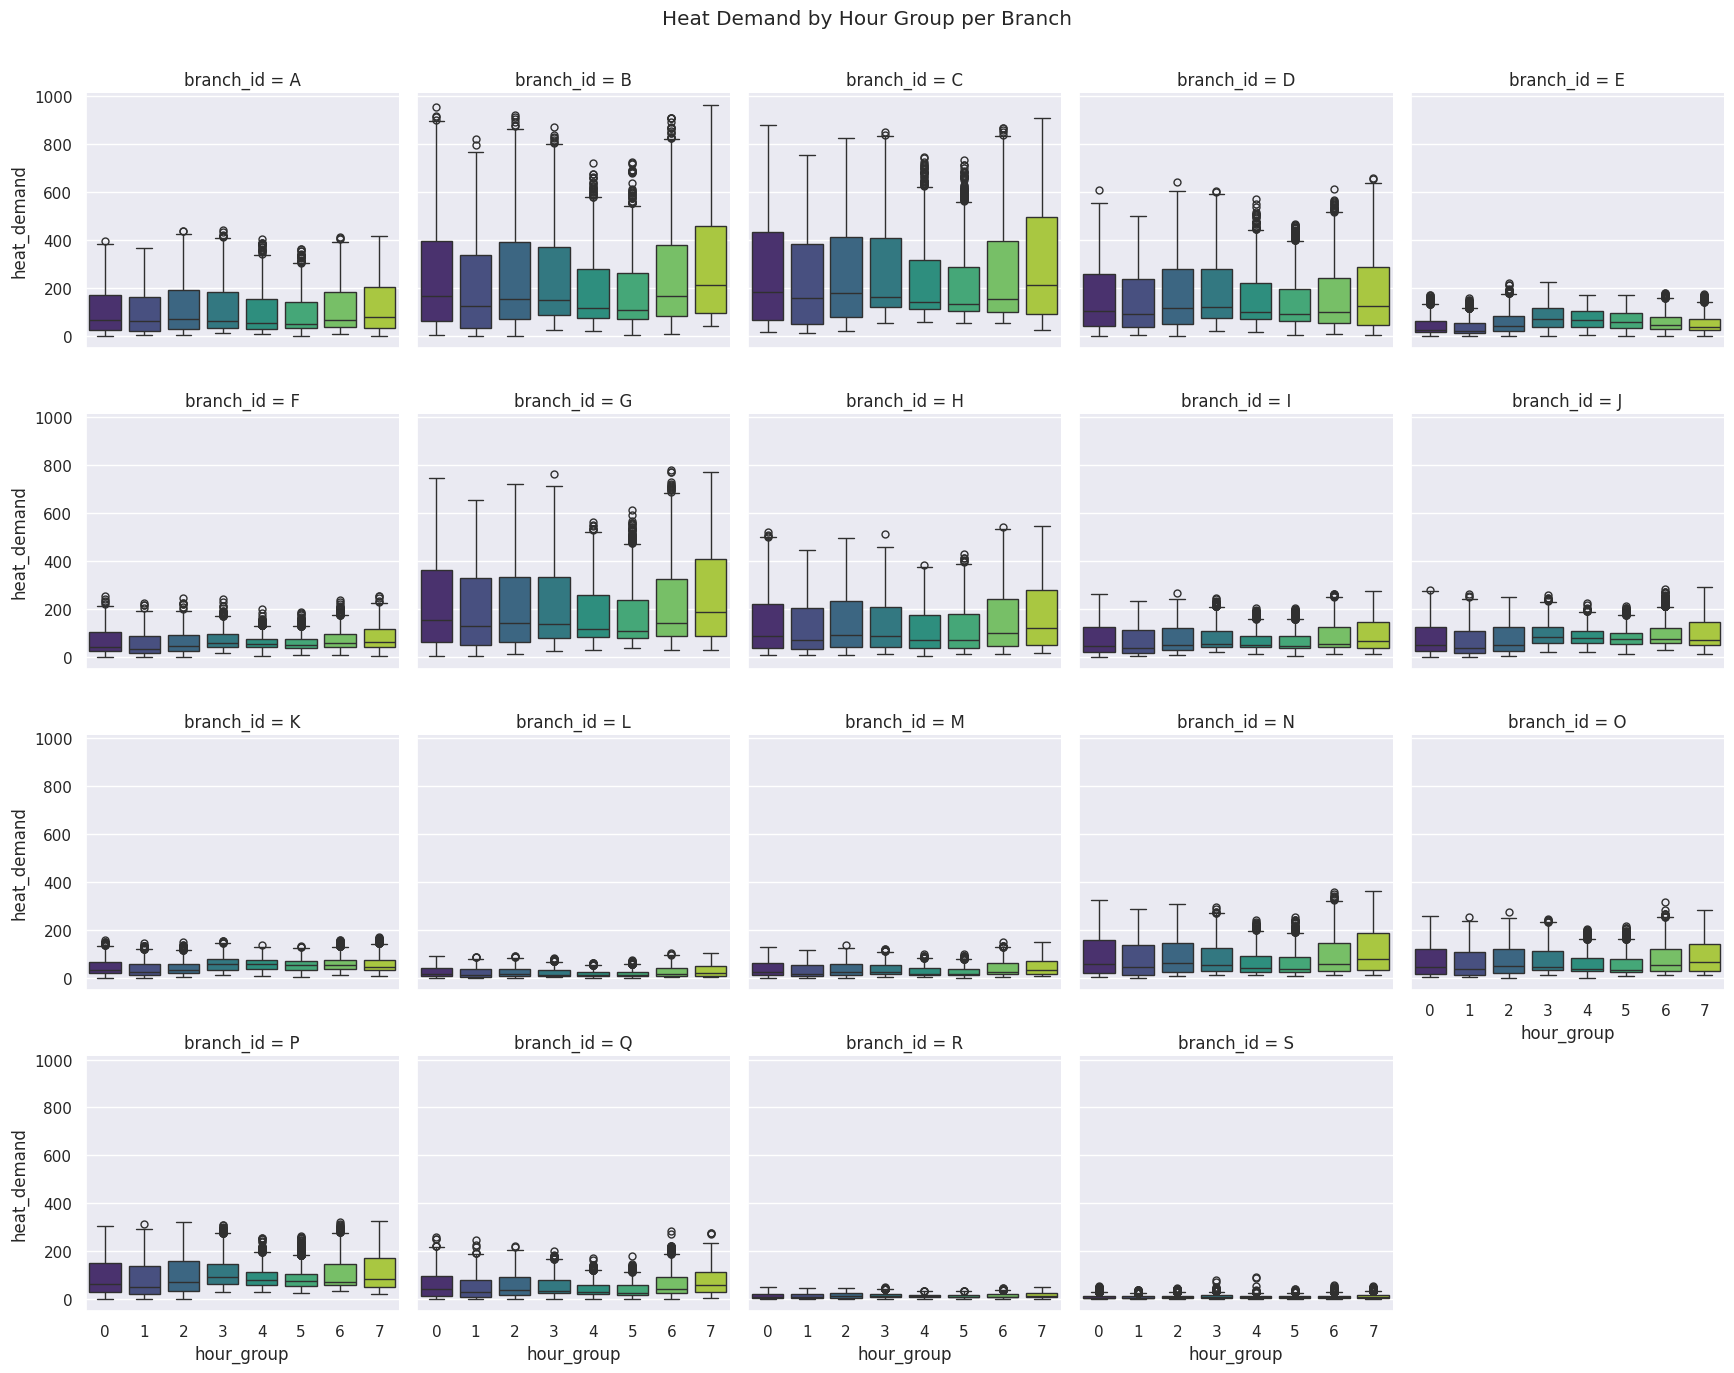

In [ ]:
g = sns.catplot(
    data=df_train, kind='box',
    x='hour_group', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='viridis'
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Hour Group per Branch')


* 계절 x 지사별 열수요

Text(0.5, 0.98, 'Heat Demand by Season per Branch')

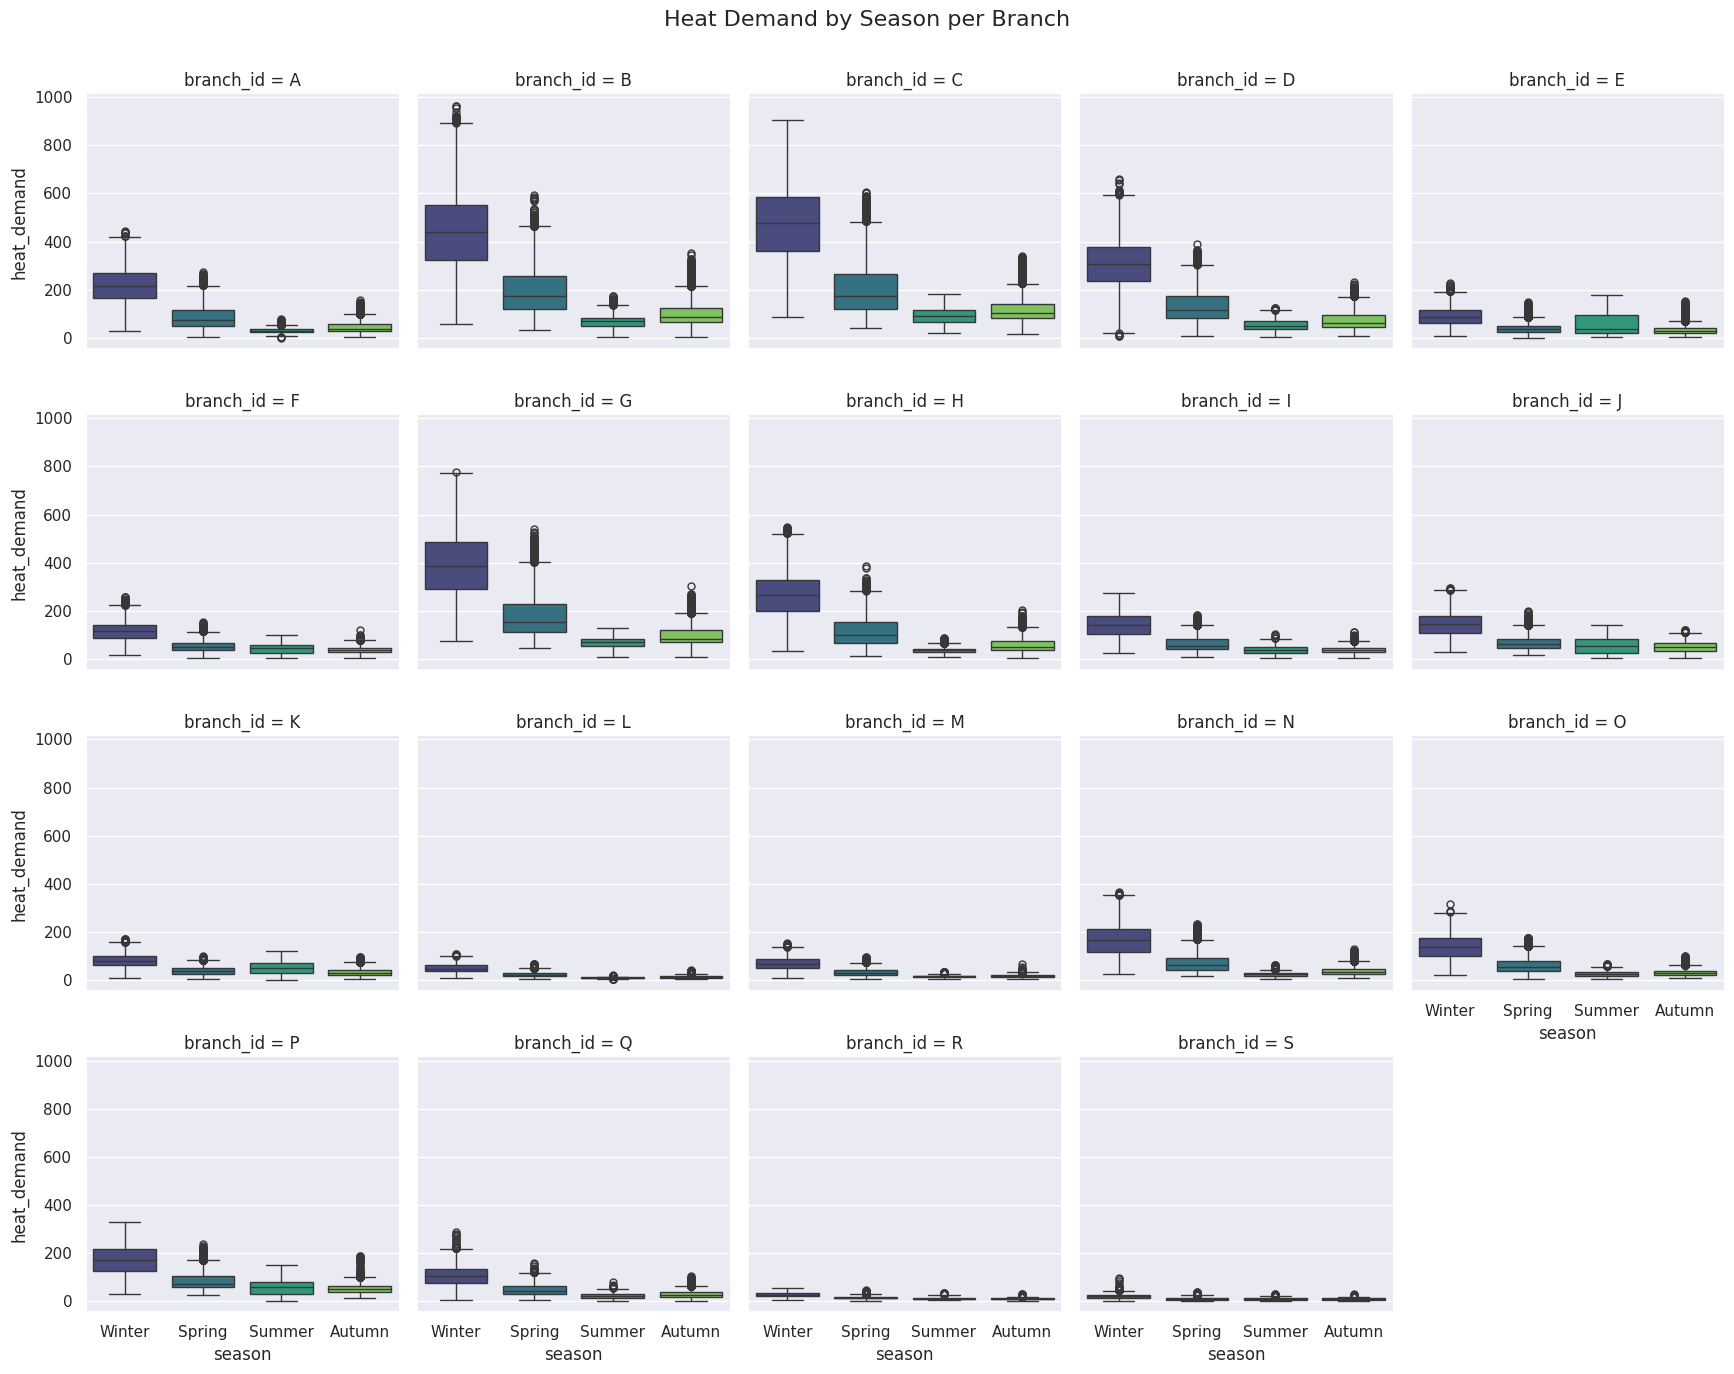

In [ ]:
# 계절 순서 명시 (선택사항: 기존에 설정 안 되어 있다면)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# 시각화
g = sns.catplot(
    data=df_train, kind='box',
    x='season', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='viridis',
    order=season_order  # x축 계절 순서 지정
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Season per Branch', fontsize=16)

* 월별 x 지사별 열 수요

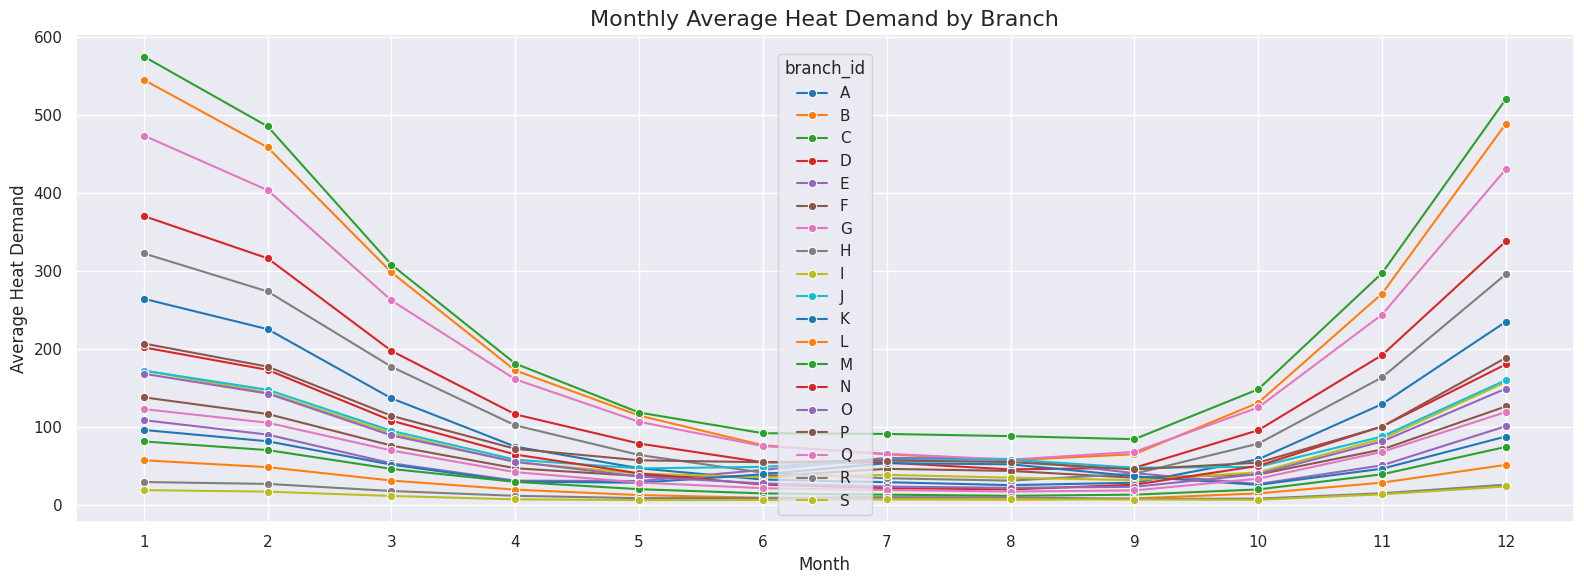

In [ ]:
# 월별 평균 열수요 계산
monthly_branch_avg = df_train.groupby(['month', 'branch_id'])['heat_demand'].mean().reset_index()

# 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_branch_avg, x='month', y='heat_demand', hue='branch_id', marker='o', palette='tab10')
plt.title('Monthly Average Heat Demand by Branch', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Heat Demand')
plt.xticks(ticks=range(1, 13))  # 1~12월 표시
plt.grid(True)
plt.tight_layout()
plt.show()


### **2-2) clustering**

[접근 방식 요약]

목표 : branch_id별 열수요의 시간대별 패턴 및 기상 변수의 시간대별 패턴을 바탕으로 지점 유형 군집화를 수행

(1) 기상 패턴 기반 군집화
* branch_id별로 계절x시간대에 따른 기상 변수의 중앙값 패턴을 추출
* -> 기상 조건에 따른 반응 특성을 중심으로 군집화

(2) 열수요 패턴 기반 군집화
* branch_id별로 열수요의 1시간 단위/3시간 단위/월별/계절별 중앙값 패턴 추출
* -> 시간에 따른 열수요 패턴의 유사성을 중심으로 군집화

(3) 기상 + 열수요 통합 군집화
* branch_id별로 기상 변수 + 열수요 변수의 시간, 계절, 월별 중앙값 패턴을 통합하여 사용


[과정]
1. 중앙값 패턴 추출
    * 그룹 기준 : branch_id x 시간 변수(hour, hour_group, month, season)
    * 대상 변수 : 기상 : (ta, hm, ws, si, ta_chi 등), 열수요 (heat_demand)
    * 방법: .groupby().median().pivot()을 활용한 wide-format 생성

2. wide-format 데이터프레임 구성
    * branch_id를 index로,시간/계절/월 단위의 패턴을 열(columns)로 구성
    * → ex) hour0, hour1, ..., month1, ..., season_Winter

3. 표준화 여부

  (1) 행 단위 변수별 표준화 (row-wise scaling)
    * 각 branch_id 행 내에서 변수 그룹별로 표준정규화
    * 패턴 중심의 군집화
    * -> 절대량이 아닌 시간의 흐름에 따른 모양(패턴)의 유사성으로 군집화하기 위함
    * 예를 들어, A건물 (100, 150,200) B건물 (20,30,40)일 때 절대량을 무시하고 [-1,0,1]처럼 정규화 진행. 이는상대적인 시간 변화 양상을 중심으로 클러스터링한 것. 평균이 다르더라도 오름세/내림세/변화 위치가 같으면 같은 군집이 가능

  (2) 행 단위 변수별 표준화를 진행하지 않음
    * 절대적인 열수요의 양과 차이를 반영하기 위해서 표준화를 진행하지 않음
    * 예를 들어, A건물 (100, 150,200) B건물 (20,30,40)일 때, 절대량을 고려하기 때문에 고수요/저수요로 나뉘게 됨

4. 시각화
    *-> 시각화를 통해 각 브랜치가 경향을 가지는지 확인*

#### **(1) branch_id별로 계절+시간대에 따른 기상 변수의 중앙값 패턴을 추출하여, 행동 패턴 기반으로 건물을 군집화**


=> 시도해봤는데, 지점별로 기상변수의 차이가 크지 않아서, clustering을 해도 유의미한 차이가 나타나지 않음.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           479594 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  int64         
 11  year         499278 non-null  int64         
 12  quarter      499278 non-null  int64         
 13  month        499278 non-null  int64         
 14  day_of_week  499278 non-null  int64         
 15  season       499278 non-null  obje

In [ ]:
# 1. 중앙값 계산: branch_id, season, hour_group 단위로 그룹핑 후에 각 기상변수들의 중앙값 계산
## 이때, 변수는 ta, ws, hm, si, ta_chi만 사용
weather_vars = ['ta', 'ws',  'hm', 'si', 'ta_chi']
agg = df_train.groupby(['branch_id', 'season', 'hour_group'])[weather_vars].median().reset_index()

# 2. Pivot: branch_id가 index, 컬럼은 (변수, season, hour_group)
pivot = agg.pivot(index='branch_id', columns=['season', 'hour_group'])

# 3. 컬럼 이름 변환: (ta, summer, 0) → ta_summer_hour0
pivot.columns = [f"{var}_{season}_hour{hour}" for var, season, hour in pivot.columns]
pivot.reset_index(inplace=True)
pivot

branch_id  ta_Autumn_hour0  ta_Autumn_hour1  ta_Autumn_hour2  \
0          A            16.80            16.40            16.45   
1          B            17.10            16.30            16.10   
2          C            17.80            17.10            17.40   
3          D            16.40            15.60            15.50   
4          E            16.40            15.60            15.50   
5          F            14.20            13.40            13.60   
6          G            16.60            16.00            16.55   
7          H            16.60            16.00            16.55   
8          I            16.80            16.10            16.10   
9          J            16.60            15.70            16.30   
10         K            17.70            16.90            17.00   
11         L            19.10            18.20            18.05   
12         M            19.20            18.00            18.40   
13         N            17.50            16.30            16.85   
14         O            18.30            17.10            16.75   
15         P            16.90            15.90            16.25   
16         Q            15.60            14.85            15.10   
17         R            16.95            16.00            16.30   
18         S            17.60            16.60            16.80   

    ta_Autumn_hour3  ta_Autumn_hour4  ta_Autumn_hour5  ta_Autumn_hour6  \
0             19.60             21.9            21.50             18.6   
1             19.90             22.5            22.70             20.1   
2             20.70             23.3            23.50             20.7   
3             19.70             21.7            22.05             19.4   
4             19.70             21.7            22.05             19.4   
5             19.00             21.9            21.50             17.4   
6             20.30             22.6            22.60             19.8   
7             20.30             22.6            22.60             19.8   
8             19.05             21.5            21.90             19.7   
9             20.30             22.8            22.40             19.2   
10            19.80             22.1            22.10             20.3   
11            21.90             24.2            24.00             21.2   
12            22.55             24.5            24.20             21.5   
13            20.80             23.3            23.10             20.7   
14            19.90             22.9            23.50             21.7   
15            19.90             22.8            22.60             20.0   
16            19.60             22.4            22.80             19.2   
17            20.85             24.1            23.80             20.6   
18            20.45             22.8            22.90             20.4   

    ta_Autumn_hour7  ta_Spring_hour0  ...  ta_chi_Summer_hour6  \
0             17.50            10.50  ...                28.60   
1             18.00            10.30  ...                28.30   
2             19.05            11.50  ...                28.60   
3             17.80            11.75  ...                28.50   
4             17.80            11.80  ...                28.50   
5             15.25             9.10  ...                27.90   
6             17.70            10.20  ...                27.90   
7             17.70            10.20  ...                27.90   
8             18.20            10.20  ...                27.90   
9             17.40             9.30  ...                27.90   
10            18.90            11.05  ...                27.95   
11            19.90            12.20  ...                28.10   
12            19.90            11.90  ...                28.30   
13            18.90            12.60  ...                28.90   
14            19.70            12.60  ...                29.00   
15            17.80            10.90  ...                28.10   
16            16.90             9.20  ...                27

In [ ]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Columns: 161 entries, branch_id to ta_chi_Winter_hour7
dtypes: float64(160), object(1)
memory usage: 24.0+ KB


In [ ]:
pivot.columns

Index(['branch_id', 'ta_Autumn_hour0', 'ta_Autumn_hour1', 'ta_Autumn_hour2',
       'ta_Autumn_hour3', 'ta_Autumn_hour4', 'ta_Autumn_hour5',
       'ta_Autumn_hour6', 'ta_Autumn_hour7', 'ta_Spring_hour0',
       ...
       'ta_chi_Summer_hour6', 'ta_chi_Summer_hour7', 'ta_chi_Winter_hour0',
       'ta_chi_Winter_hour1', 'ta_chi_Winter_hour2', 'ta_chi_Winter_hour3',
       'ta_chi_Winter_hour4', 'ta_chi_Winter_hour5', 'ta_chi_Winter_hour6',
       'ta_chi_Winter_hour7'],
      dtype='object', length=161)

* 행 단위 변수별 표준화 (row-wise scaling) -> 절대량이 아닌 모양(패턴)의 유사성으로 군집화하기 위함

In [ ]:
# 계절과 변수 리스트
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
variables = ['ta', 'wd', 'ws', 'hm', 'si', 'ta_chi'] # 'rn_day', 'rn_hr1'는 0 또는 너무 작으므로 우선 제외 ..

# pivot: 계절+변수 기준으로 정규화
for i in range(len(pivot)):
    for var in variables:
        for season in seasons:
            # ex) ta_Winter_hour0 ~ ta_Winter_hour7
            cols = [f"{var}_{season}_hour{h}" for h in range(8) if f"{var}_{season}_hour{h}" in pivot.columns]
            if cols:
                mean = pivot.loc[i, cols].mean()
                std = pivot.loc[i, cols].std()
                pivot.loc[i, cols] = (pivot.loc[i, cols] - mean) / std if std != 0 else 0

In [ ]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Columns: 161 entries, branch_id to ta_chi_Winter_hour7
dtypes: float64(160), object(1)
memory usage: 24.0+ KB


* 그래프로 확인

In [ ]:
pivot.loc[:,['ta_Winter_hour0', 'ta_Winter_hour1']]

ta_Winter_hour0  ta_Winter_hour1
0         -0.688834        -1.014187
1         -0.694331        -1.100769
2         -0.666961        -1.074548
3         -0.631982        -1.045472
4         -0.631982        -1.045472
5         -0.718517        -0.983816
6         -0.693753        -1.136392
7         -0.693753        -1.136392
8         -0.682446        -1.058968
9         -0.719890        -1.029520
10        -0.600860        -1.028138
11        -0.638607        -1.007114
12        -0.749411        -1.036267
13        -0.622175        -1.080620
14        -0.605872        -1.016001
15        -0.711983        -0.985658
16        -0.716210        -1.039422
17        -0.782864        -0.979900
18        -0.704714        -1.040292

In [ ]:
import matplotlib.pyplot as plt

def plot_columns(df, columns, title=None, figsize=(12, 3), alpha=0.5, linewidth=0.7):
    """
    df: 데이터프레임
    columns: 보고 싶은 column 이름 리스트
    title: 그래프 제목
    """
    plt.figure(figsize=figsize)
    for i in range(len(df)):
        plt.plot(range(len(columns)), df.loc[i, columns], alpha=alpha, linewidth=linewidth)

    plt.xticks(range(len(columns)), columns, rotation=45)
    plt.grid(True)
    if title:
        plt.title(title)
    else:
        plt.title("Selected Feature Time Series per Row")
    plt.tight_layout()
    plt.show()


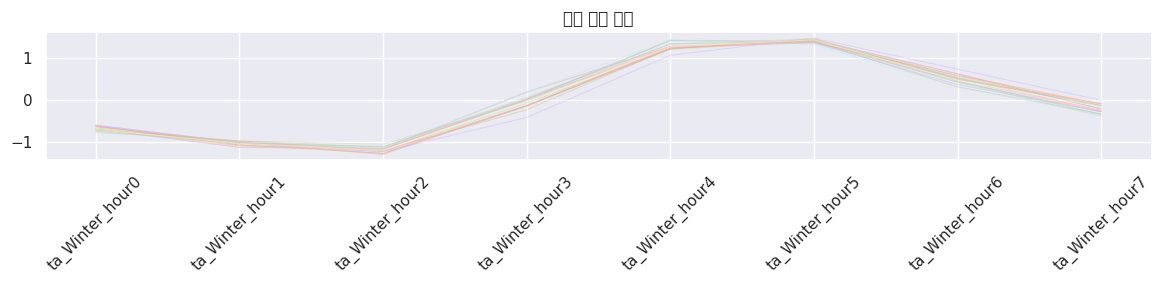

In [ ]:
cols = [f'ta_Winter_hour{i}' for i in range(8)]
plot_columns(pivot, cols, title="겨울 기온 패턴")

* 군집화

In [ ]:
from sklearn.cluster import KMeans

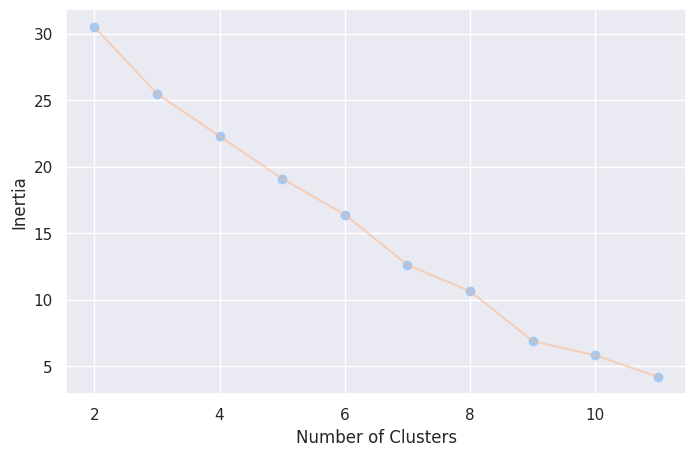

In [ ]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], pivot.iloc[:,1:])

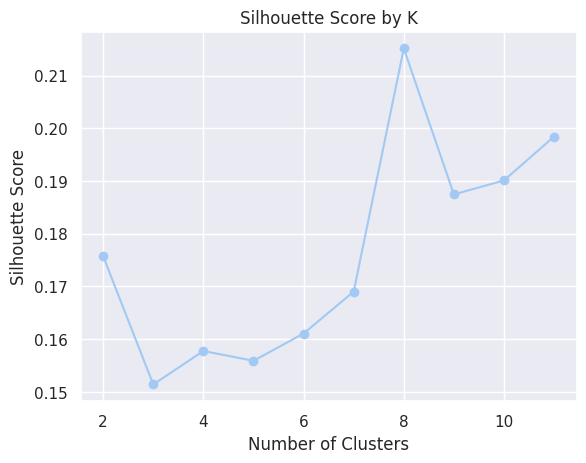

In [ ]:
X = pivot.iloc[:, 1:]  # branch_id 제외하고 수치 변수만

scores = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

# 시각화
plt.plot(range(2, 12), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.grid(True)
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=8, random_state = 0)
km_cluster = kmeans.fit_predict(pivot.iloc[:,1:])

In [ ]:
df_clust = pivot.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

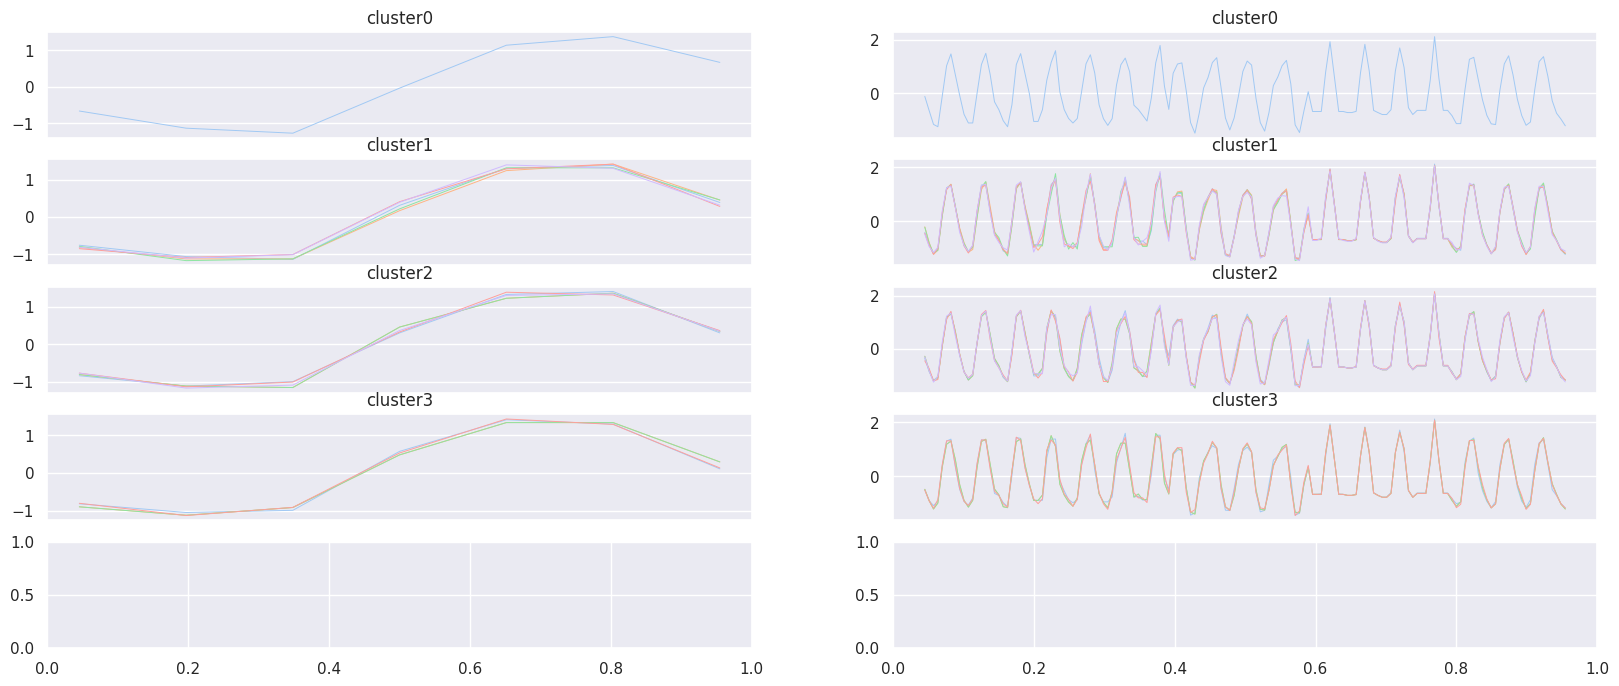

In [ ]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster))

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [ ]:
df_train_cluster = df_train.merge(df_clust[['branch_id','km_cluster']], on = 'branch_id', how = 'left')

In [ ]:
df_train_cluster

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  \
0      2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2   
1      2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9   
2      2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2   
3      2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0   
4      2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5   
...                    ...       ...   ...    ...  ...     ...     ...   ...   
499273 2023-12-31 19:00:00         S   3.2  233.5  0.4     2.5     0.0  91.5   
499274 2023-12-31 20:00:00         S   2.9  227.4  0.1     2.5     0.0  92.1   
499275 2023-12-31 21:00:00         S   2.1  360.0  0.0     2.5     0.0  93.3   
499276 2023-12-31 22:00:00         S   2.2   30.0  1.4     2.5     0.0  95.5   
499277 2023-12-31 23:00:00         S   1.2  359.0  0.8     2.5     0.0  94.9   

        si  ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
0      NaN    -8.2        281.0  2021        1      1            4  Winter   
1      NaN    -8.6        262.0  2021        1      1            4  Winter   
2      NaN    -8.8        266.0  2021        1      1            4  Winter   
3      NaN    -8.9        285.0  2021        1      1            4  Winter   
4      NaN    -9.2        283.0  2021        1      1            4  Winter   
...     ..     ...          ...   ...      ...    ...          ...     ...   
499273 NaN     2.8         34.0  2023        4     12            6  Winter   
499274 NaN     2.7         35.0  2023        4     12            6  Winter   
499275 NaN     1.4         35.0  2023        4     12            6  Winter   
499276 NaN     1.3         40.0  2023        4     12            6  Winter   
499277 NaN     0.6         33.0  2023        4     12            6  Winter   

       is_weekend  weekofyear  hour_group  km_cluster  
0         Weekday          53           0           2  
1         Weekday          53           0           2  
2         Weekday          53           1           2  
3         Weekday          53           1           2  
4         Weekday          53           1           2  
...           ...         ...         ...         ...  
499273    Weekend          52           6           0  
499274    Weekend          52           6           0  
499275    Weekend          52           7           0  
499276    Weekend          52           7           0  
499277    Weekend          52           7           0  

[499278 rows x 20 columns]

In [ ]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = df_train_cluster[df_train_cluster.km_cluster == c]
    temp = temp.groupby(['hour_group', 'season'])['heat_demand'].median().reset_index().pivot('hour_group', 'season', 'heat_demand')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

#### **(2) branch_id별로 열 수요량의 시간대/3시간 단위/계절/월의 중앙값 패턴을 추출하여, 행동 패턴 기반으로 건물을 군집화**

##### 1. 중앙값 패턴 추출

In [ ]:
df_train['hour'] = df_train['tm'].dt.hour

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           479594 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  int64         
 11  year         499278 non-null  int64         
 12  quarter      499278 non-null  int64         
 13  month        499278 non-null  int64         
 14  day_of_week  499278 non-null  int64         
 15  season       499278 non-null  obje

In [ ]:
# 시간 단위별 중앙값 (1시간 단위)
by_hour = df_train.groupby(['branch_id', 'hour'])['heat_demand'].median().reset_index()
by_hour = by_hour.pivot(index='branch_id', columns='hour', values='heat_demand').reset_index()
by_hour.columns = ['branch_id'] + [f'hour{h}' for h in range(24)]

# 3시간 단위
by_hour3 = df_train.groupby(['branch_id', 'hour_group'])['heat_demand'].median().reset_index()
by_hour3 = by_hour3.pivot(index='branch_id', columns='hour_group', values='heat_demand').reset_index()
by_hour3.columns = ['branch_id'] + [f'hour3_{h}' for h in sorted(df_train['hour_group'].unique())]

# 월 단위
by_month = df_train.groupby(['branch_id', 'month'])['heat_demand'].median().reset_index()
by_month = by_month.pivot(index='branch_id', columns='month', values='heat_demand').reset_index()
by_month.columns = ['branch_id'] + [f'month{m}' for m in range(1,13)]

# 계절 단위
by_season = df_train.groupby(['branch_id', 'season'])['heat_demand'].median().reset_index()
by_season = by_season.pivot(index='branch_id', columns='season', values='heat_demand').reset_index()
by_season.columns = ['branch_id'] + [f'season_{s}' for s in df_train['season'].unique()]

In [ ]:
# 모든 시간 기준 패턴 데이터 병합
df_pattern = by_hour.merge(by_hour3, on='branch_id') \
                    .merge(by_month, on='branch_id') \
                    .merge(by_season, on='branch_id')

In [ ]:
df_pattern

branch_id  hour0  hour1  hour2  hour3  hour4  hour5  hour6  hour7  hour8  \
0          A   75.0   67.0   63.0   60.0   61.0   68.0   73.0   73.0   75.0   
1          B  189.0  164.0  143.0  127.0  123.0  124.0  133.0  157.0  179.0   
2          C  205.5  178.0  169.0  161.0  155.0  157.0  161.0  180.0  190.0   
3          D  114.0  103.0   95.0   91.0   90.0   92.0  101.0  117.0  130.0   
4          E   31.0   26.0   23.0   22.0   21.0   22.0   27.0   42.0   62.0   
5          F   50.0   45.0   39.0   36.0   34.0   34.0   36.0   46.0   53.0   
6          G  169.0  149.0  140.0  132.0  129.0  127.0  129.0  142.0  163.0   
7          H  109.5   88.0   77.0   73.0   74.0   76.0   84.0   95.0  105.0   
8          I   56.0   45.0   42.0   40.0   39.0   38.0   41.0   52.0   62.0   
9          J   60.0   49.0   42.0   39.0   38.0   38.0   40.0   49.0   61.0   
10         K   36.0   32.0   29.0   26.0   25.0   25.5   27.0   33.0   41.0   
11         L   21.0   19.0   17.0   16.0   16.0   16.0   17.0   18.0   21.0   
12         M   28.0   25.0   22.0   21.0   20.0   19.0   22.0   27.0   33.0   
13         N   70.0   60.0   52.0   49.0   47.0   47.0   51.0   64.0   77.0   
14         O   55.0   46.0   41.0   38.0   37.0   38.0   40.0   49.0   65.0   
15         P   68.5   62.0   55.0   52.0   51.0   52.0   55.0   67.0   91.0   
16         Q   50.0   43.0   35.0   32.0   29.0   30.0   32.0   40.0   49.0   
17         R   12.0   11.0   10.0    9.0    8.0    8.0    9.0   11.0   16.0   
18         S    8.0    7.0    7.0    6.0    6.0    6.0    7.0    8.0   11.0   

    ...  month7  month8  month9  month10  month11  month12  season_Winter  \
0   ...    29.0    26.0    29.0     54.0    124.0    231.0           34.0   
1   ...    69.0    61.0    67.0    121.0    258.0    480.0           84.0   
2   ...    90.0    87.0    88.0    132.5    287.0    518.0          103.0   
3   ...    52.0    42.0    46.0     91.0    182.0    331.0           62.0   
4   ...    39.0    39.0    26.0     26.0     46.0     98.0           26.0   
5   ...    51.0    45.0    36.0     38.0     68.0    123.0           37.0   
6   ...    69.0    60.0    70.0    116.0    233.0    422.0           83.0   
7   ...    33.0    30.0    39.0     73.0    156.5    290.0           49.0   
8   ...    40.0    36.0    32.0     38.0     81.0    156.0           35.0   
9   ...    56.5    59.0    49.0     49.0     83.0    156.0           49.0   
10  ...    55.0    51.0    34.0     25.0     45.0     86.0           27.0   
11  ...     8.0     7.0     8.0     13.0     28.0     51.0           10.0   
12  ...    13.0    12.0    13.0     19.0     37.0     73.0           15.0   
13  ...    22.0    21.0    26.0     45.0     98.0    179.0           32.0   
14  ...    25.0    23.0    24.0     35.0     79.0    148.0           28.0   
15  ...    55.0    51.0    44.0     50.0     97.0    187.0           48.0   
16  ...    20.0    17.0    19.0     30.0     65.0    115.0           23.0   
17  ...     8.0     7.0     7.0      8.0     15.0     26.0            8.0   
18  ...     6.0     6.0     7.0      7.0     13.0     23.0            7.0   

    season_Spring  season_Summer  season_Autumn  
0            72.0           29.0          216.0  
1           172.0           68.0          438.0  
2           171.0           91.0          477.0  
3           115.0           49.0          307.0  
4            34.0           35.0           86.0  
5            48.0           43.0          113.0  
6           153.5           69.0          385.0  
7            98.0           35.0          266.0  
8            54.0           37.0          141.0  
9            61.0           54.0          143.0  
10           34.0           47.0           79.0  
11           19.0            8.0           46.0  
12           29.0           13.0           67.0  
13           61.0           23.0          163.0  
14           53.0           25.0          137.0  
15           71.0           55.0          171.0  
16           41.0           20.

In [ ]:
df_pattern.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   branch_id      19 non-null     object 
 1   hour0          19 non-null     float64
 2   hour1          19 non-null     float64
 3   hour2          19 non-null     float64
 4   hour3          19 non-null     float64
 5   hour4          19 non-null     float64
 6   hour5          19 non-null     float64
 7   hour6          19 non-null     float64
 8   hour7          19 non-null     float64
 9   hour8          19 non-null     float64
 10  hour9          19 non-null     float64
 11  hour10         19 non-null     float64
 12  hour11         19 non-null     float64
 13  hour12         19 non-null     float64
 14  hour13         19 non-null     float64
 15  hour14         19 non-null     float64
 16  hour15         19 non-null     float64
 17  hour16         19 non-null     float64
 18  hour17      

In [ ]:
df_pattern.columns

Index(['branch_id', 'hour0', 'hour1', 'hour2', 'hour3', 'hour4', 'hour5',
       'hour6', 'hour7', 'hour8', 'hour9', 'hour10', 'hour11', 'hour12',
       'hour13', 'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19',
       'hour20', 'hour21', 'hour22', 'hour23', 'hour3_0', 'hour3_1', 'hour3_2',
       'hour3_3', 'hour3_4', 'hour3_5', 'hour3_6', 'hour3_7', 'month1',
       'month2', 'month3', 'month4', 'month5', 'month6', 'month7', 'month8',
       'month9', 'month10', 'month11', 'month12', 'season_Winter',
       'season_Spring', 'season_Summer', 'season_Autumn'],
      dtype='object')

##### 2-1. 행 단위 변수별 표준화 (row-wise scaling) -> 절대량이 아닌 모양(패턴)의 유사성으로 군집화하기 위함

In [ ]:
df_pattern_scaled = df_pattern.copy()

In [ ]:
# 정규화 대상 열 추출: branch_id 제외
feature_cols = [col for col in df_pattern_scaled.columns if col != 'branch_id']

# prefix 그룹핑
from collections import defaultdict

grouped_cols = defaultdict(list)

for col in feature_cols:
    if col.startswith("hour3_"):
        grouped_cols["hour3"].append(col)
    elif col.startswith("hour"):
        grouped_cols["hour"].append(col)
    elif col.startswith("month"):
        grouped_cols["month"].append(col)
    elif col.startswith("season_"):
        grouped_cols["season"].append(col)

# row-wise 정규화 (각 row에서 각 그룹별로 Z-score scaling)
for i in range(len(df_pattern_scaled)):
    for group, cols in grouped_cols.items():
        mean = df_pattern_scaled.loc[i, cols].mean()
        std = df_pattern_scaled.loc[i, cols].std()
        if std != 0:
            df_pattern_scaled.loc[i, cols] = (df_pattern_scaled.loc[i, cols] - mean) / std
        else:
            df_pattern_scaled.loc[i, cols] = 0

In [ ]:
df_pattern_scaled

branch_id     hour0     hour1     hour2     hour3     hour4     hour5  \
0          A  0.927862  0.143062 -0.249337 -0.543637 -0.445537  0.241162   
1          B  1.017543  0.328462 -0.250366 -0.691378 -0.801631 -0.774068   
2          C  1.366450  0.360474  0.031246 -0.261401 -0.480887 -0.407725   
3          D  0.483114 -0.262746 -0.805190 -1.076412 -1.144218 -1.008607   
4          E -0.885501 -1.158663 -1.322560 -1.377193 -1.431825 -1.377193   
5          F -0.161036 -0.683316 -1.310051 -1.623419 -1.832330 -1.832330   
6          G  1.042461  0.276180 -0.068646 -0.375158 -0.490100 -0.566728   
7          H  1.014259 -0.110032 -0.685251 -0.894422 -0.842129 -0.737544   
8          I  0.335570 -0.845637 -1.167784 -1.382549 -1.489931 -1.597314   
9          J -0.359925 -1.006322 -1.417665 -1.593955 -1.652719 -1.652719   
10         K -0.723500 -1.035662 -1.269783 -1.503905 -1.581945 -1.542925   
11         L  1.019582  0.509791  0.000000 -0.254896 -0.254896 -0.254896   
12         M  0.503488 -0.014385 -0.532259 -0.704883 -0.877507 -1.050132   
13         N  0.931053  0.214858 -0.358097 -0.572956 -0.716195 -0.716195   
14         O  0.646490 -0.125012 -0.553624 -0.810792 -0.896514 -0.810792   
15         P -0.429003 -0.895376 -1.397624 -1.612873 -1.684623 -1.612873   
16         Q  0.921219  0.307073 -0.394808 -0.658014 -0.921219 -0.833484   
17         R -0.035348 -0.459520 -0.883691 -1.307863 -1.732035 -1.732035   
18         S -0.664910 -1.215181 -1.215181 -1.765451 -1.765451 -1.765451   

       hour6     hour7     hour8  ...    month7    month8    month9   month10  \
0   0.731662  0.731662  0.927862  ... -0.860573 -0.894692 -0.860573 -0.576243   
1  -0.525998  0.135519  0.741910  ... -0.872680 -0.918051 -0.884023 -0.577770   
2  -0.261401  0.433636  0.799445  ... -0.840290 -0.856628 -0.851182 -0.608830   
3  -0.398357  0.686531  1.568002  ... -0.854111 -0.937237 -0.903986 -0.529923   
4  -1.104031 -0.284544  0.808105  ... -0.377714 -0.377714 -0.814183 -0.814183   
5  -1.623419 -0.578860  0.152331  ... -0.445790 -0.607487 -0.850033 -0.796134   
6  -0.490100  0.007982  0.812576  ... -0.879103 -0.938572 -0.872495 -0.568540   
7  -0.319203  0.256016  0.778942  ... -0.917205 -0.945057 -0.861499 -0.545835   
8  -1.275167 -0.093960  0.979865  ... -0.696629 -0.773322 -0.850015 -0.734975   
9  -1.535192 -1.006322 -0.301162  ... -0.601934 -0.548270 -0.762927 -0.762927   
10 -1.425864 -0.957621 -0.333298  ...  0.146401 -0.020914 -0.732003 -1.108461   
11  0.000000  0.254896  1.019582  ... -0.871917 -0.925850 -0.871917 -0.602252   
12 -0.532259  0.330863  1.366610  ... -0.865326 -0.903785 -0.865326 -0.634573   
13 -0.429717  0.501336  1.432389  ... -0.899725 -0.914415 -0.840968 -0.561869   
14 -0.639347  0.132155  1.503715  ... -0.842811 -0.879723 -0.861267 -0.658254   
15 -1.397624 -0.536628  1.185365  ... -0.689060 -0.754947 -0.870248 -0.771418   
16 -0.658014  0.043868  0.833484  ... -0.845665 -0.919918 -0.870416 -0.598153   
17 -1.307863 -0.459520  1.661340  ... -0.743616 -0.858756 -0.858756 -0.743616   
18 -1.215181 -0.664910  0.985901  ... -0.812381 -0.812381 -0.647151 -0.647151   

     month11   month12  season_Winter  season_Spring  season_Summer  \
0   0.219882  1.436815      -0.613378      -0.179734      -0.670437   
1   0.199206  1.458248      -0.622013      -0.108049      -0.715461   
2   0.232594  1.490646      -0.593512      -0.218081      -0.659765   
3   0.226516  1.465081      -0.597239      -0.152977      -0.706209   
4  -0.142692  1.603185      -0.700927      -0.409633      -0.373221   
5   0.012352  1.494576      -0.655797      -0.345528      -0.486559   
6   0.204564  1.453424      -0.612475      -0.130695      -0.708147   
7   0.229398  1.468843      -0.593442      -0.131876      -0.725319   
8   0.089475  1.527471      -0.632109      -0.253839      -0.592292   
9  -0.033093  1.533904      -0.624437      -0.354410      -0.511926   
10 -0.271887  1.443091      -0.857144      -0.553346       0.010850   
11  0.206

* 그래프로 확인

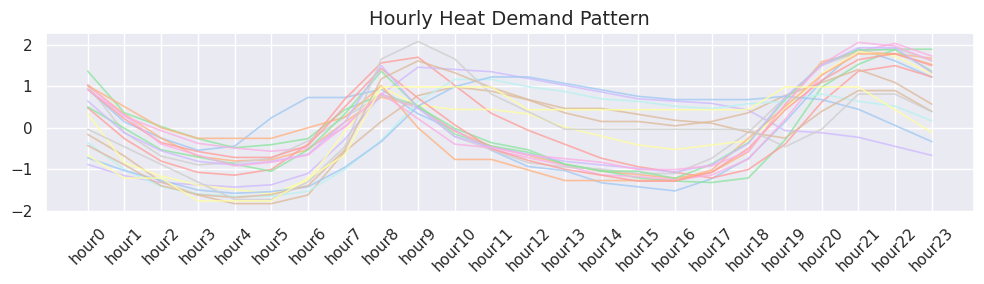

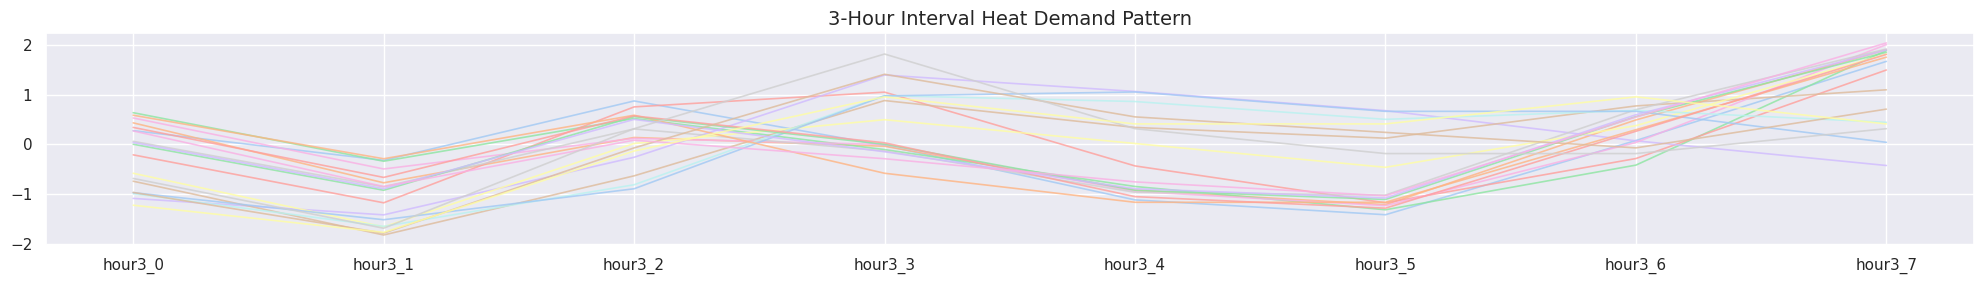

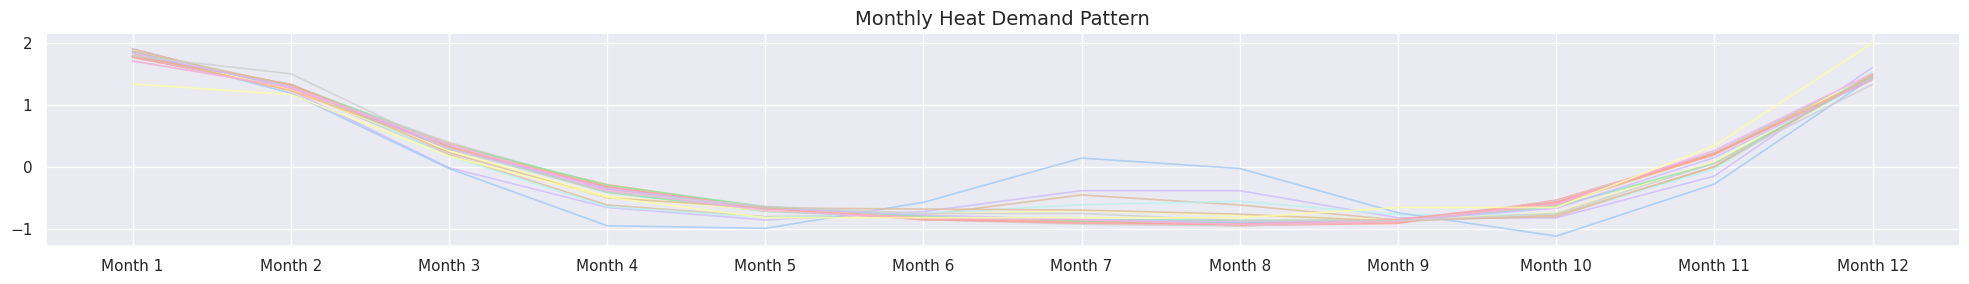

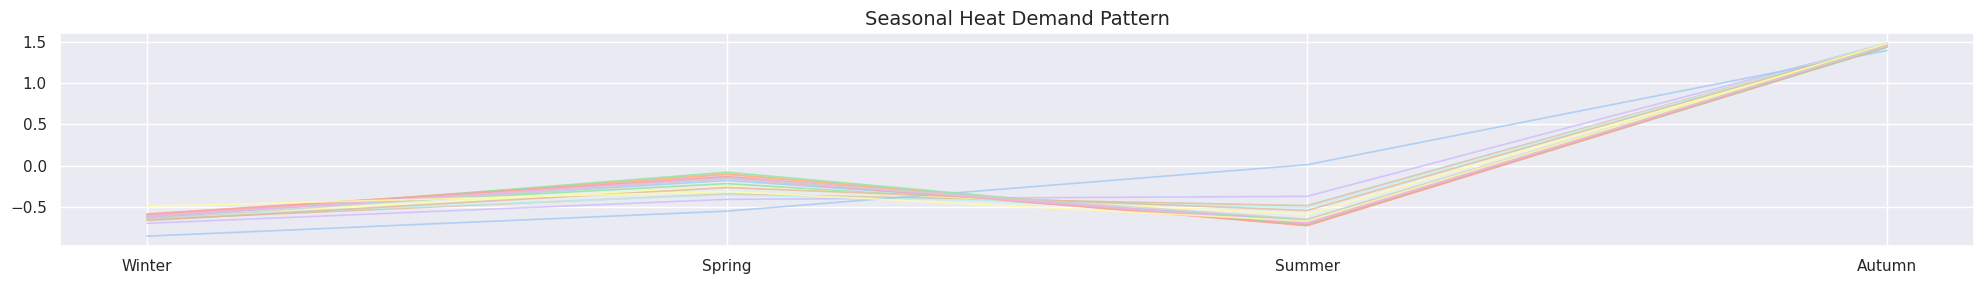

In [ ]:
# 1시간 단위 시각화 (hour0 ~ hour23)
fig = plt.figure(figsize=(10, 3))
for i in range(len(df_pattern_scaled)):
    plt.plot(df_pattern_scaled.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
plt.title("Hourly Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(24), labels=[f'hour{i}' for i in range(24)], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3시간 단위 시각화 (hour3_0 ~ hour3_7)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern_scaled)):
    plt.plot(df_pattern_scaled.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
plt.title("3-Hour Interval Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(8), labels=[f'hour3_{i}' for i in range(8)], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 월별 시각화 (month1 ~ month12 assumed at 33:44)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern_scaled)):
    plt.plot(df_pattern_scaled.iloc[i, 33:45], alpha=0.8, linewidth=1.2)
plt.title("Monthly Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(12), labels=[f'Month {i+1}' for i in range(12)], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 계절별 시각화 (season_Winter ~ season_Autumn assumed at 45:49)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern_scaled)):
    plt.plot(df_pattern_scaled.iloc[i, 45:49], alpha=0.8, linewidth=1.2)
plt.title("Seasonal Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(4), labels=["Winter", "Spring", "Summer", "Autumn"])
plt.grid(True)
plt.tight_layout()
plt.show()

* 군집화

In [ ]:
from sklearn.cluster import KMeans

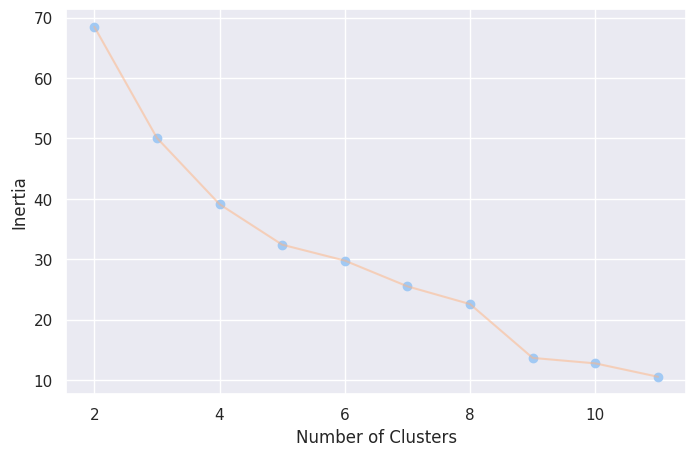

In [ ]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df_pattern_scaled.iloc[:,1:])

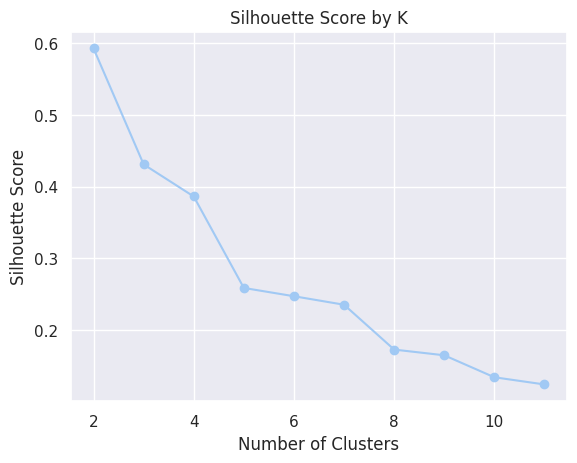

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pattern_scaled.iloc[:,1:])
    score = silhouette_score(df_pattern_scaled.iloc[:,1:], labels)
    scores.append(score)

# 시각화
plt.plot(range(2, 12), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.grid(True)
plt.show()

* 군집의 개수를 3으로

In [ ]:
kmeans3 = KMeans(n_clusters=3, random_state = 0)
km_cluster3 = kmeans3.fit_predict(df_pattern_scaled.iloc[:,1:])

In [ ]:
# 스케일된 그래프
df_clust_scaled_num3 = df_pattern_scaled.copy()
df_clust_scaled_num3['km_cluster'] = km_cluster

# 원본 그래프
df_clust_origin_num3 = df_pattern.copy()  # ✅ 원본 값 사용
df_clust_origin_num3['km_cluster'] = km_cluster

In [ ]:
# 클러스터별 포함 지점 리스트
for c in sorted(df_clust_origin_num3.km_cluster.unique()):
    members = df_clust_origin_num3[df_clust_origin_num3.km_cluster == c]['branch_id'].tolist()
    print(f'Cluster {c}: {members}')

Cluster 0: ['E', 'J', 'K']
Cluster 1: ['A', 'B', 'C', 'D', 'G', 'H', 'L', 'M', 'N', 'O', 'Q']
Cluster 2: ['F', 'I', 'P', 'R', 'S']


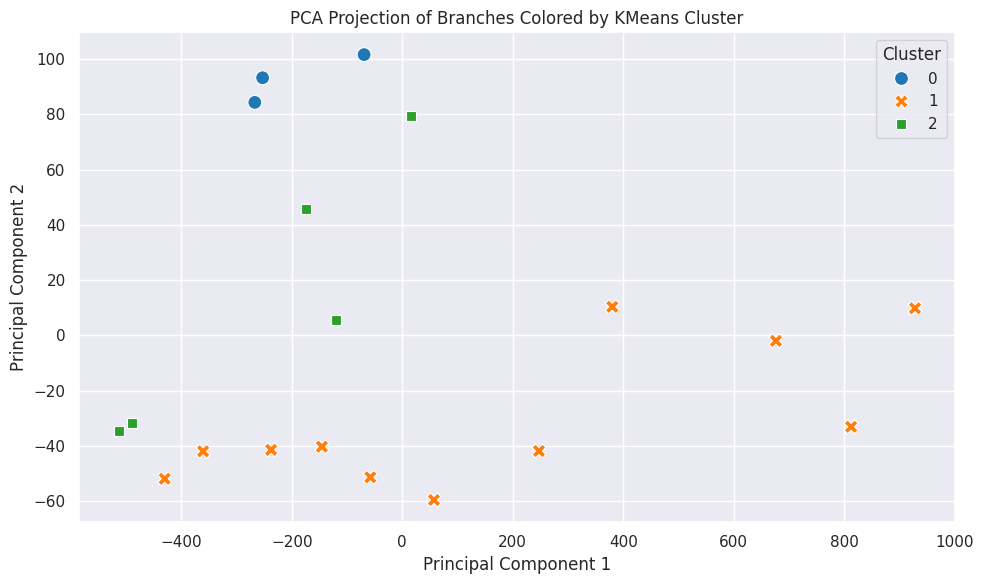

In [ ]:
# branch_id와 cluster 제외한 feature만 사용
X = df_pattern.iloc[:, 1:]

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 결과 DataFrame 생성
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = km_cluster3  # 위에서 예측한 결과 사용
pca_df['branch_id'] = df_pattern['branch_id'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', style='cluster', palette='tab10', s=100)
plt.title("PCA Projection of Branches Colored by KMeans Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


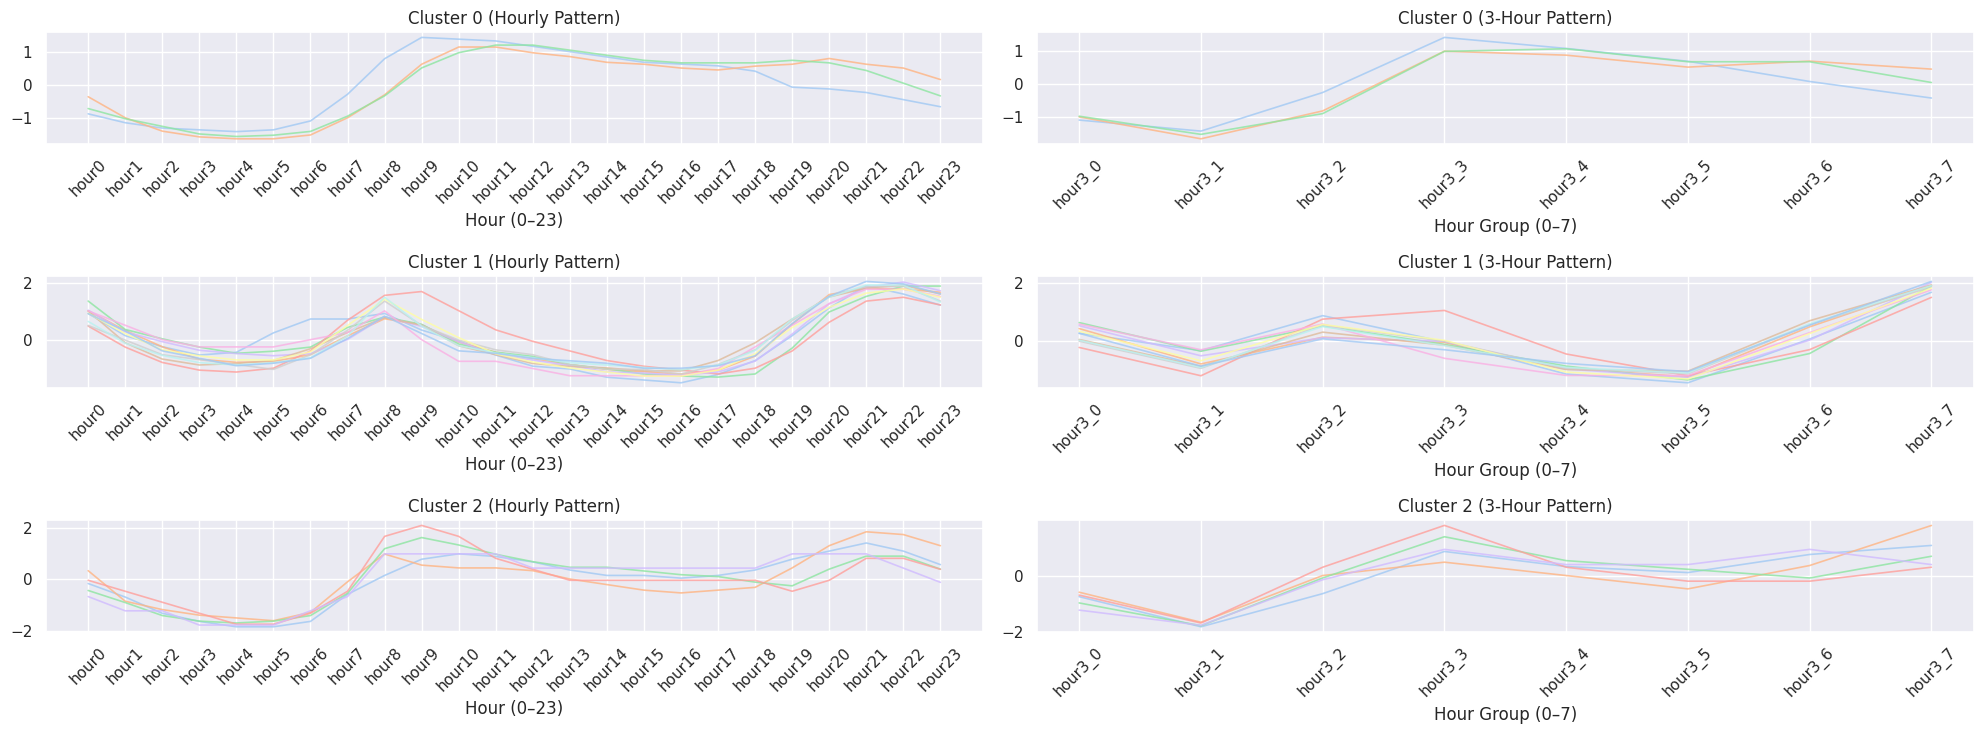

In [ ]:
# 클러스터 리스트 (유연하게)
unique_clusters = sorted(df_clust_scaled_num3['km_cluster'].unique())
n_c = len(unique_clusters)


# 시각화
fig = plt.figure(figsize=(20, 2.5 * n_c))

for idx, c in enumerate(unique_clusters):
    temp = df_clust_scaled_num3[df_clust_scaled_num3.km_cluster == c]

    # 1시간 단위
    plt.subplot(n_c, 2, 2 * idx + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Hourly Pattern)', fontsize=12)
    plt.xlabel('Hour (0–23)')
    plt.xticks(rotation=45)
    plt.grid(True)

    # 3시간 단위
    plt.subplot(n_c, 2, 2 * idx + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (3-Hour Pattern)', fontsize=12)
    plt.xlabel('Hour Group (0–7)')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

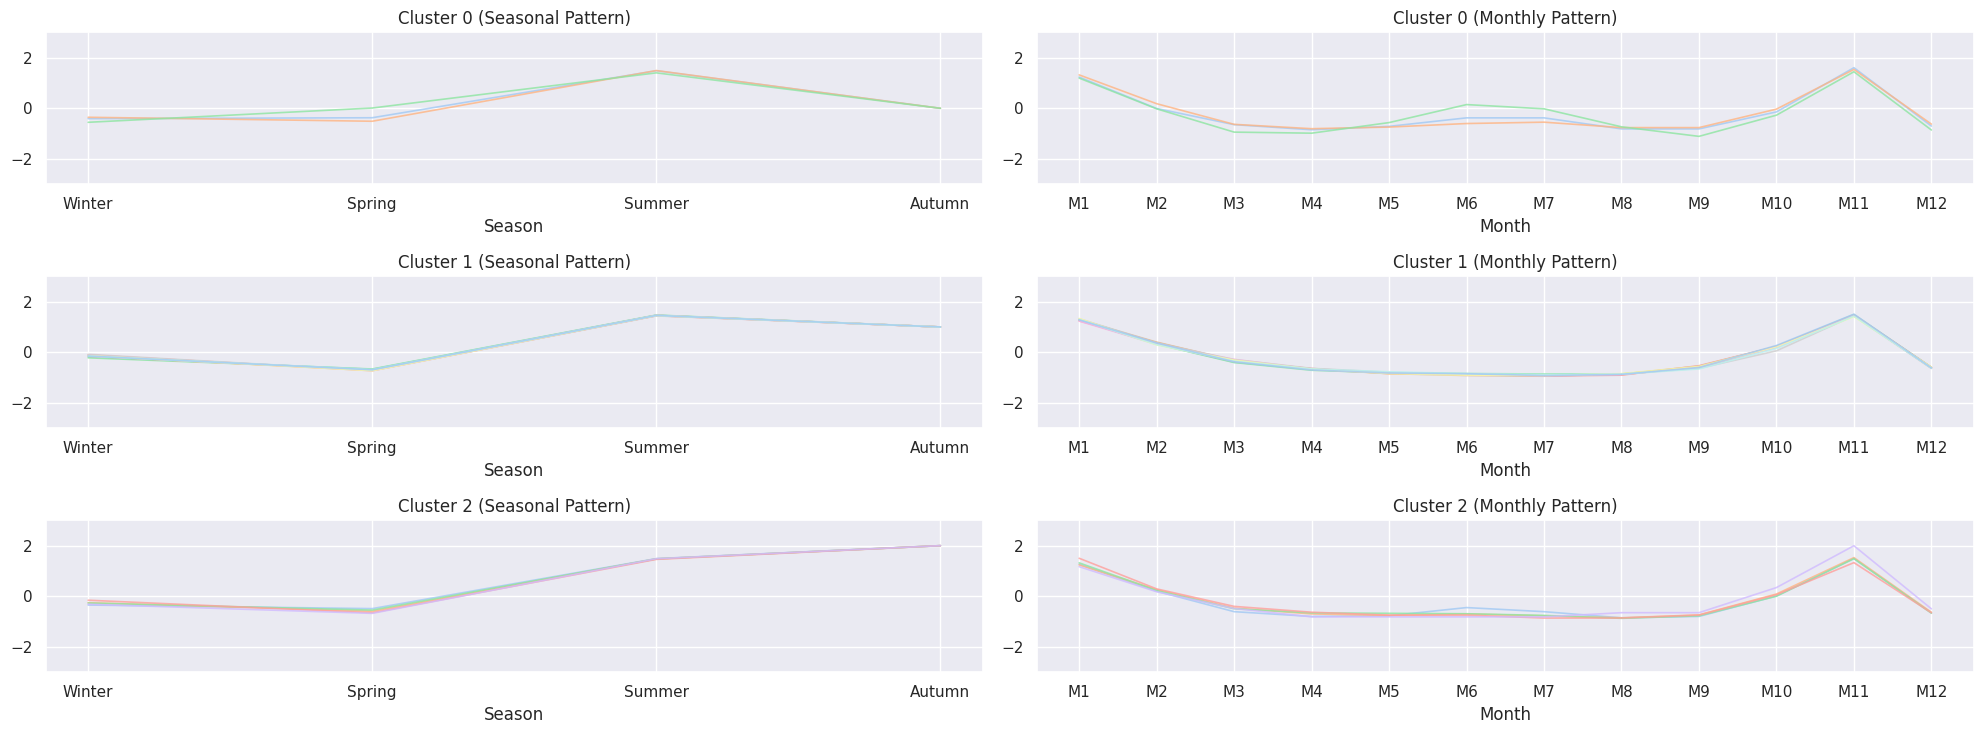

In [ ]:
# 클러스터 수 자동 계산
n_c = len(np.unique(df_clust_scaled_num3.km_cluster))
fig = plt.figure(figsize=(20, 2.5 * n_c))

# 공통 y축 범위 설정
common_ylim = (-3, 3)

for c in range(n_c):
    temp = df_clust_scaled_num3[df_clust_scaled_num3.km_cluster == c]

    # 계절별 시각화 (마지막 4개 컬럼)
    plt.subplot(n_c, 2, 2 * c + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -4:], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Seasonal Pattern)', fontsize=12)
    plt.xticks(range(4), ['Winter', 'Spring', 'Summer', 'Autumn'])
    plt.xlabel('Season')
    plt.ylim(common_ylim)
    plt.grid(True)

    # 월별 시각화 (그 앞의 12개 컬럼)
    plt.subplot(n_c, 2, 2 * c + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -16:-4], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Monthly Pattern)', fontsize=12)
    plt.xticks(range(12), [f'M{i+1}' for i in range(12)])
    plt.xlabel('Month')
    plt.ylim(common_ylim)
    plt.grid(True)

plt.tight_layout()
plt.show()

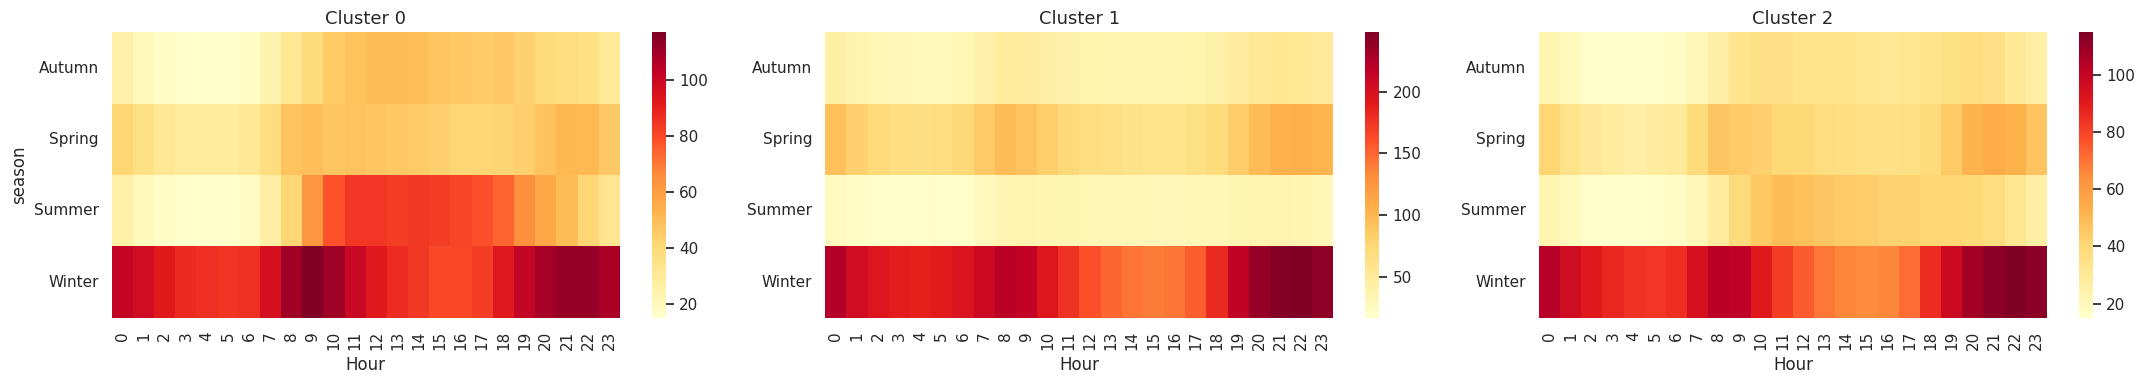

In [ ]:
# branch_id별 클러스터 정보 병합
df_heatmap = df_train.merge(
    df_clust_scaled_num3[['branch_id', 'km_cluster']], on='branch_id', how='left'
)

# 시각화
fig = plt.figure(figsize=(22, 4))

for c in sorted(df_heatmap.km_cluster.unique()):
    temp = df_heatmap[df_heatmap.km_cluster == c]

    # 요일(hour)별 중앙값 피벗 테이블
    pivot_table = temp.groupby(['season', 'hour'])['heat_demand'].median().reset_index()
    heat = pivot_table.pivot(index='season', columns='hour', values='heat_demand')

    plt.subplot(1, len(df_heatmap.km_cluster.unique()), c+1)
    sns.heatmap(heat, cmap='YlOrRd', cbar=True)
    plt.title(f'Cluster {c}', fontsize=13)
    plt.xlabel('Hour')
    plt.ylabel('season' if c == 0 else '')
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

* 군집 개수를 4로

In [ ]:
kmeans4 = KMeans(n_clusters=4, random_state = 0)
km_cluster4 = kmeans4.fit_predict(df_pattern_scaled.iloc[:,1:])

In [ ]:
# 스케일된 그래프
df_clust_scaled_num4 = df_pattern_scaled.copy()
df_clust_scaled_num4['km_cluster'] = km_cluster4

# 원본 그래프
df_clust_origin_num4 = df_pattern.copy()  # ✅ 원본 값 사용
df_clust_origin_num4['km_cluster'] = km_cluster4

In [ ]:
# 클러스터별 포함 지점 리스트
for c in sorted(df_clust_origin_num4.km_cluster.unique()):
    members = df_clust_origin_num4[df_clust_origin_num4.km_cluster == c]['branch_id'].tolist()
    print(f'Cluster {c}: {members}')

Cluster 0: ['J', 'K']
Cluster 1: ['A', 'B', 'C', 'D', 'G', 'H', 'L', 'M', 'N', 'O', 'Q']
Cluster 2: ['F', 'I', 'P', 'R', 'S']
Cluster 3: ['E']


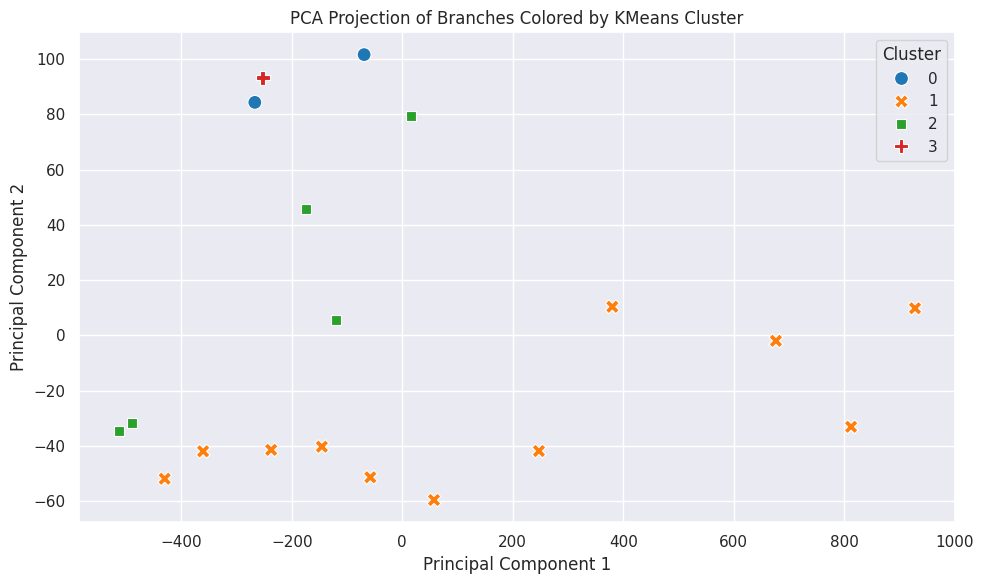

In [ ]:
# branch_id와 cluster 제외한 feature만 사용
X = df_pattern.iloc[:, 1:]

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 결과 DataFrame 생성
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = km_cluster4  # 위에서 예측한 결과 사용
pca_df['branch_id'] = df_pattern_scaled['branch_id'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', style='cluster', palette='tab10', s=100)
plt.title("PCA Projection of Branches Colored by KMeans Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


=> 패스

##### 2-2. 행 단위 변수별 표준화 진행하지 않고 -> 절대적인 양이나 차이를 반영하고 싶을 때

In [ ]:
df_pattern_no_scaled = df_pattern.copy()

In [ ]:
df_pattern_no_scaled

branch_id  hour0  hour1  hour2  hour3  hour4  hour5  hour6  hour7  hour8  \
0          A   75.0   67.0   63.0   60.0   61.0   68.0   73.0   73.0   75.0   
1          B  189.0  164.0  143.0  127.0  123.0  124.0  133.0  157.0  179.0   
2          C  205.5  178.0  169.0  161.0  155.0  157.0  161.0  180.0  190.0   
3          D  114.0  103.0   95.0   91.0   90.0   92.0  101.0  117.0  130.0   
4          E   31.0   26.0   23.0   22.0   21.0   22.0   27.0   42.0   62.0   
5          F   50.0   45.0   39.0   36.0   34.0   34.0   36.0   46.0   53.0   
6          G  169.0  149.0  140.0  132.0  129.0  127.0  129.0  142.0  163.0   
7          H  109.5   88.0   77.0   73.0   74.0   76.0   84.0   95.0  105.0   
8          I   56.0   45.0   42.0   40.0   39.0   38.0   41.0   52.0   62.0   
9          J   60.0   49.0   42.0   39.0   38.0   38.0   40.0   49.0   61.0   
10         K   36.0   32.0   29.0   26.0   25.0   25.5   27.0   33.0   41.0   
11         L   21.0   19.0   17.0   16.0   16.0   16.0   17.0   18.0   21.0   
12         M   28.0   25.0   22.0   21.0   20.0   19.0   22.0   27.0   33.0   
13         N   70.0   60.0   52.0   49.0   47.0   47.0   51.0   64.0   77.0   
14         O   55.0   46.0   41.0   38.0   37.0   38.0   40.0   49.0   65.0   
15         P   68.5   62.0   55.0   52.0   51.0   52.0   55.0   67.0   91.0   
16         Q   50.0   43.0   35.0   32.0   29.0   30.0   32.0   40.0   49.0   
17         R   12.0   11.0   10.0    9.0    8.0    8.0    9.0   11.0   16.0   
18         S    8.0    7.0    7.0    6.0    6.0    6.0    7.0    8.0   11.0   

    ...  month7  month8  month9  month10  month11  month12  season_Winter  \
0   ...    29.0    26.0    29.0     54.0    124.0    231.0           34.0   
1   ...    69.0    61.0    67.0    121.0    258.0    480.0           84.0   
2   ...    90.0    87.0    88.0    132.5    287.0    518.0          103.0   
3   ...    52.0    42.0    46.0     91.0    182.0    331.0           62.0   
4   ...    39.0    39.0    26.0     26.0     46.0     98.0           26.0   
5   ...    51.0    45.0    36.0     38.0     68.0    123.0           37.0   
6   ...    69.0    60.0    70.0    116.0    233.0    422.0           83.0   
7   ...    33.0    30.0    39.0     73.0    156.5    290.0           49.0   
8   ...    40.0    36.0    32.0     38.0     81.0    156.0           35.0   
9   ...    56.5    59.0    49.0     49.0     83.0    156.0           49.0   
10  ...    55.0    51.0    34.0     25.0     45.0     86.0           27.0   
11  ...     8.0     7.0     8.0     13.0     28.0     51.0           10.0   
12  ...    13.0    12.0    13.0     19.0     37.0     73.0           15.0   
13  ...    22.0    21.0    26.0     45.0     98.0    179.0           32.0   
14  ...    25.0    23.0    24.0     35.0     79.0    148.0           28.0   
15  ...    55.0    51.0    44.0     50.0     97.0    187.0           48.0   
16  ...    20.0    17.0    19.0     30.0     65.0    115.0           23.0   
17  ...     8.0     7.0     7.0      8.0     15.0     26.0            8.0   
18  ...     6.0     6.0     7.0      7.0     13.0     23.0            7.0   

    season_Spring  season_Summer  season_Autumn  
0            72.0           29.0          216.0  
1           172.0           68.0          438.0  
2           171.0           91.0          477.0  
3           115.0           49.0          307.0  
4            34.0           35.0           86.0  
5            48.0           43.0          113.0  
6           153.5           69.0          385.0  
7            98.0           35.0          266.0  
8            54.0           37.0          141.0  
9            61.0           54.0          143.0  
10           34.0           47.0           79.0  
11           19.0            8.0           46.0  
12           29.0           13.0           67.0  
13           61.0           23.0          163.0  
14           53.0           25.0          137.0  
15           71.0           55.0          171.0  
16           41.0           20.

* 그래프로 확인

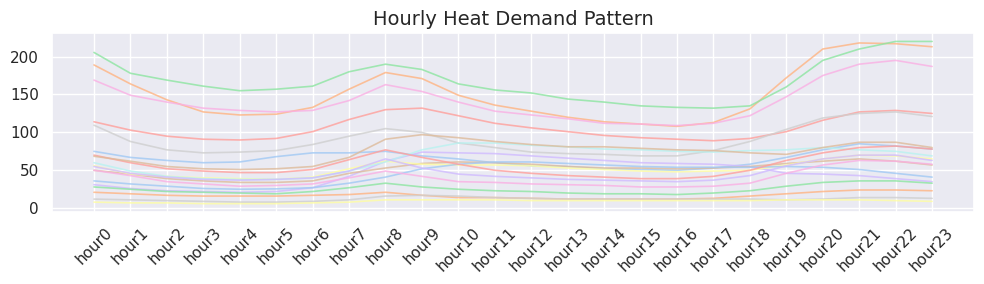

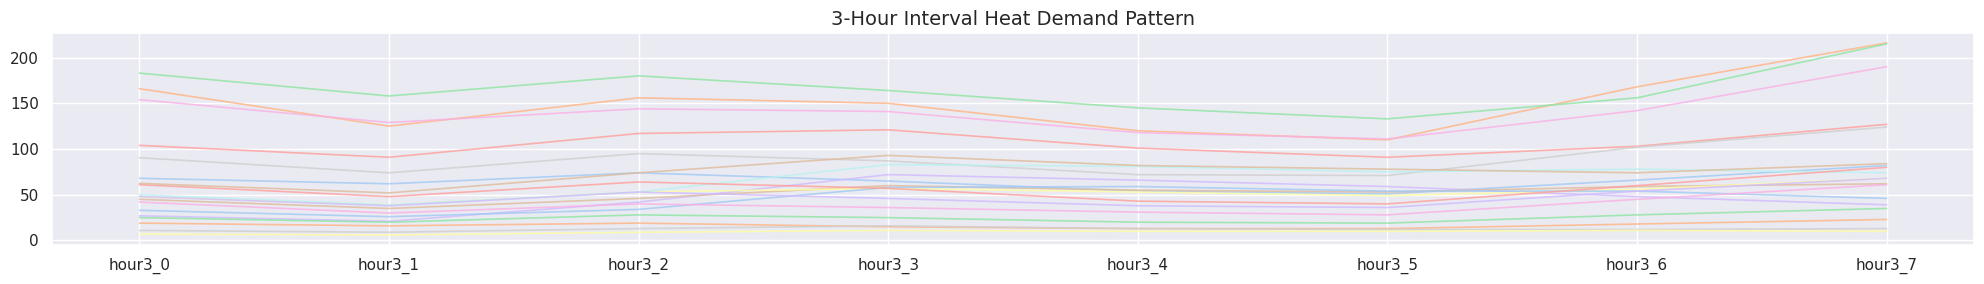

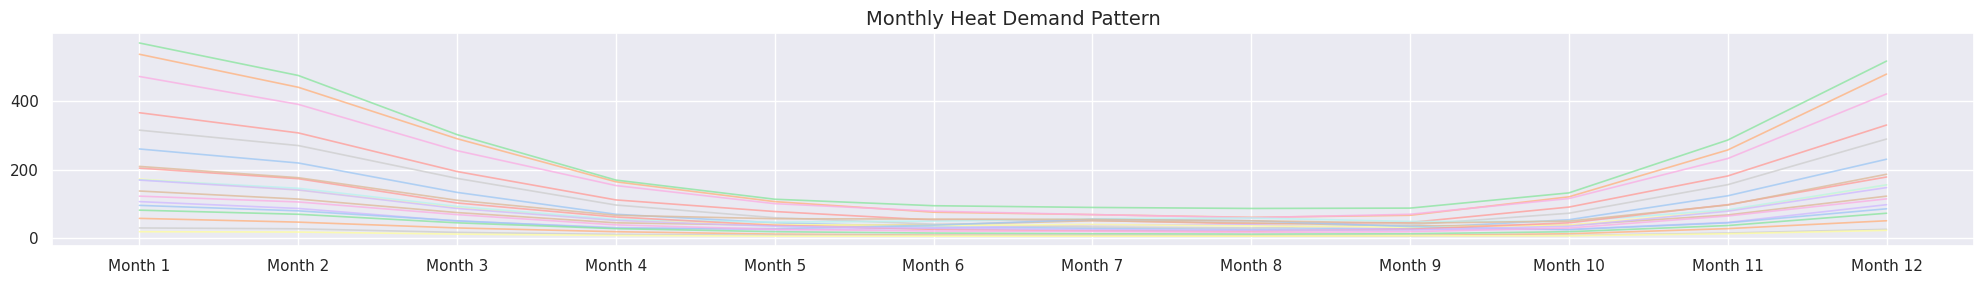

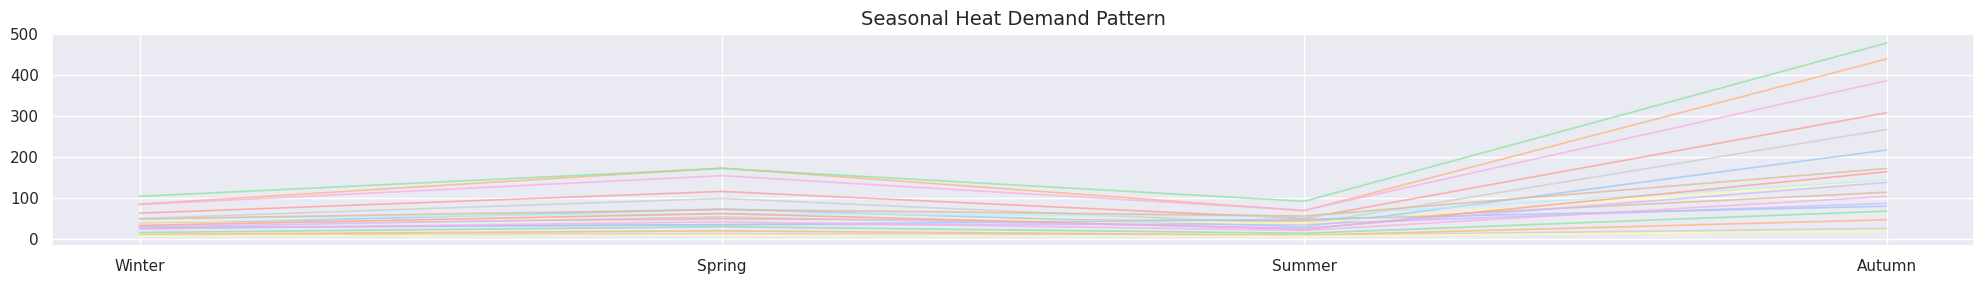

In [ ]:
# 1시간 단위 시각화 (hour0 ~ hour23)
fig = plt.figure(figsize=(10, 3))
for i in range(len(df_pattern_no_scaled)):
    plt.plot(df_pattern_no_scaled.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
plt.title("Hourly Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(24), labels=[f'hour{i}' for i in range(24)], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3시간 단위 시각화 (hour3_0 ~ hour3_7)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern_no_scaled)):
    plt.plot(df_pattern_no_scaled.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
plt.title("3-Hour Interval Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(8), labels=[f'hour3_{i}' for i in range(8)], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 월별 시각화 (month1 ~ month12 assumed at 33:44)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern_no_scaled)):
    plt.plot(df_pattern_no_scaled.iloc[i, 33:45], alpha=0.8, linewidth=1.2)
plt.title("Monthly Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(12), labels=[f'Month {i+1}' for i in range(12)], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 계절별 시각화 (season_Winter ~ season_Autumn assumed at 45:49)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern_no_scaled)):
    plt.plot(df_pattern_no_scaled.iloc[i, 45:49], alpha=0.8, linewidth=1.2)
plt.title("Seasonal Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(4), labels=["Winter", "Spring", "Summer", "Autumn"])
plt.grid(True)
plt.tight_layout()
plt.show()

* 군집화

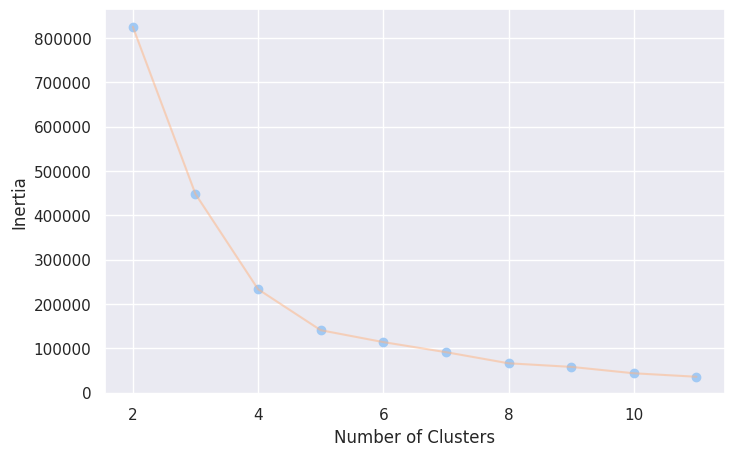

In [ ]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df_pattern_no_scaled.iloc[:,1:])

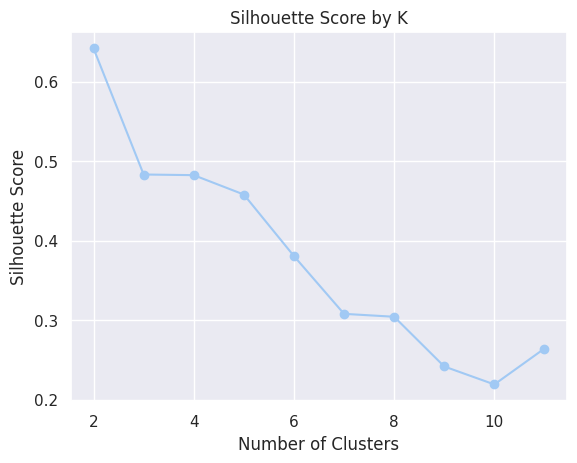

In [ ]:
scores = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pattern_no_scaled.iloc[:,1:])
    score = silhouette_score(df_pattern_no_scaled.iloc[:,1:], labels)
    scores.append(score)

# 시각화
plt.plot(range(2, 12), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.grid(True)
plt.show()

* 군집의 개수를 3으로

In [ ]:
kmeans3 = KMeans(n_clusters=3, random_state = 0)
km_cluster3 = kmeans3.fit_predict(df_pattern_no_scaled.iloc[:,1:])

In [ ]:
# 원본 그래프
df_clust_origin_no_num3 = df_pattern_no_scaled.copy()  # ✅ 원본 값 사용
df_clust_origin_no_num3['km_cluster'] = km_cluster3

In [ ]:
# 클러스터별 포함 지점 리스트
for c in sorted(df_clust_origin_no_num3.km_cluster.unique()):
    members = df_clust_origin_no_num3[df_clust_origin_no_num3.km_cluster == c]['branch_id'].tolist()
    print(f'Cluster {c}: {members}')

Cluster 0: ['E', 'F', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'Q', 'R', 'S']
Cluster 1: ['B', 'C', 'G']
Cluster 2: ['A', 'D', 'H', 'P']


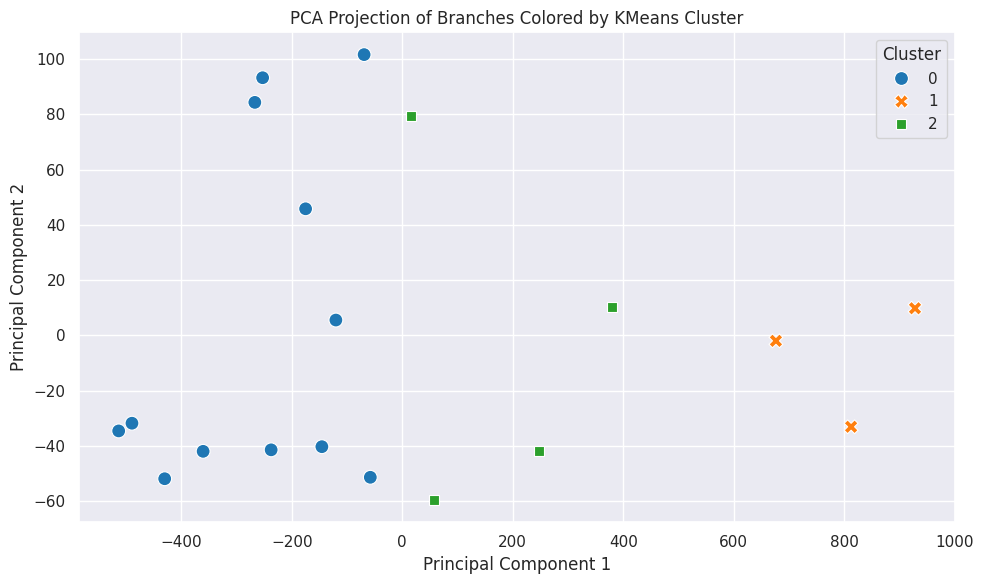

In [ ]:
# branch_id와 cluster 제외한 feature만 사용
X = df_pattern.iloc[:, 1:]

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 결과 DataFrame 생성
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = km_cluster3  # 위에서 예측한 결과 사용
pca_df['branch_id'] = df_pattern['branch_id'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', style='cluster', palette='tab10', s=100)
plt.title("PCA Projection of Branches Colored by KMeans Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


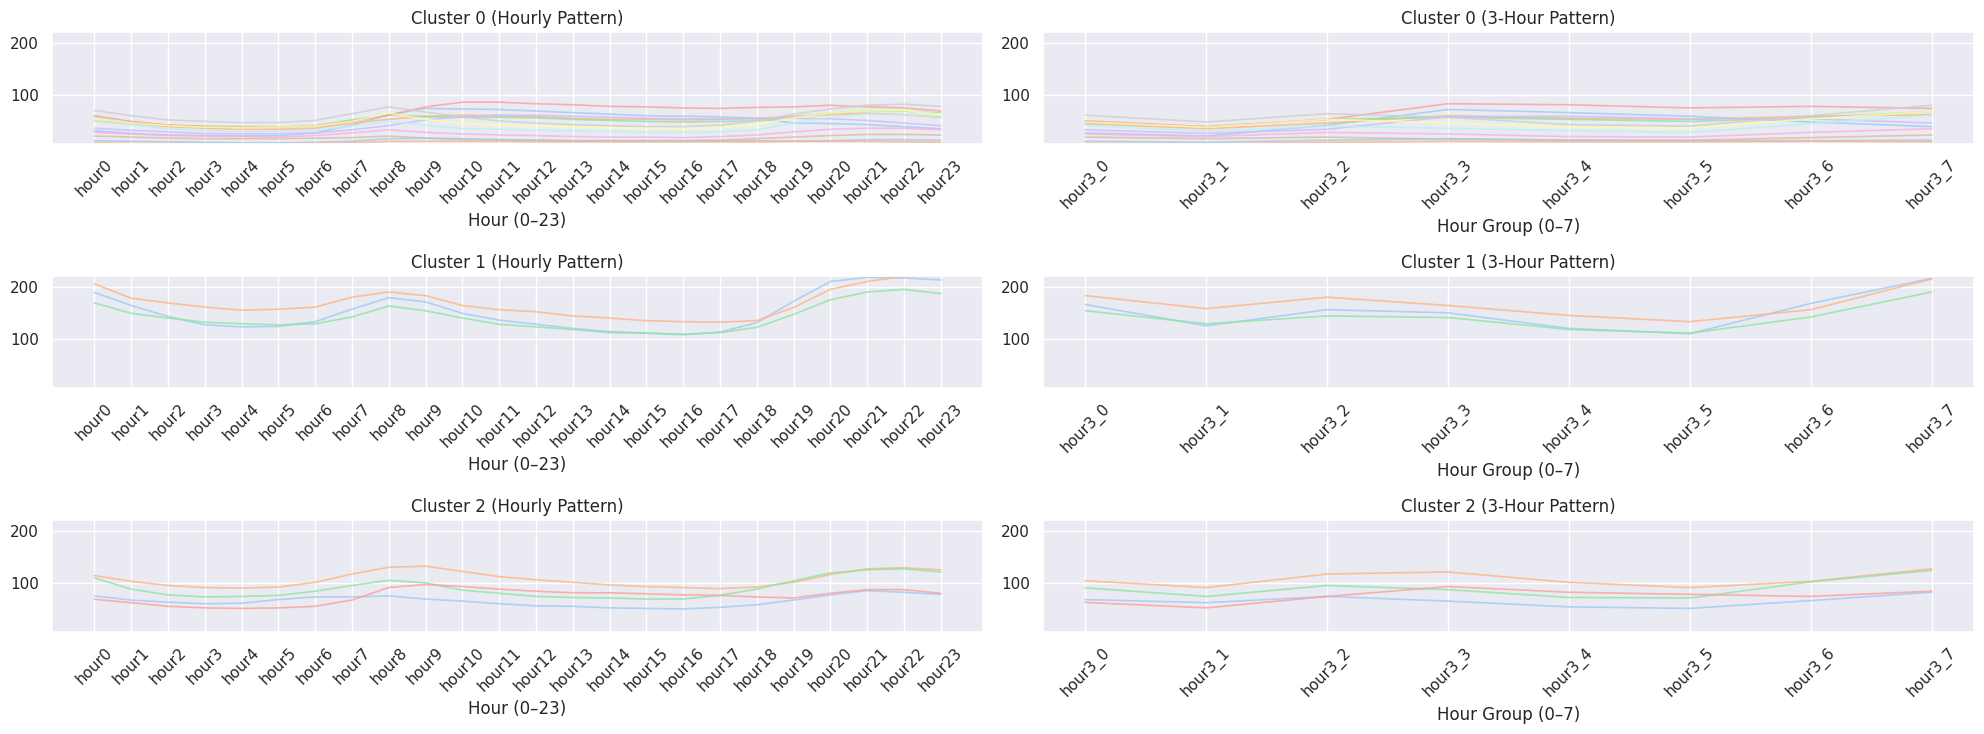

In [ ]:
# 공통 y축 범위 계산
ymin = df_clust_origin_no_num3.iloc[:, 1:33].min().min()
ymax = df_clust_origin_no_num3.iloc[:, 1:33].max().max()
common_ylim = (ymin, ymax)

# 시각화
fig = plt.figure(figsize=(20, 2.5 * n_c))

for idx, c in enumerate(unique_clusters):
    temp = df_clust_origin_no_num3[df_clust_origin_no_num3.km_cluster == c]

    # 1시간 단위
    plt.subplot(n_c, 2, 2 * idx + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Hourly Pattern)', fontsize=12)
    plt.xlabel('Hour (0–23)')
    plt.xticks(rotation=45)
    plt.ylim(common_ylim)
    plt.grid(True)

    # 3시간 단위
    plt.subplot(n_c, 2, 2 * idx + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (3-Hour Pattern)', fontsize=12)
    plt.xlabel('Hour Group (0–7)')
    plt.xticks(rotation=45)
    plt.ylim(common_ylim)
    plt.grid(True)

plt.tight_layout()
plt.show()

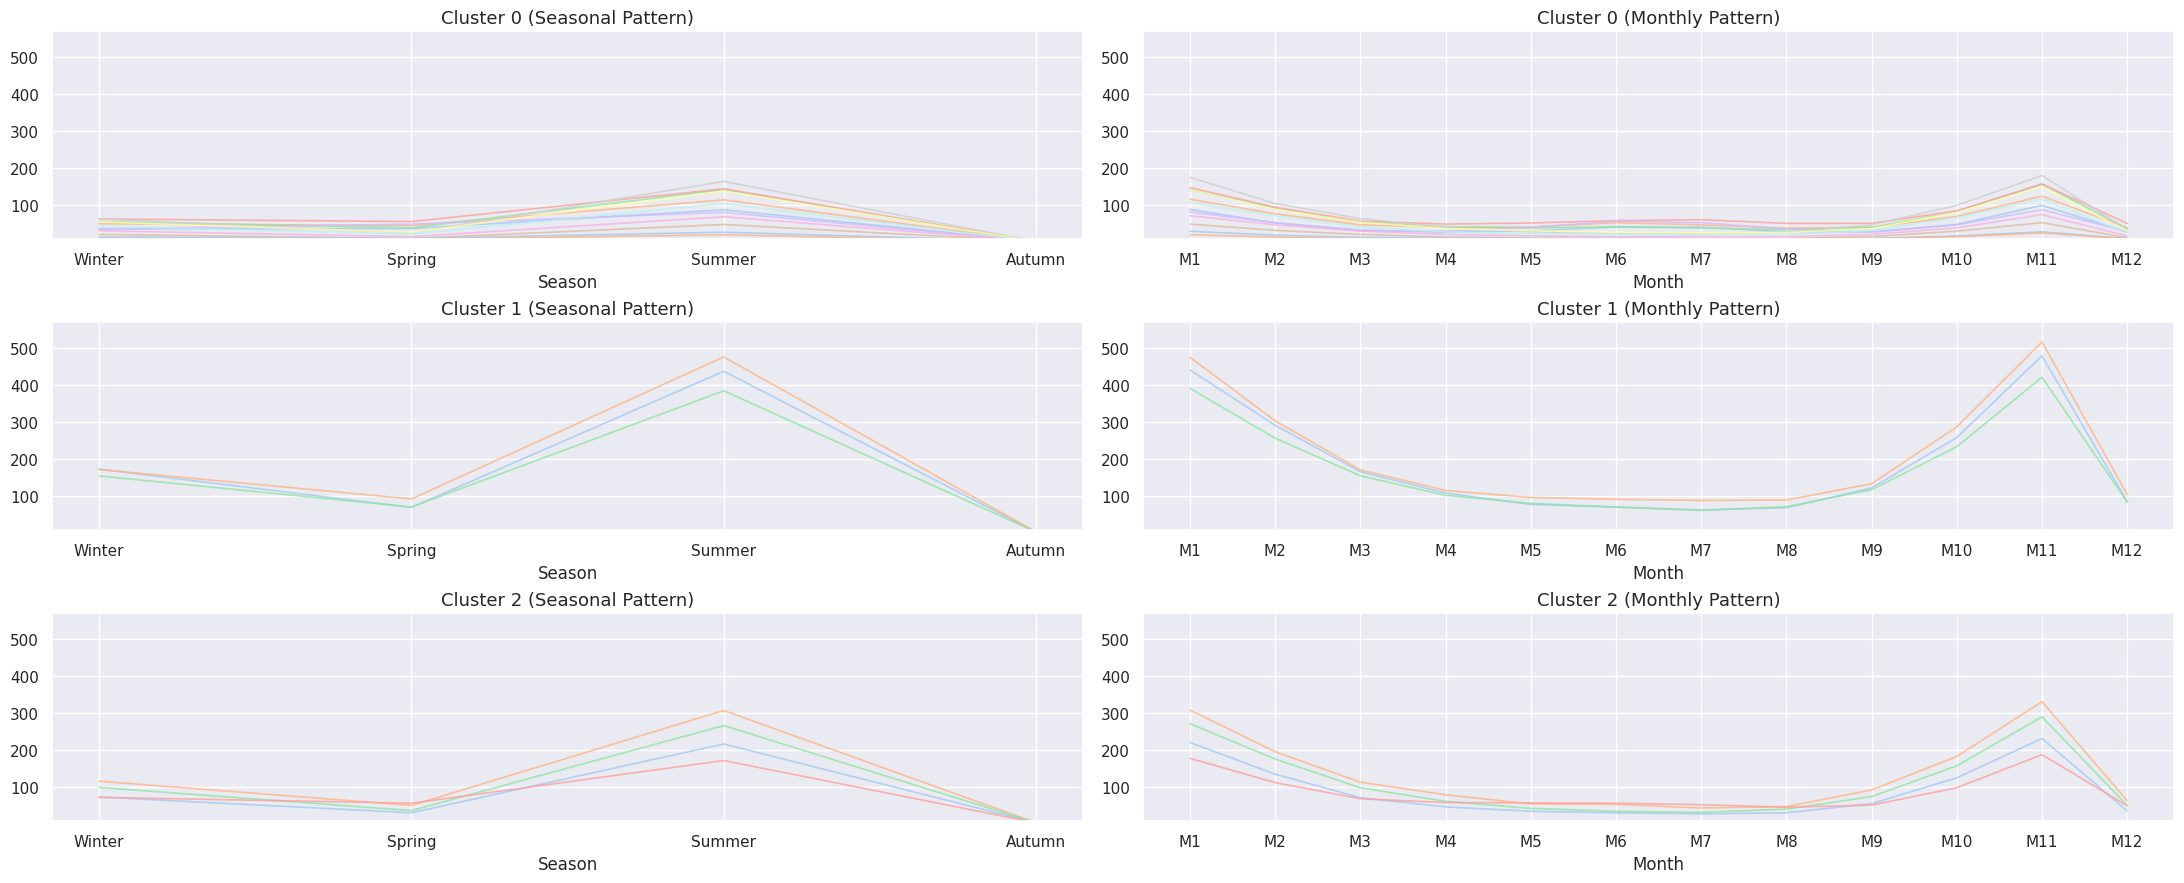

In [ ]:
# 공통 y축 범위 계산 (열 수요 원본 기준)
ymin = df_clust_origin_no_num3.iloc[:, 33:49].min().min()
ymax = df_clust_origin_no_num3.iloc[:, 33:49].max().max()
common_ylim = (ymin, ymax)

# 클러스터 수 자동 계산
n_c = len(np.unique(df_clust_origin_no_num3.km_cluster))

# 더 큰 그림 크기 확보
fig = plt.figure(figsize=(22, 3 * n_c))

for c in range(n_c):
    temp = df_clust_origin_no_num3[df_clust_origin_no_num3.km_cluster == c]

    # 계절별 시각화
    plt.subplot(n_c, 2, 2 * c + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -4:], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Seasonal Pattern)', fontsize=13)
    plt.xticks(ticks=range(4), labels=['Winter', 'Spring', 'Summer', 'Autumn'])
    plt.xlabel('Season')
    plt.ylim(common_ylim)
    plt.grid(True)

    # 월별 시각화
    plt.subplot(n_c, 2, 2 * c + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -16:-4], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Monthly Pattern)', fontsize=13)
    plt.xticks(ticks=range(12), labels=[f'M{i+1}' for i in range(12)])
    plt.xlabel('Month')
    plt.ylim(common_ylim)
    plt.grid(True)

# 여백 조정으로 잘림 방지
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # 수직 간격 조정
plt.show()

* 군집의 개수를  4로

In [ ]:
kmeans4 = KMeans(n_clusters=4, random_state = 0)
km_cluster4 = kmeans4.fit_predict(df_pattern_no_scaled.iloc[:,1:])

In [ ]:
# 원본 그래프
df_clust_origin_no_num4 = df_pattern_no_scaled.copy()  # ✅ 원본 값 사용
df_clust_origin_no_num4['km_cluster'] = km_cluster4

In [ ]:
df_clust_origin_no_num4

branch_id  hour0  hour1  hour2  hour3  hour4  hour5  hour6  hour7  hour8  \
0          A   75.0   67.0   63.0   60.0   61.0   68.0   73.0   73.0   75.0   
1          B  189.0  164.0  143.0  127.0  123.0  124.0  133.0  157.0  179.0   
2          C  205.5  178.0  169.0  161.0  155.0  157.0  161.0  180.0  190.0   
3          D  114.0  103.0   95.0   91.0   90.0   92.0  101.0  117.0  130.0   
4          E   31.0   26.0   23.0   22.0   21.0   22.0   27.0   42.0   62.0   
5          F   50.0   45.0   39.0   36.0   34.0   34.0   36.0   46.0   53.0   
6          G  169.0  149.0  140.0  132.0  129.0  127.0  129.0  142.0  163.0   
7          H  109.5   88.0   77.0   73.0   74.0   76.0   84.0   95.0  105.0   
8          I   56.0   45.0   42.0   40.0   39.0   38.0   41.0   52.0   62.0   
9          J   60.0   49.0   42.0   39.0   38.0   38.0   40.0   49.0   61.0   
10         K   36.0   32.0   29.0   26.0   25.0   25.5   27.0   33.0   41.0   
11         L   21.0   19.0   17.0   16.0   16.0   16.0   17.0   18.0   21.0   
12         M   28.0   25.0   22.0   21.0   20.0   19.0   22.0   27.0   33.0   
13         N   70.0   60.0   52.0   49.0   47.0   47.0   51.0   64.0   77.0   
14         O   55.0   46.0   41.0   38.0   37.0   38.0   40.0   49.0   65.0   
15         P   68.5   62.0   55.0   52.0   51.0   52.0   55.0   67.0   91.0   
16         Q   50.0   43.0   35.0   32.0   29.0   30.0   32.0   40.0   49.0   
17         R   12.0   11.0   10.0    9.0    8.0    8.0    9.0   11.0   16.0   
18         S    8.0    7.0    7.0    6.0    6.0    6.0    7.0    8.0   11.0   

    ...  month8  month9  month10  month11  month12  season_Winter  \
0   ...    26.0    29.0     54.0    124.0    231.0           34.0   
1   ...    61.0    67.0    121.0    258.0    480.0           84.0   
2   ...    87.0    88.0    132.5    287.0    518.0          103.0   
3   ...    42.0    46.0     91.0    182.0    331.0           62.0   
4   ...    39.0    26.0     26.0     46.0     98.0           26.0   
5   ...    45.0    36.0     38.0     68.0    123.0           37.0   
6   ...    60.0    70.0    116.0    233.0    422.0           83.0   
7   ...    30.0    39.0     73.0    156.5    290.0           49.0   
8   ...    36.0    32.0     38.0     81.0    156.0           35.0   
9   ...    59.0    49.0     49.0     83.0    156.0           49.0   
10  ...    51.0    34.0     25.0     45.0     86.0           27.0   
11  ...     7.0     8.0     13.0     28.0     51.0           10.0   
12  ...    12.0    13.0     19.0     37.0     73.0           15.0   
13  ...    21.0    26.0     45.0     98.0    179.0           32.0   
14  ...    23.0    24.0     35.0     79.0    148.0           28.0   
15  ...    51.0    44.0     50.0     97.0    187.0           48.0   
16  ...    17.0    19.0     30.0     65.0    115.0           23.0   
17  ...     7.0     7.0      8.0     15.0     26.0            8.0   
18  ...     6.0     7.0      7.0     13.0     23.0            7.0   

    season_Spring  season_Summer  season_Autumn  km_cluster  
0            72.0           29.0          216.0           2  
1           172.0           68.0          438.0           1  
2           171.0           91.0          477.0           1  
3           115.0           49.0          307.0           2  
4            34.0           35.0           86.0           0  
5            48.0           43.0          113.0           0  
6           153.5           69.0          385.0           1  
7            98.0           35.0          266.0           2  
8            54.0           37.0          141.0           0  
9            61.0           54.0          143.0           0  
10           34.0           47.0           79.0           0  
11           19.0            8.0           46.0           3  
12           29.0           13.0           67.0           3  
13           61.0           23.0          163.0           0  
14           53.0           25.0          137.0           0  
15           71.0           55.0          171.0  

In [ ]:
# 클러스터별 포함 지점 리스트
for c in sorted(df_clust_origin_no_num4.km_cluster.unique()):
    members = df_clust_origin_no_num4[df_clust_origin_no_num4.km_cluster == c]['branch_id'].tolist()
    print(f'Cluster {c}: {members}')

Cluster 0: ['E', 'F', 'I', 'J', 'K', 'N', 'O', 'Q']
Cluster 1: ['B', 'C', 'G']
Cluster 2: ['A', 'D', 'H', 'P']
Cluster 3: ['L', 'M', 'R', 'S']


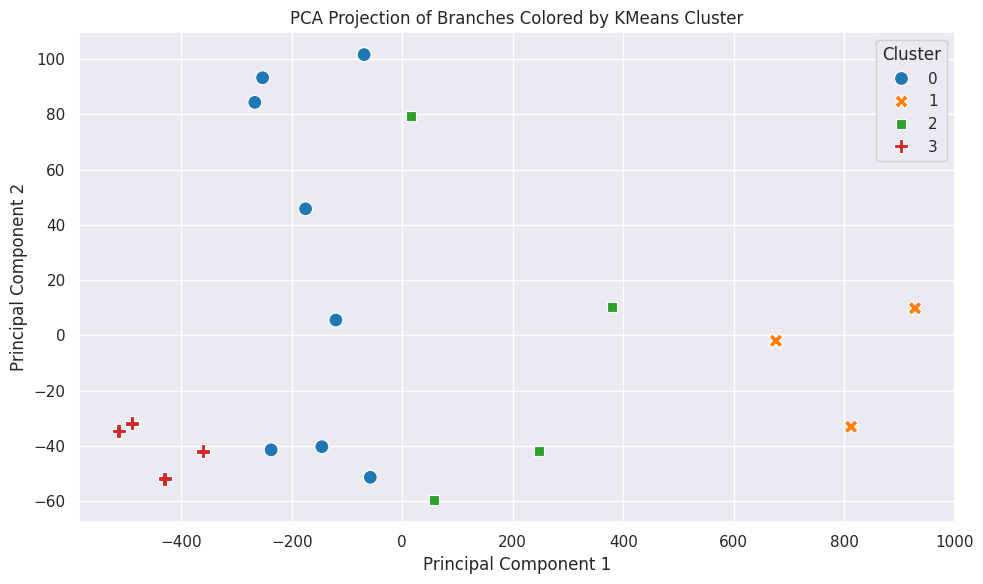

In [ ]:
# branch_id와 cluster 제외한 feature만 사용
X = df_pattern.iloc[:, 1:]

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 결과 DataFrame 생성
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = km_cluster4  # 위에서 예측한 결과 사용
pca_df['branch_id'] = df_pattern['branch_id'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', style='cluster', palette='tab10', s=100)
plt.title("PCA Projection of Branches Colored by KMeans Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


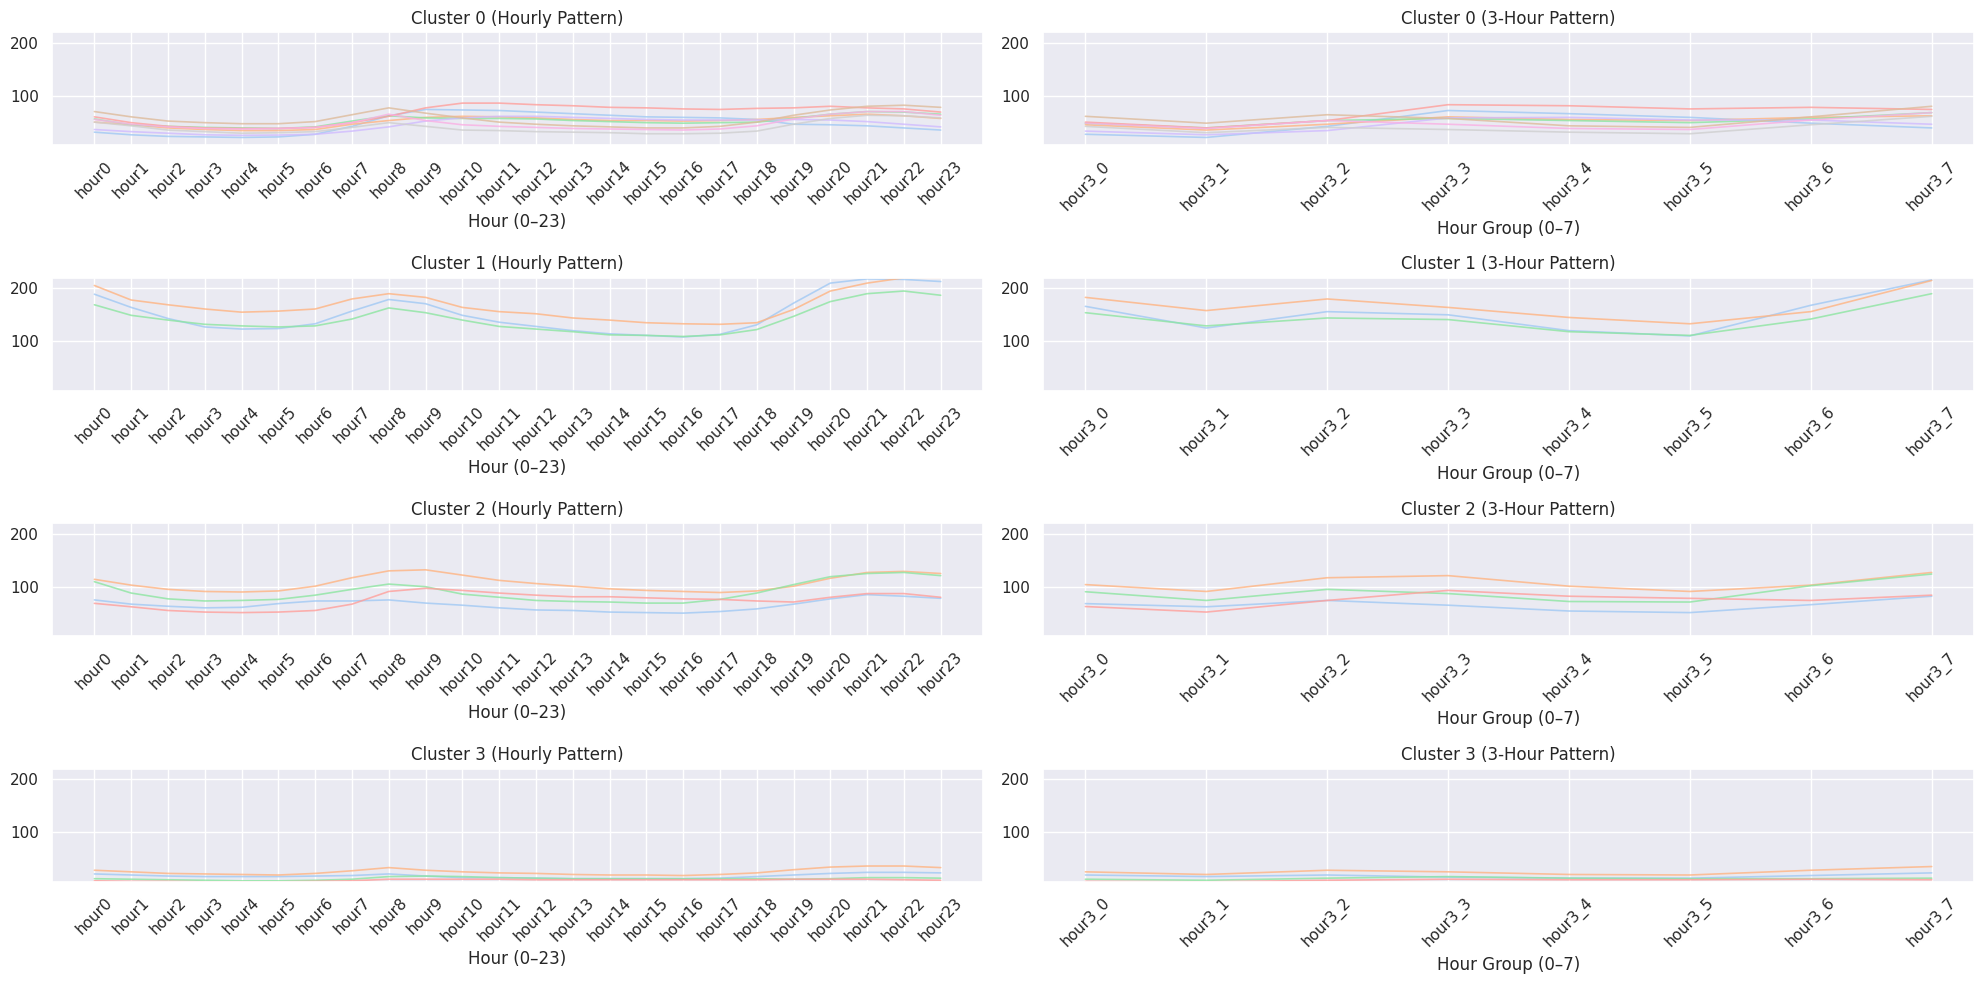

In [ ]:
# 공통 y축 범위 계산
ymin = df_clust_origin_no_num4.iloc[:, 1:33].min().min()
ymax = df_clust_origin_no_num4.iloc[:, 1:33].max().max()
common_ylim = (ymin, ymax)

# 클러스터 수 자동 계산
n_c = len(np.unique(df_clust_origin_no_num4.km_cluster))

# 시각화
fig = plt.figure(figsize=(20, 2.5 * n_c))

for c in range(n_c):
    temp = df_clust_origin_no_num4[df_clust_origin_no_num4.km_cluster == c]

    # 1시간 단위
    plt.subplot(n_c, 2, 2 * c + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Hourly Pattern)', fontsize=12)
    plt.xlabel('Hour (0–23)')
    plt.xticks(rotation=45)
    plt.ylim(common_ylim)
    plt.grid(True)

    # 3시간 단위
    plt.subplot(n_c, 2, 2 * c + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (3-Hour Pattern)', fontsize=12)
    plt.xlabel('Hour Group (0–7)')
    plt.xticks(rotation=45)
    plt.ylim(common_ylim)
    plt.grid(True)

plt.tight_layout()
plt.show()

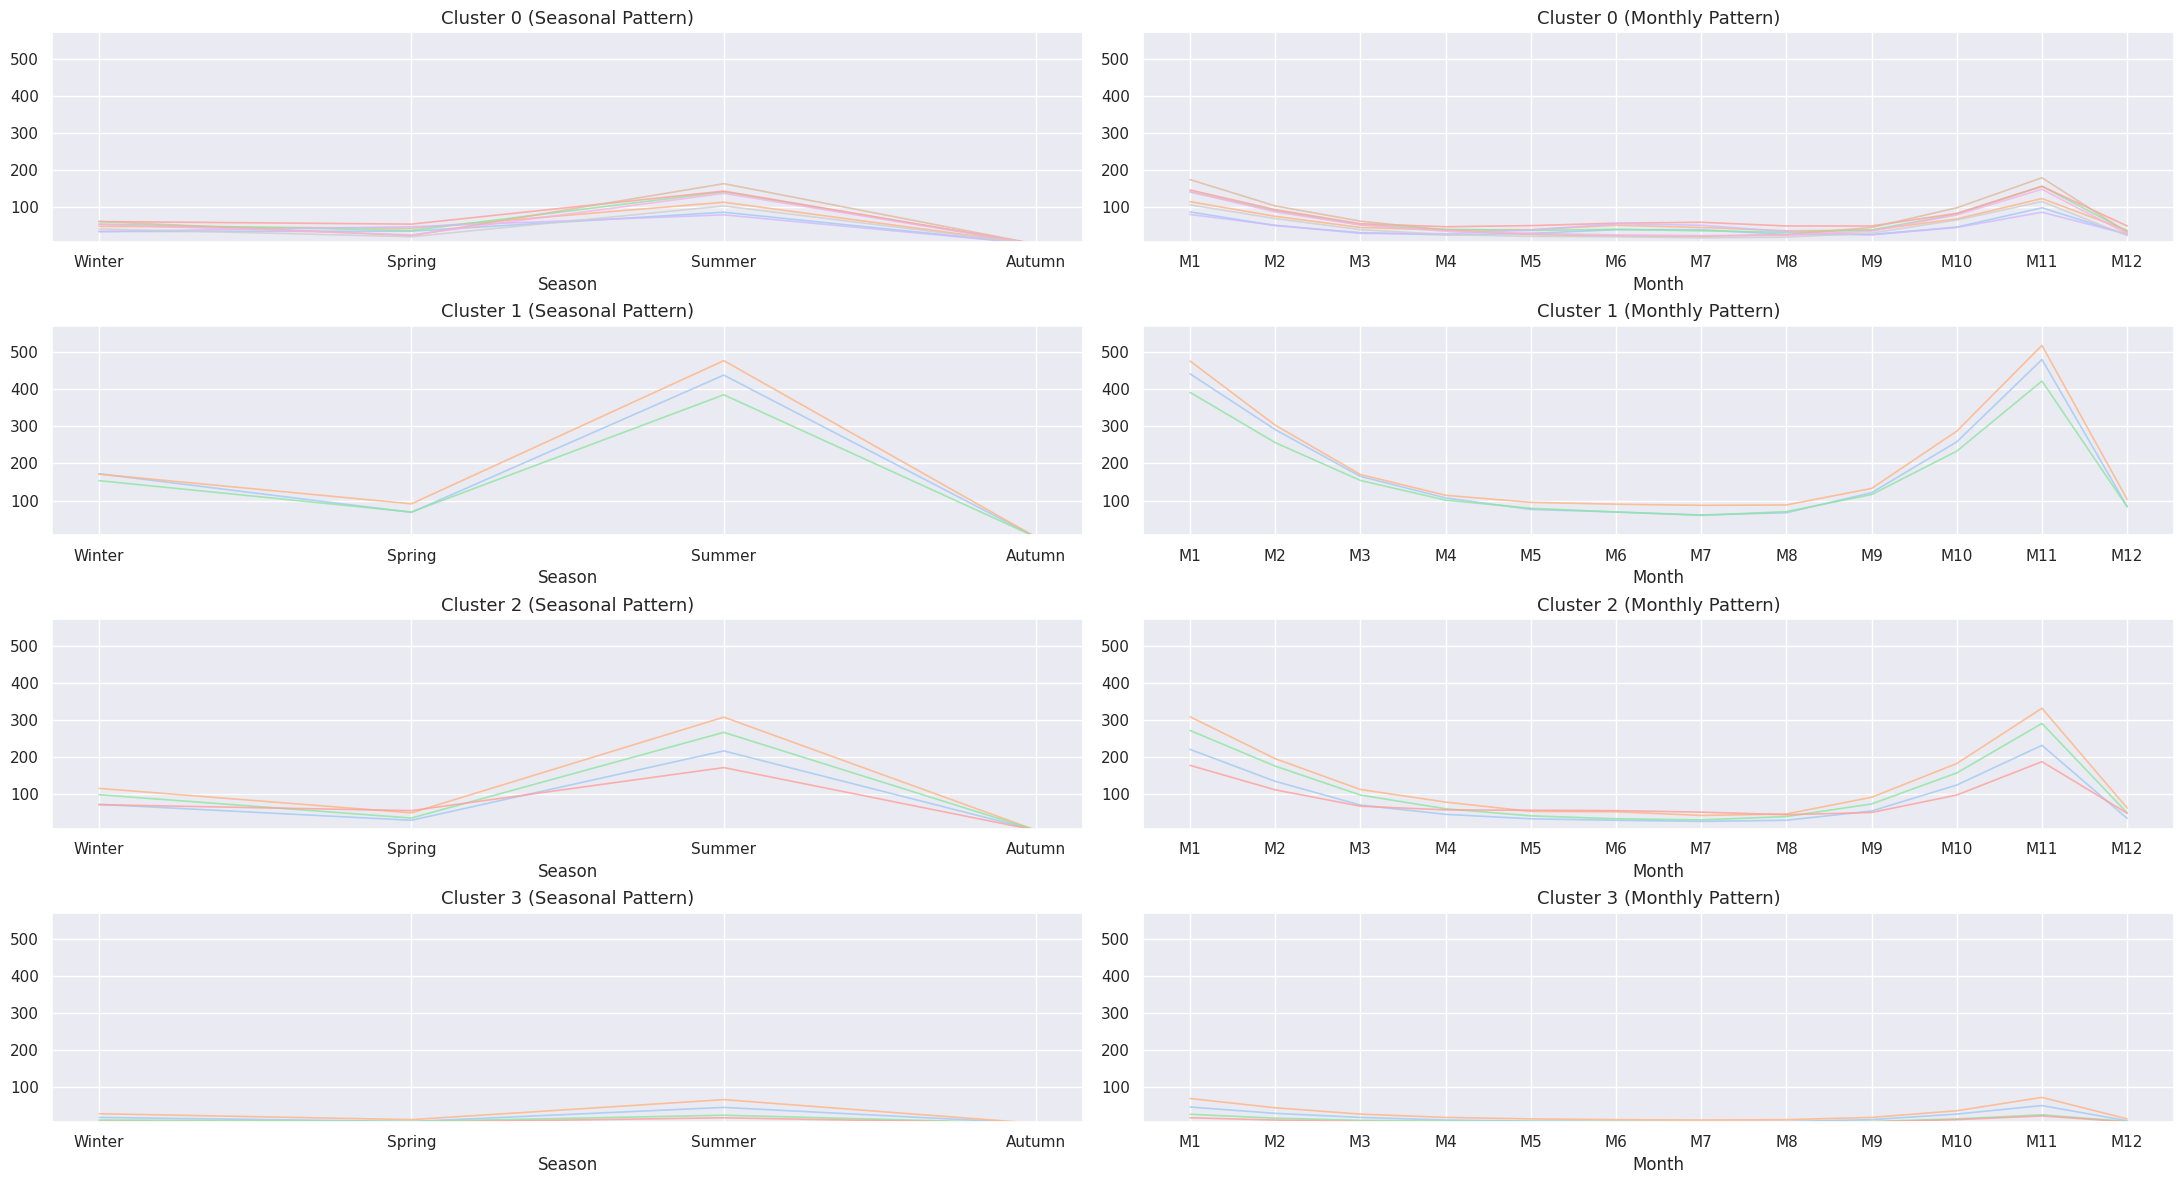

In [ ]:
# 공통 y축 범위 계산 (열 수요 원본 기준)
ymin = df_clust_origin_no_num4.iloc[:, 33:49].min().min()
ymax = df_clust_origin_no_num4.iloc[:, 33:49].max().max()
common_ylim = (ymin, ymax)

# 클러스터 수 자동 계산
n_c = len(np.unique(df_clust_origin_no_num4.km_cluster))

# 더 큰 그림 크기 확보
fig = plt.figure(figsize=(22, 3 * n_c))

for c in range(n_c):
    temp = df_clust_origin_no_num4[df_clust_origin_no_num4.km_cluster == c]

    # 계절별 시각화
    plt.subplot(n_c, 2, 2 * c + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -4:], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Seasonal Pattern)', fontsize=13)
    plt.xticks(ticks=range(4), labels=['Winter', 'Spring', 'Summer', 'Autumn'])
    plt.xlabel('Season')
    plt.ylim(common_ylim)
    plt.grid(True)

    # 월별 시각화
    plt.subplot(n_c, 2, 2 * c + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -16:-4], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Monthly Pattern)', fontsize=13)
    plt.xticks(ticks=range(12), labels=[f'M{i+1}' for i in range(12)])
    plt.xlabel('Month')
    plt.ylim(common_ylim)
    plt.grid(True)

# 여백 조정으로 잘림 방지
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # 수직 간격 조정
plt.show()

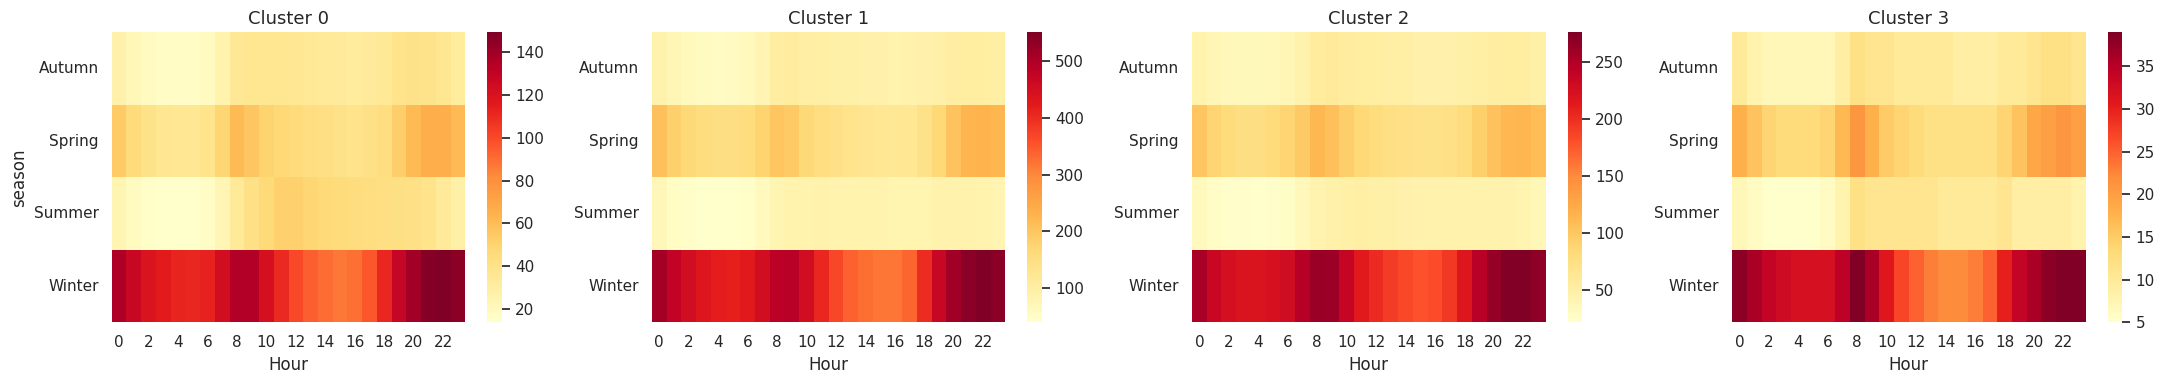

In [ ]:
# branch_id별 클러스터 정보 병합
df_heatmap = df_train.merge(
    df_clust_origin_no_num4[['branch_id', 'km_cluster']], on='branch_id', how='left'
)

# 시각화
fig = plt.figure(figsize=(22, 4))

for c in sorted(df_heatmap.km_cluster.unique()):
    temp = df_heatmap[df_heatmap.km_cluster == c]

    # 요일(hour)별 중앙값 피벗 테이블
    pivot_table = temp.groupby(['season', 'hour'])['heat_demand'].median().reset_index()
    heat = pivot_table.pivot(index='season', columns='hour', values='heat_demand')

    plt.subplot(1, len(df_heatmap.km_cluster.unique()), c+1)
    sns.heatmap(heat, cmap='YlOrRd', cbar=True)
    plt.title(f'Cluster {c}', fontsize=13)
    plt.xlabel('Hour')
    plt.ylabel('season' if c == 0 else '')
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()